In [1]:
import os
import pickle as pkl
from joblib import load, dump
import cv2
import matplotlib
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7305643726238887899
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 753534739225025844
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12032057708745933534
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5210945632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6216888900416206902
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
MODEL_LIST = []
MODEL_NAMES = ['skin_disease_resnet_No_AUG_88acc', 'resnet_model1_cifar10']

for i in range(len(MODEL_NAMES)):
    ### Loading DNN models 
    with open('Models/'+ MODEL_NAMES[i]+'.json', 'r') as j_file:
        loaded_model_json = j_file.read()
    model = tf.keras.models.model_from_json(loaded_model_json)
    model.load_weights("Models/"+MODEL_NAMES[i]+".h5")
    if (MODEL_NAMES[i] == 'skin_disease_resnet_No_AUG_88acc'):
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy',
                      metrics=['acc'])
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                      loss = "categorical_crossentropy",  metrics= ['accuracy'])
    MODEL_LIST.append(model)
    del model

# Cifar 10

In [3]:
### Cifar model benchmark
def loadPreprocessCifar10():
    ### Load In Data
    (trainX, trainY), (testX, testY) = tf.keras.datasets.cifar10.load_data()
    trainY = tf.keras.utils.to_categorical(trainY)
    testY = tf.keras.utils.to_categorical(testY)
    return [trainX/255, trainY, testX/255, testY]
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]

trainX, trainY, testX, testY = loadPreprocessCifar10()

In [4]:
### Selecting the classes
hold_in_train_class = [0,1,2,3,4]
hold_in_train_class_idx = []
for i in hold_in_train_class:
    hold_in_train_class_idx = hold_in_train_class_idx + returnClassIndex(trainY,i)

In [5]:

extractor0  = tf.keras.Model(inputs = MODEL_LIST[0].input,
                         outputs = MODEL_LIST[0].get_layer(MODEL_LIST[0].layers[-5].name).output
                        )
extractor1  = tf.keras.Model(inputs = MODEL_LIST[1].input,
                         outputs = MODEL_LIST[1].get_layer(MODEL_LIST[1].layers[-5].name).output
                        )
### Predictions
#p = model1.predict(trainX,verbose = 1)
print("Model Evaluation")
MODEL_LIST[1].evaluate(testX, testY, verbose =1)

Model Evaluation
313/313 [==============================] - 101s 322ms/step - loss: 0.2515 - accuracy: 0.9306


[0.25150537490844727, 0.9305999875068665]

In [6]:
### Dont run 
"""
print("Extracting Features......")
print("May take a while")
feat0 = []
feat1 = []
for i in tqdm(range(len(trainX))):
    tmp = np.expand_dims(cv2.resize(trainX[i], (200,200)), axis = 0)
    feat0.append(extractor0.predict(tmp))
    feat1.append(extractor1.predict(np.expand_dims(trainX[i], axis = 0)))    
"""

'\nprint("Extracting Features......")\nprint("May take a while")\nfeat0 = []\nfeat1 = []\nfor i in tqdm(range(len(trainX))):\n    tmp = np.expand_dims(cv2.resize(trainX[i], (200,200)), axis = 0)\n    feat0.append(extractor0.predict(tmp))\n    feat1.append(extractor1.predict(np.expand_dims(trainX[i], axis = 0)))    \n'

In [7]:
#np.save("data/train_feat0.npy", np.vstack(feat0))
#np.save("data/train_feat1.npy", np.vstack(feat1))

### Load Features
train_feat0 = np.load("data/train_feat0.npy")
train_feat1 = np.load("data/train_feat1.npy")
test_feat0 = np.load("data/test_feat0.npy")
test_feat1 = np.load("data/test_feat1.npy")

In [8]:
from sklearn.ensemble import RandomForestClassifier 
ran1 = RandomForestClassifier()
ran1.fit(np.vstack(train_feat1[hold_in_train_class_idx]),
         np.argmax(trainY[hold_in_train_class_idx], axis = 1))

RandomForestClassifier()

## No New Classes

In [9]:
### Selecting the classes
hold_in_test_classes = [0,1,2,3,4]
hold_in_test_classes_idx = []
for i in hold_in_test_classes:
    hold_in_test_classes_idx = hold_in_test_classes_idx + returnClassIndex(testY,i)

In [10]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import log_loss, roc_curve
from sklearn.metrics import accuracy_score 
groundTruth =np.argmax(testY[hold_in_test_classes_idx], axis = 1)
pred = ran1.predict_proba(np.vstack(test_feat1[hold_in_test_classes_idx]))

f1 = f1_score(groundTruth, np.argmax(pred, axis = 1), average = "macro")
acc = accuracy_score(groundTruth,np.argmax(pred, axis = 1))
recall = recall_score(groundTruth, np.argmax(pred, axis = 1), average = "macro")
precision =precision_score(groundTruth, np.argmax(pred, axis = 1), average = "macro")
loss = log_loss(tf.keras.utils.to_categorical(groundTruth), pred)
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))
print("recall Score: {}".format(recall))
print("Precision Score: {}".format(precision))

Loss: 0.2066136538930819
Accuracy: 0.967
F1 Score: 0.9669568974223537
recall Score: 0.967
Precision Score: 0.967127372986352


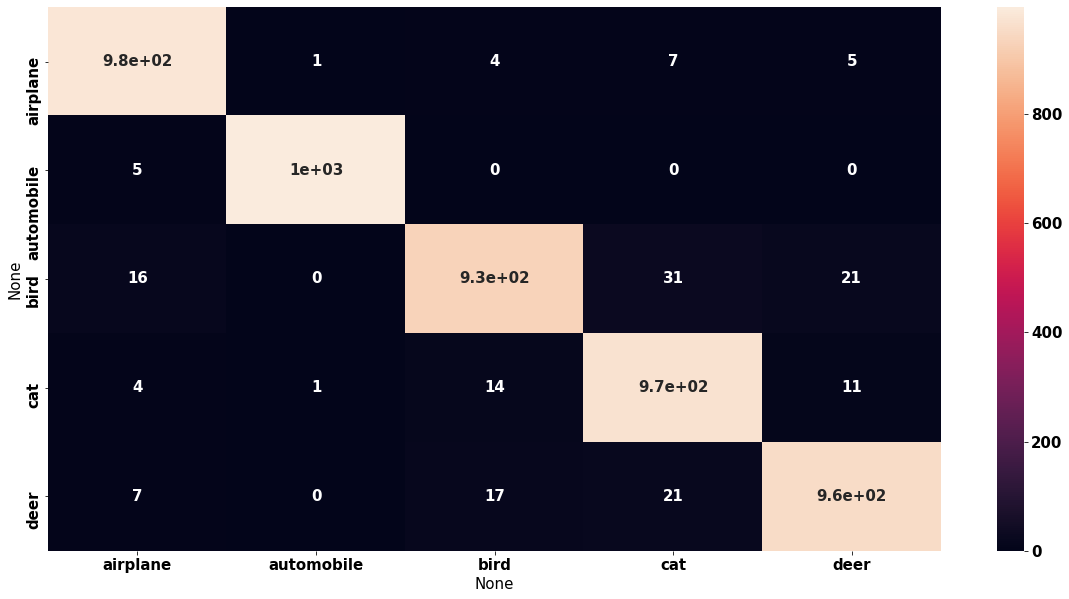

In [11]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf = tf.math.confusion_matrix(groundTruth,np.argmax(pred, axis = 1))
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)
labels_names = ['airplane','automobile','bird','cat','deer'],
#'dog','frog','horse','ship',
#                'truck']
df_cm = pd.DataFrame(np.array(conf), index = [i for i in labels_names],
                  columns = [i for i in labels_names])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig("saveed_figures/en_ran/conf_Cifar old Classes.png")
plt.savefig("saveed_figures/en_ran/conf_Cifar old Classes.pdf")

<ipython-input-12-b1e6b5ced044>:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


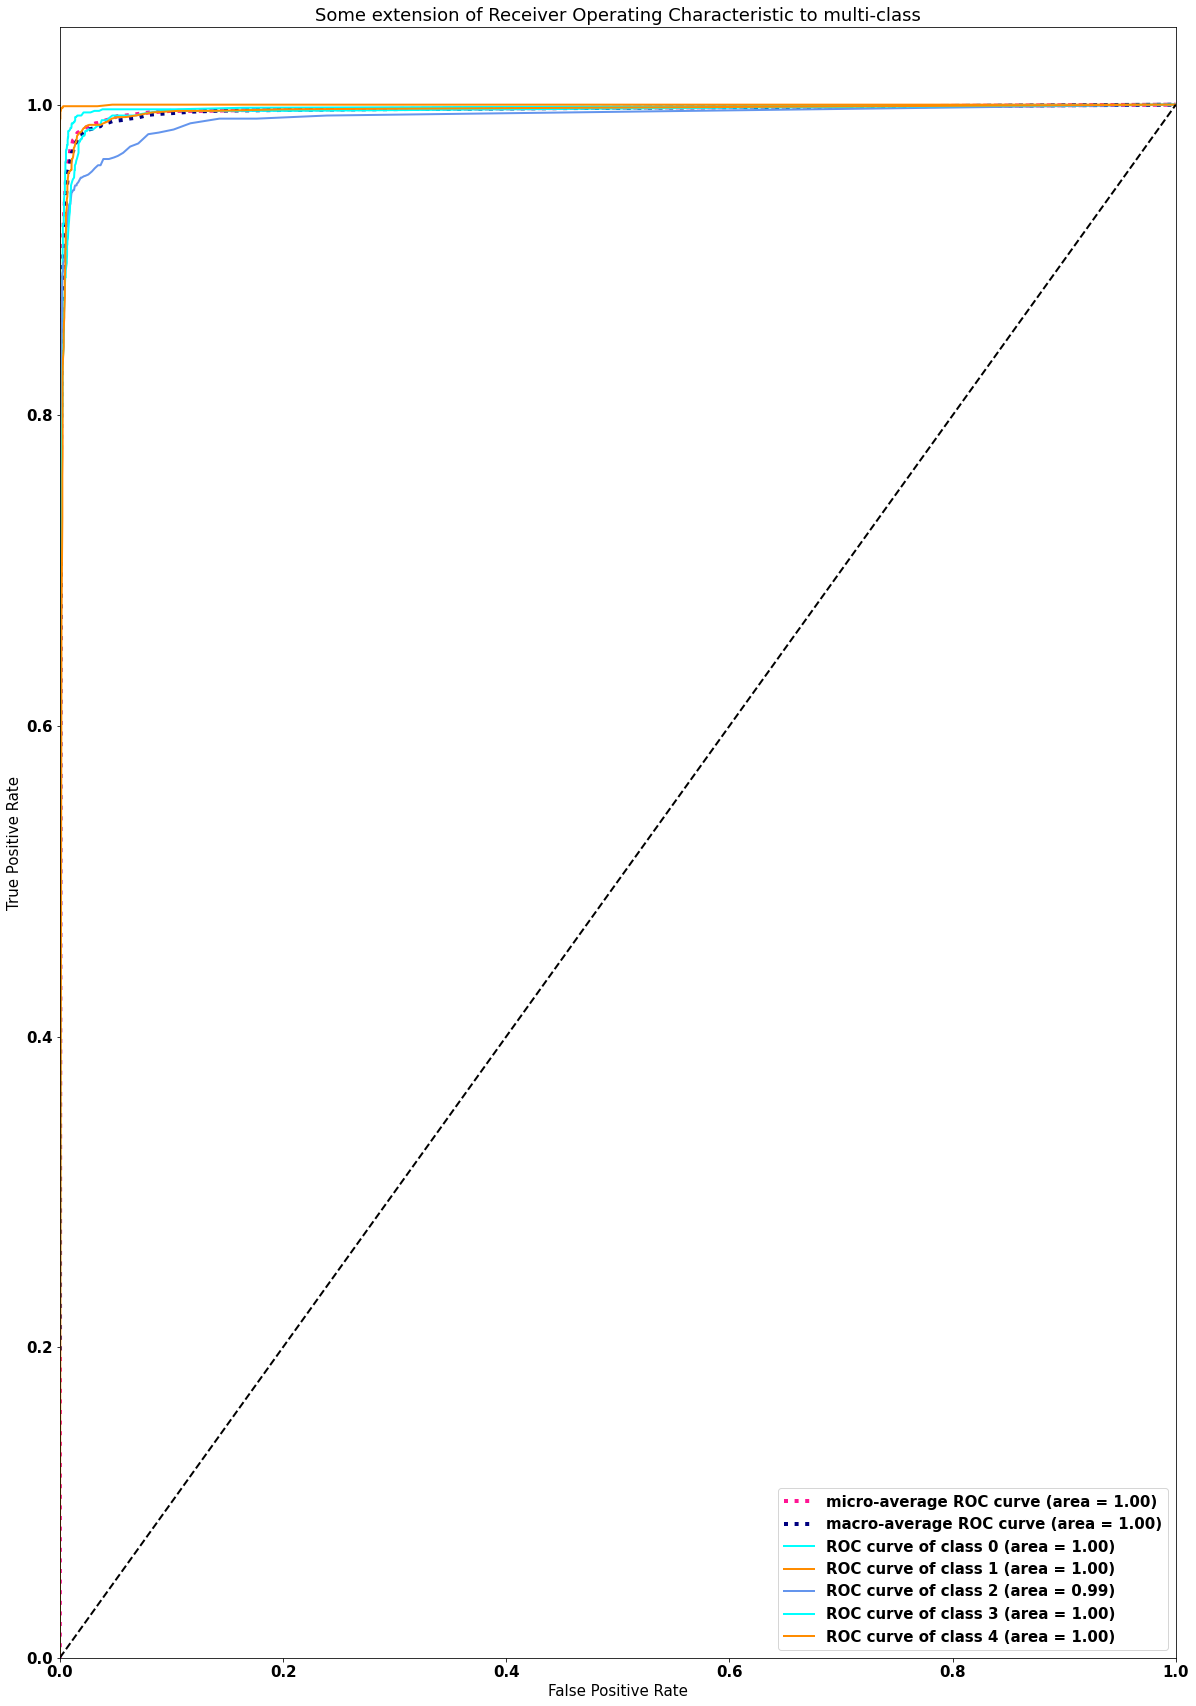

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(tf.keras.utils.to_categorical(groundTruth))
y_score = np.copy(pred)
n_classes =  5
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig("saveed_figures/en_ran/roc_Cifar old Classes.png")
plt.savefig("saveed_figures/en_ran/roc_Cifar old Classes.pdf")
plt.show()

In [13]:
%matplotlib inline
def plot_class_predictions(preds,idx):
    classes =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship',
               'truck']
    print("Class #{}".format(idx))
    c, f = np.unique(preds, return_counts = True)
    fig = plt.figure( figsize = (30,20))
    font = {'family' : 'sans',
            'weight' : 'bold',
            'size'   : 40}
    matplotlib.rc('font', **font)
    ax = fig.add_axes([0,0,1,1 ])
    ax.set_title("{} Predictions".format(classes[idx]))
    ax.set_xlabel("Clases")
    ax.set_ylabel("Frequecy Of Predictions")
    ax.set_xticks(c)
    ax.bar(c,f)

Class #0


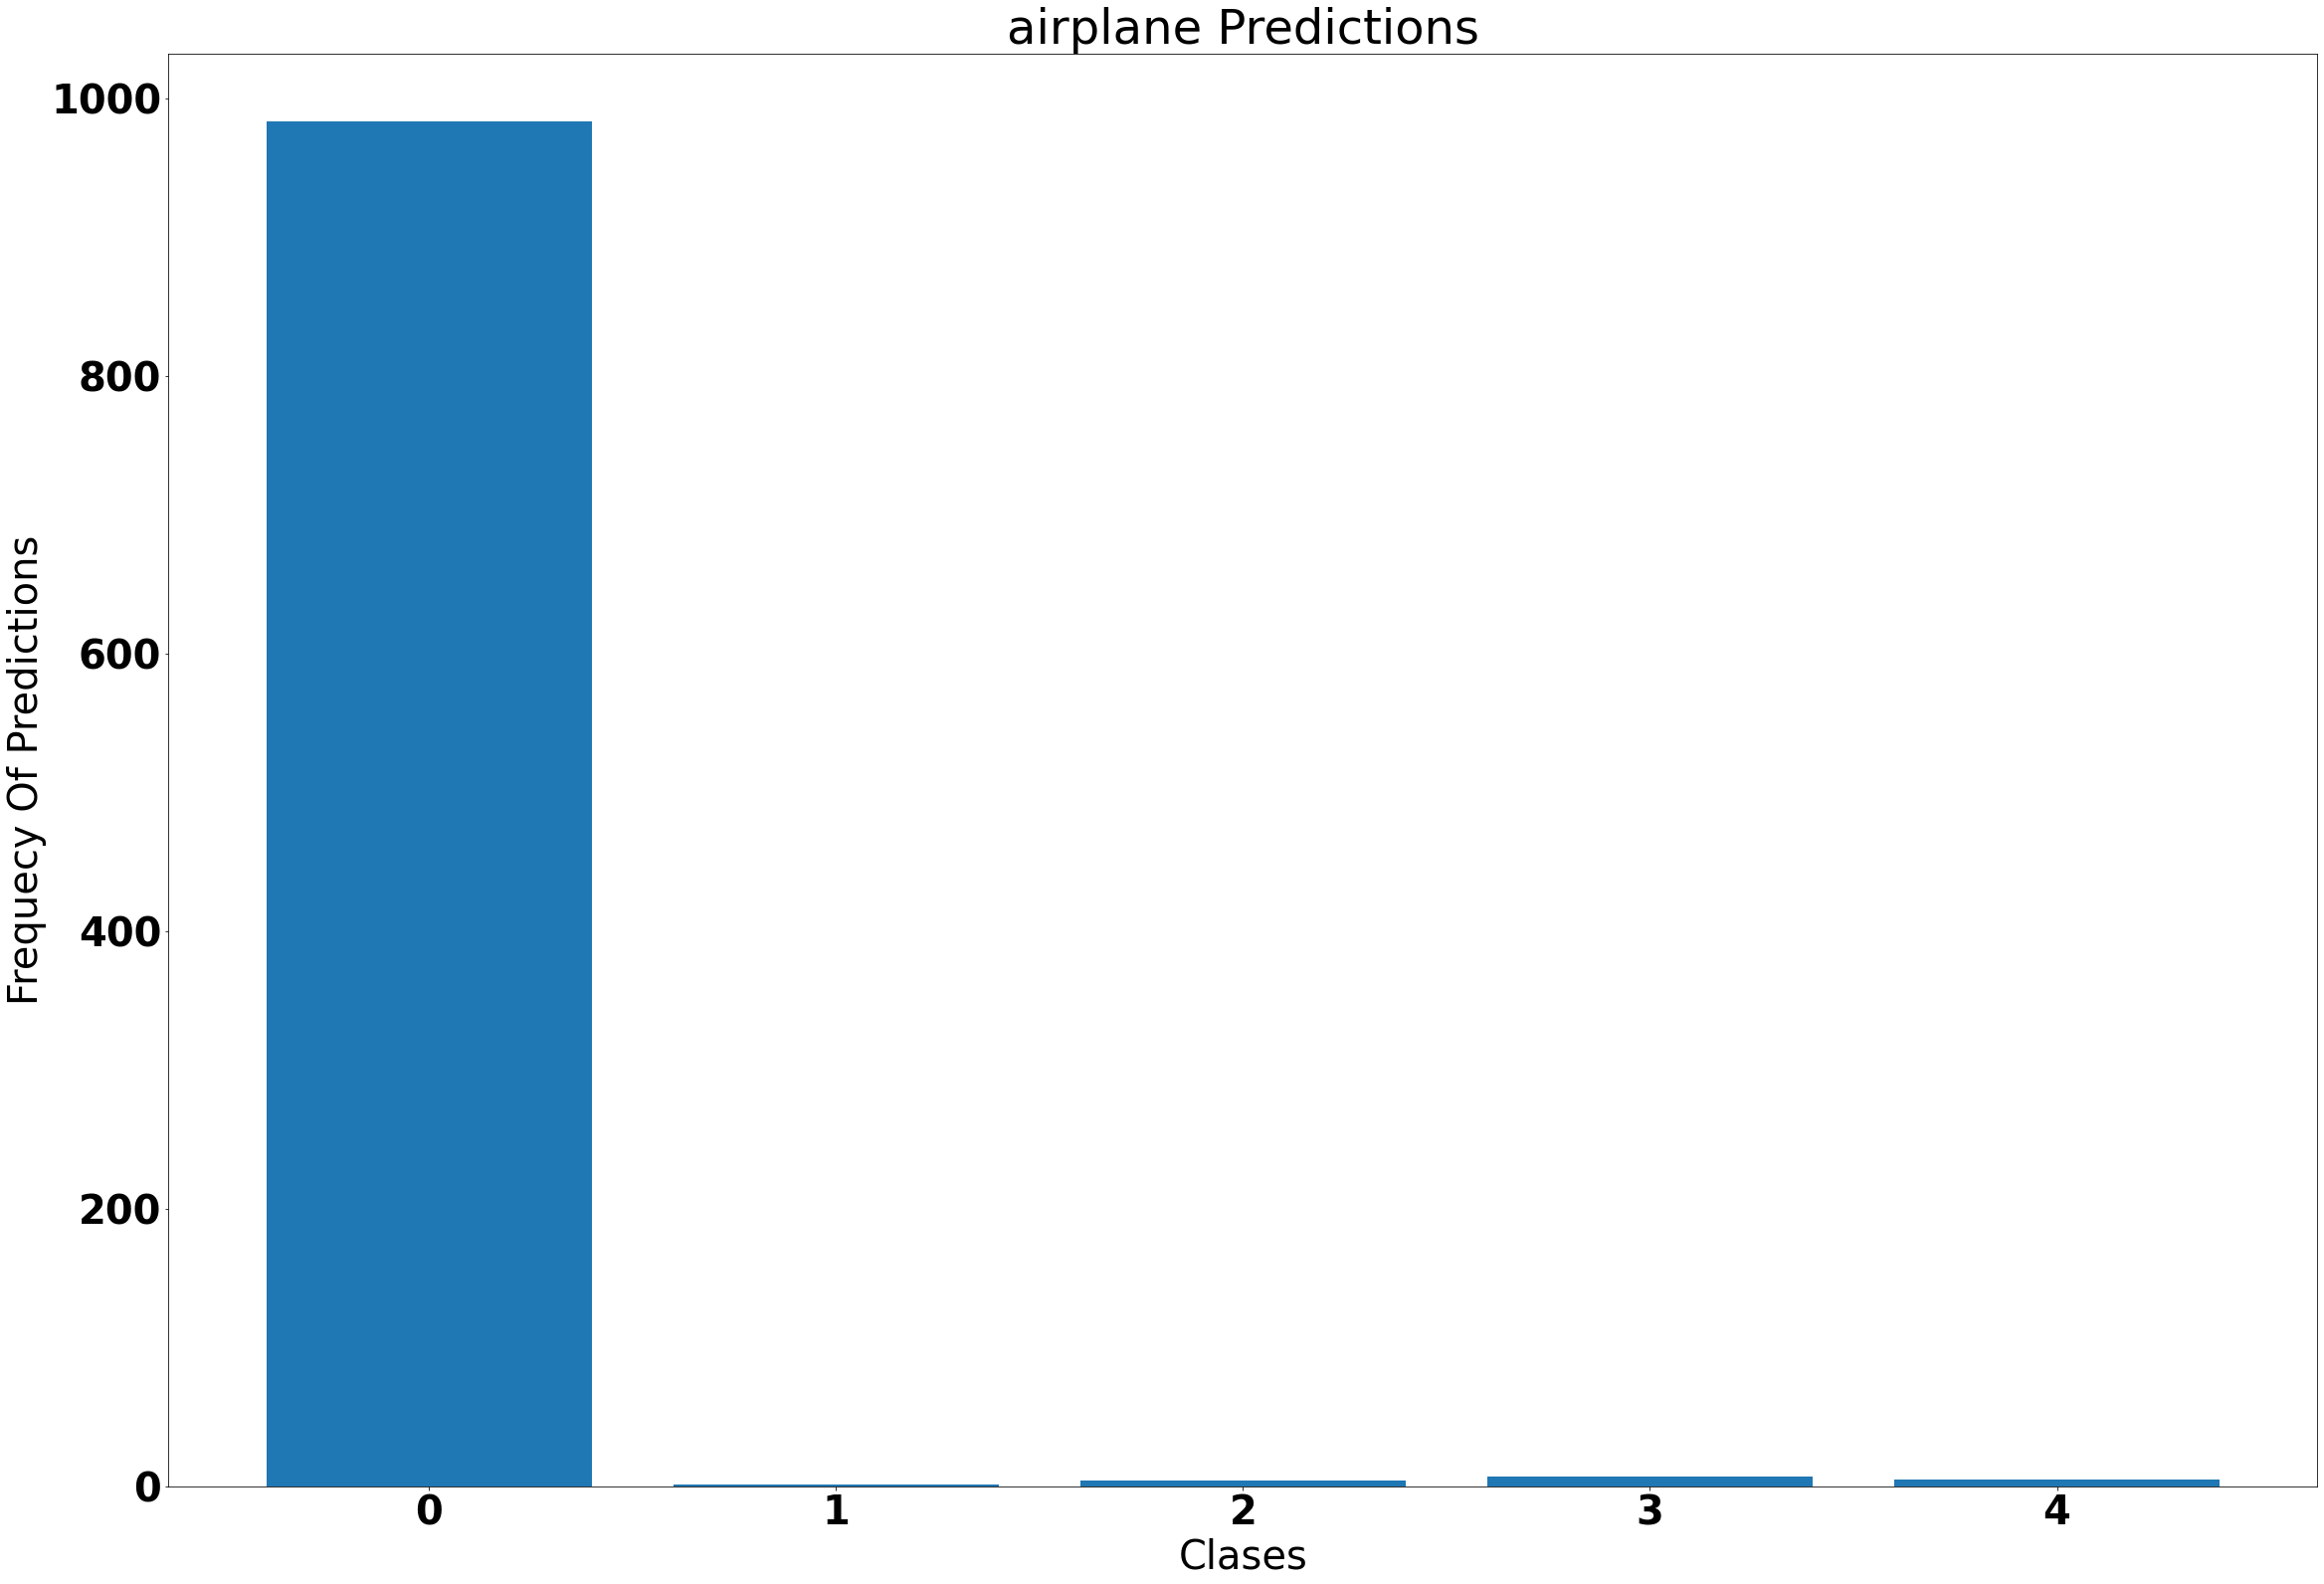

In [14]:
idx = 0
c = returnClassIndex(testY,idx)
preds = ran1.predict(test_feat1[c])
plot_class_predictions(preds, idx)

Class #1


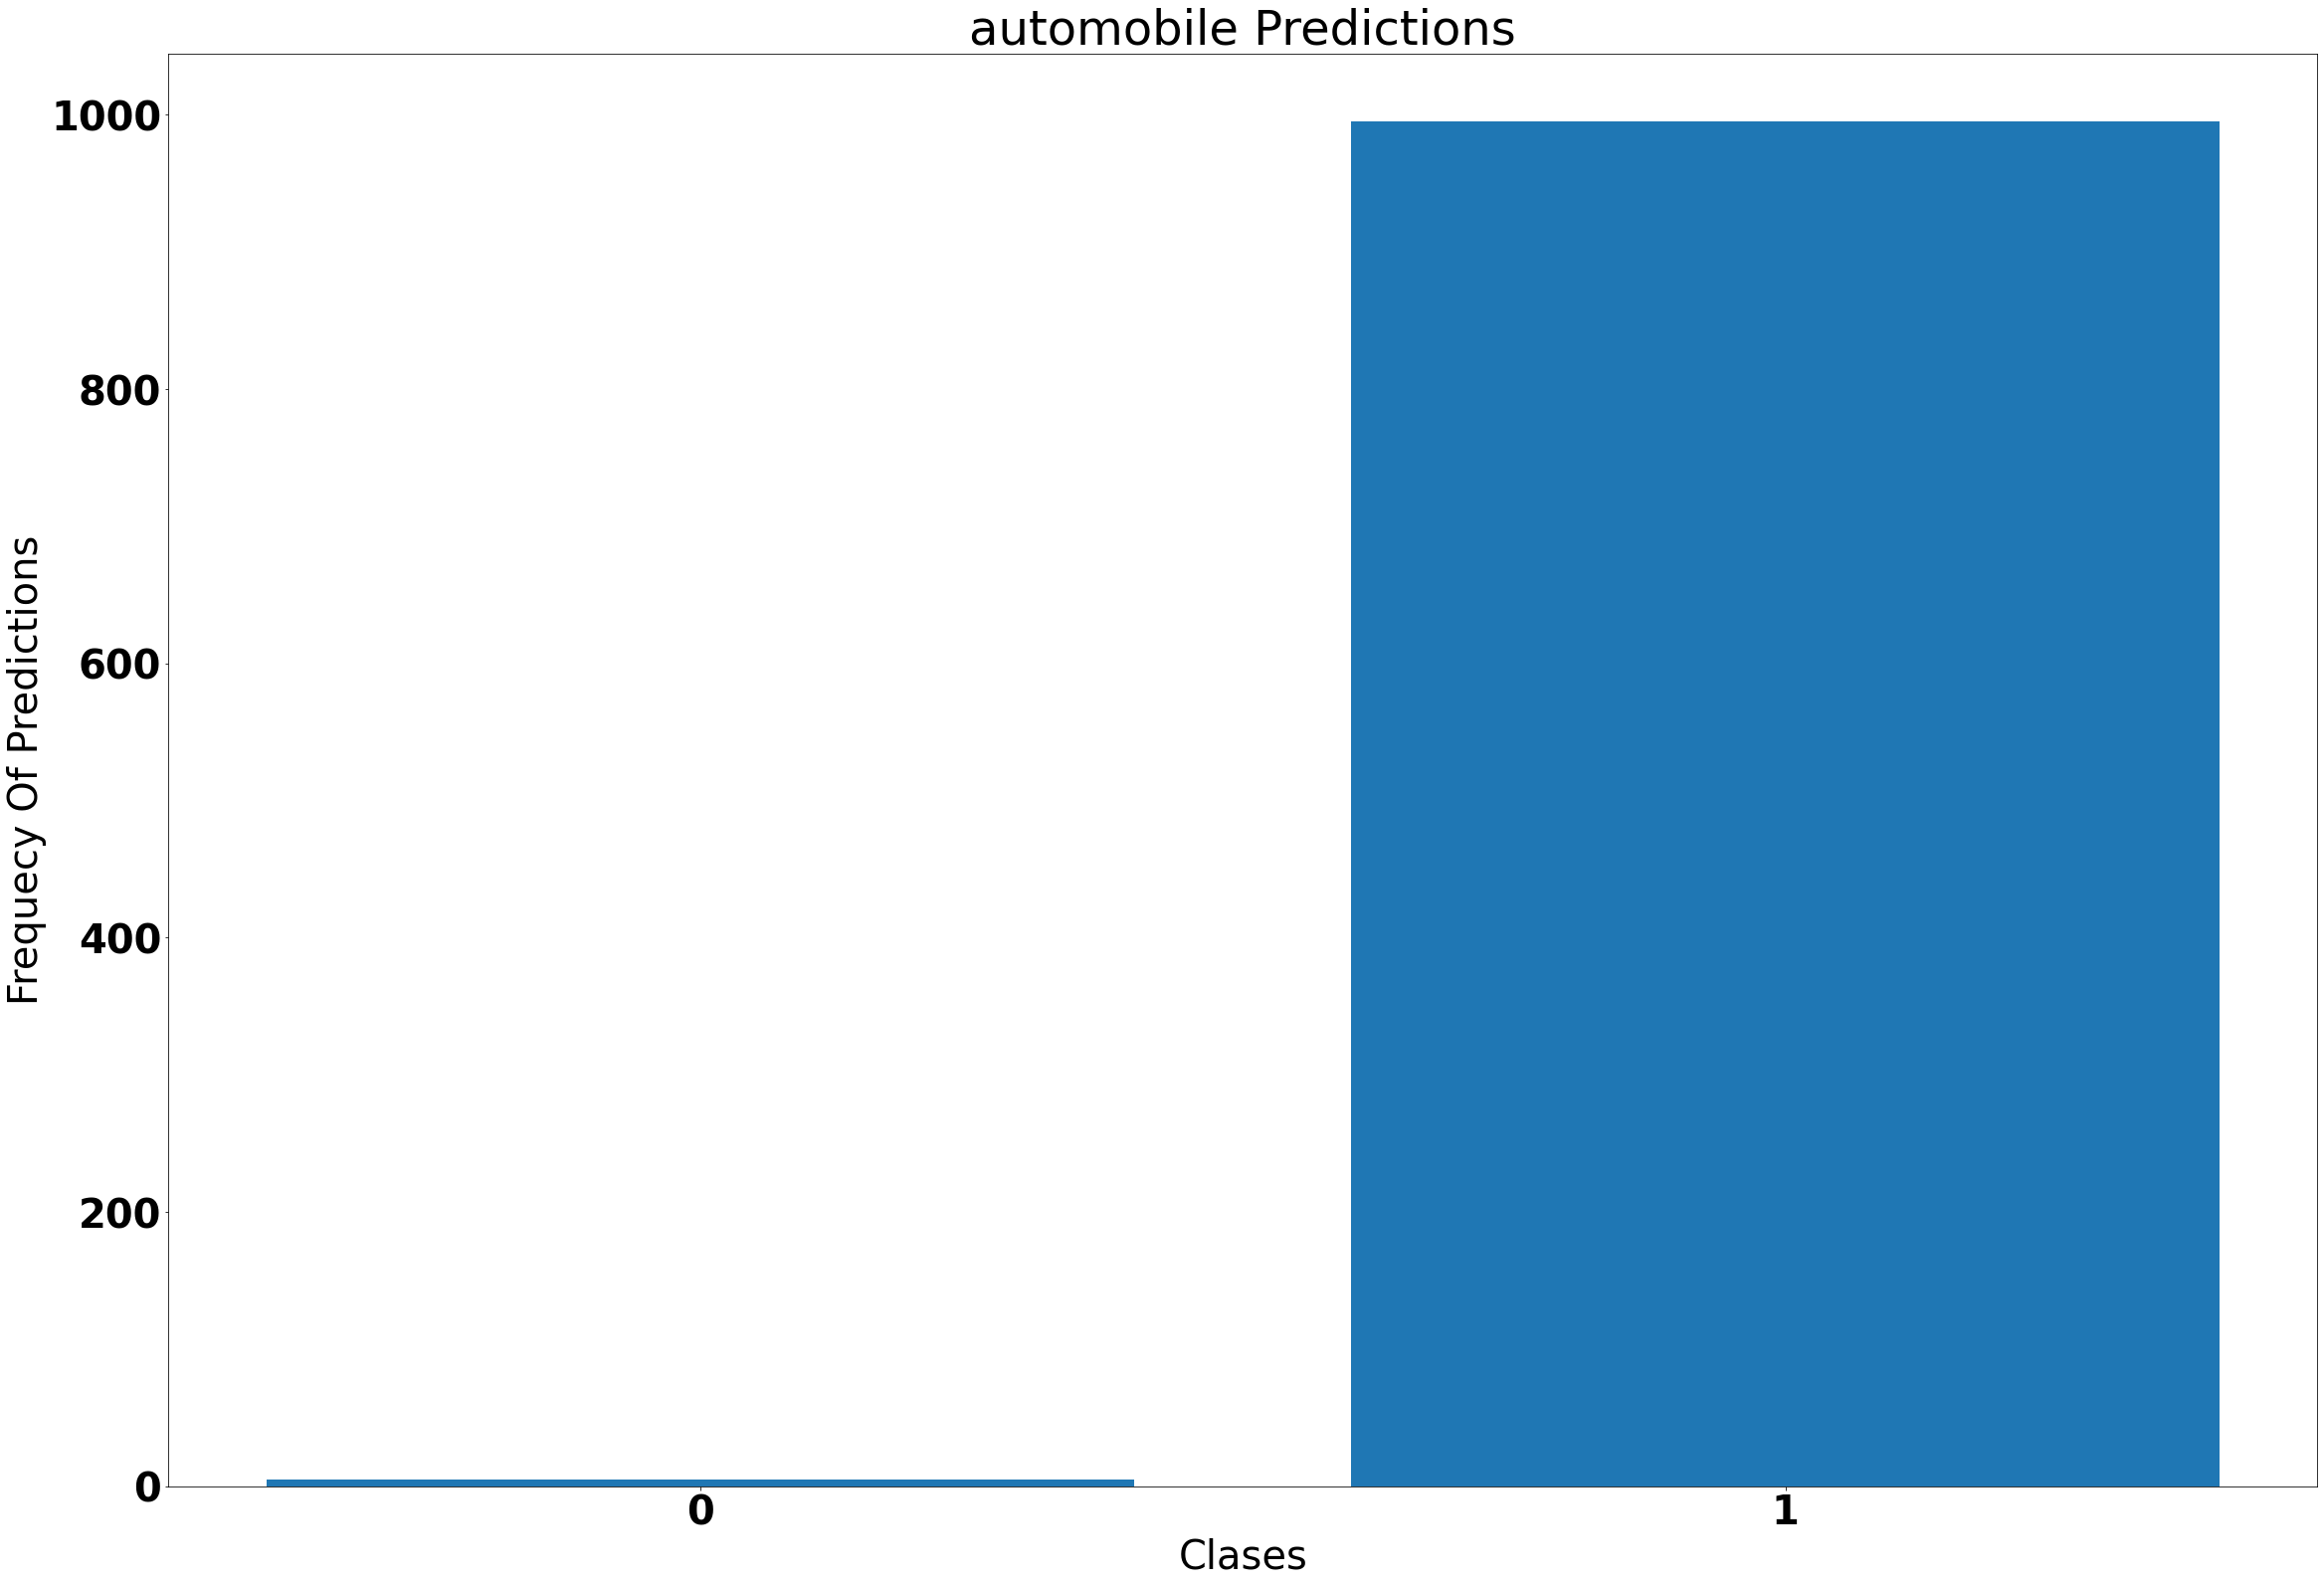

In [15]:
idx = 1
c = returnClassIndex(testY,idx)
preds = ran1.predict(test_feat1[c])
plot_class_predictions(preds, idx)

Class #2


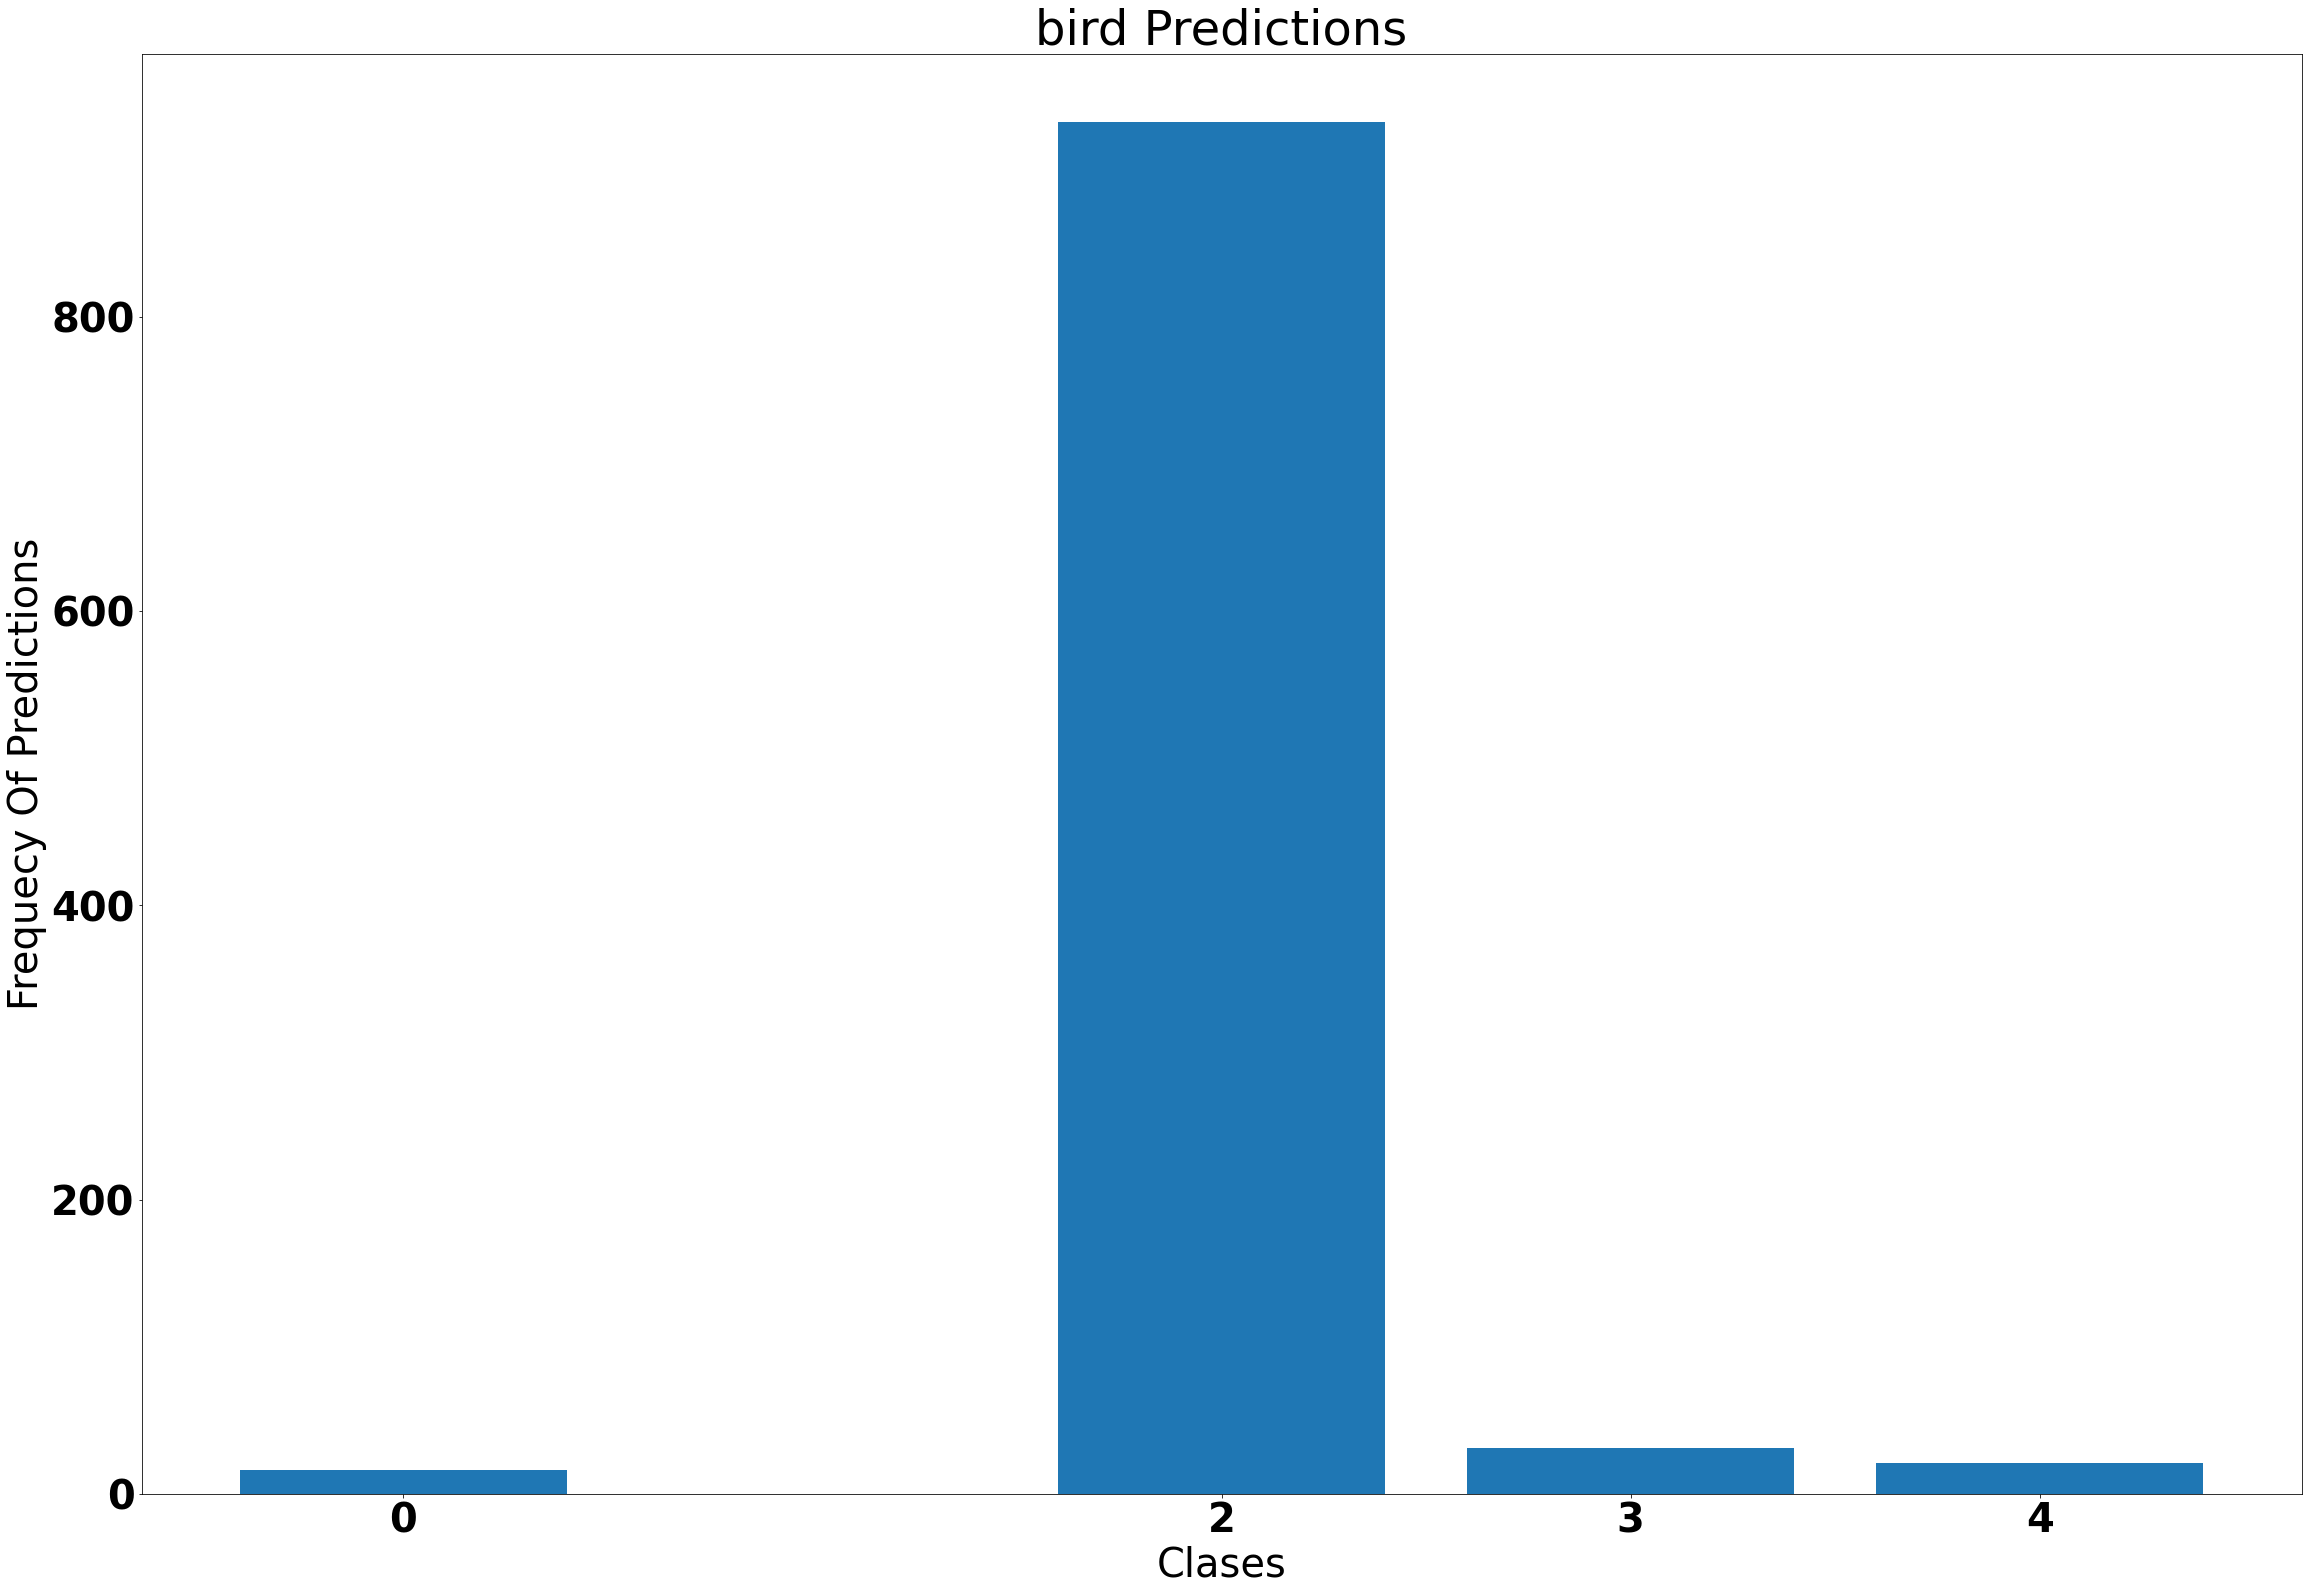

In [16]:
idx = 2
c = returnClassIndex(testY,idx)
preds = ran1.predict(test_feat1[c])
plot_class_predictions(preds, idx)

Class #3


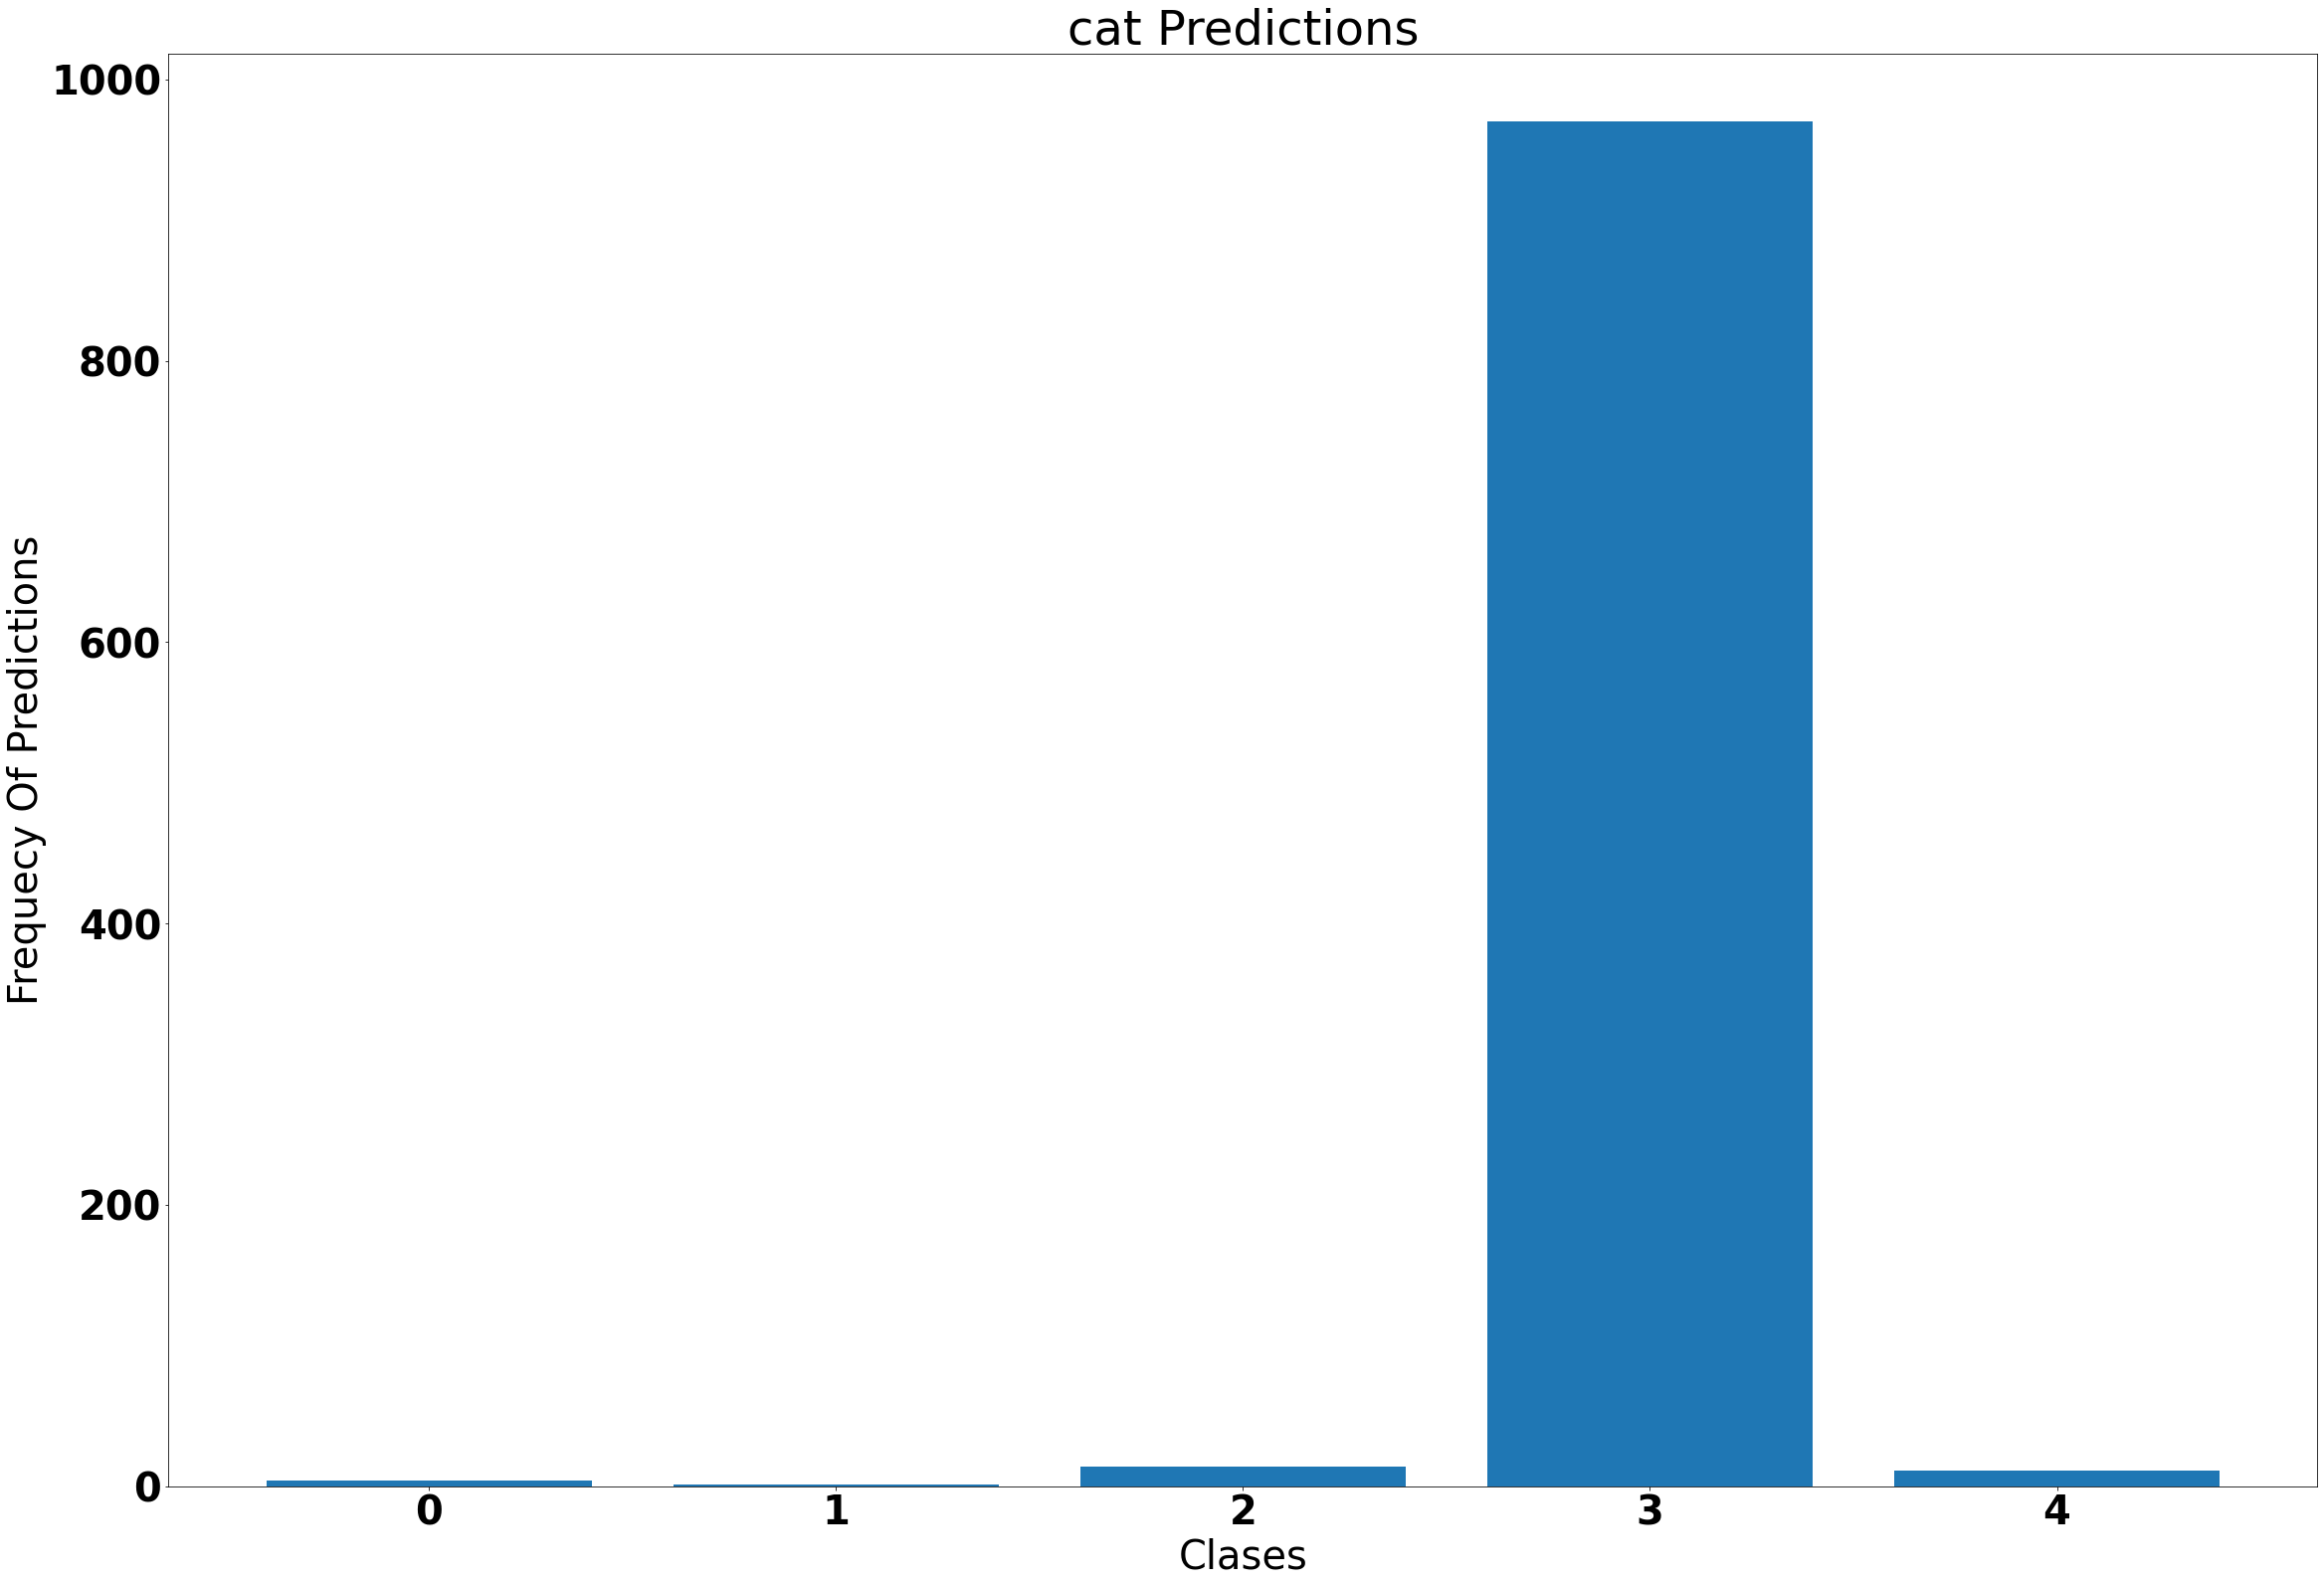

In [17]:
idx = 3
c = returnClassIndex(testY,idx)
preds = ran1.predict(test_feat1[c])
plot_class_predictions(preds, idx)

Class #4


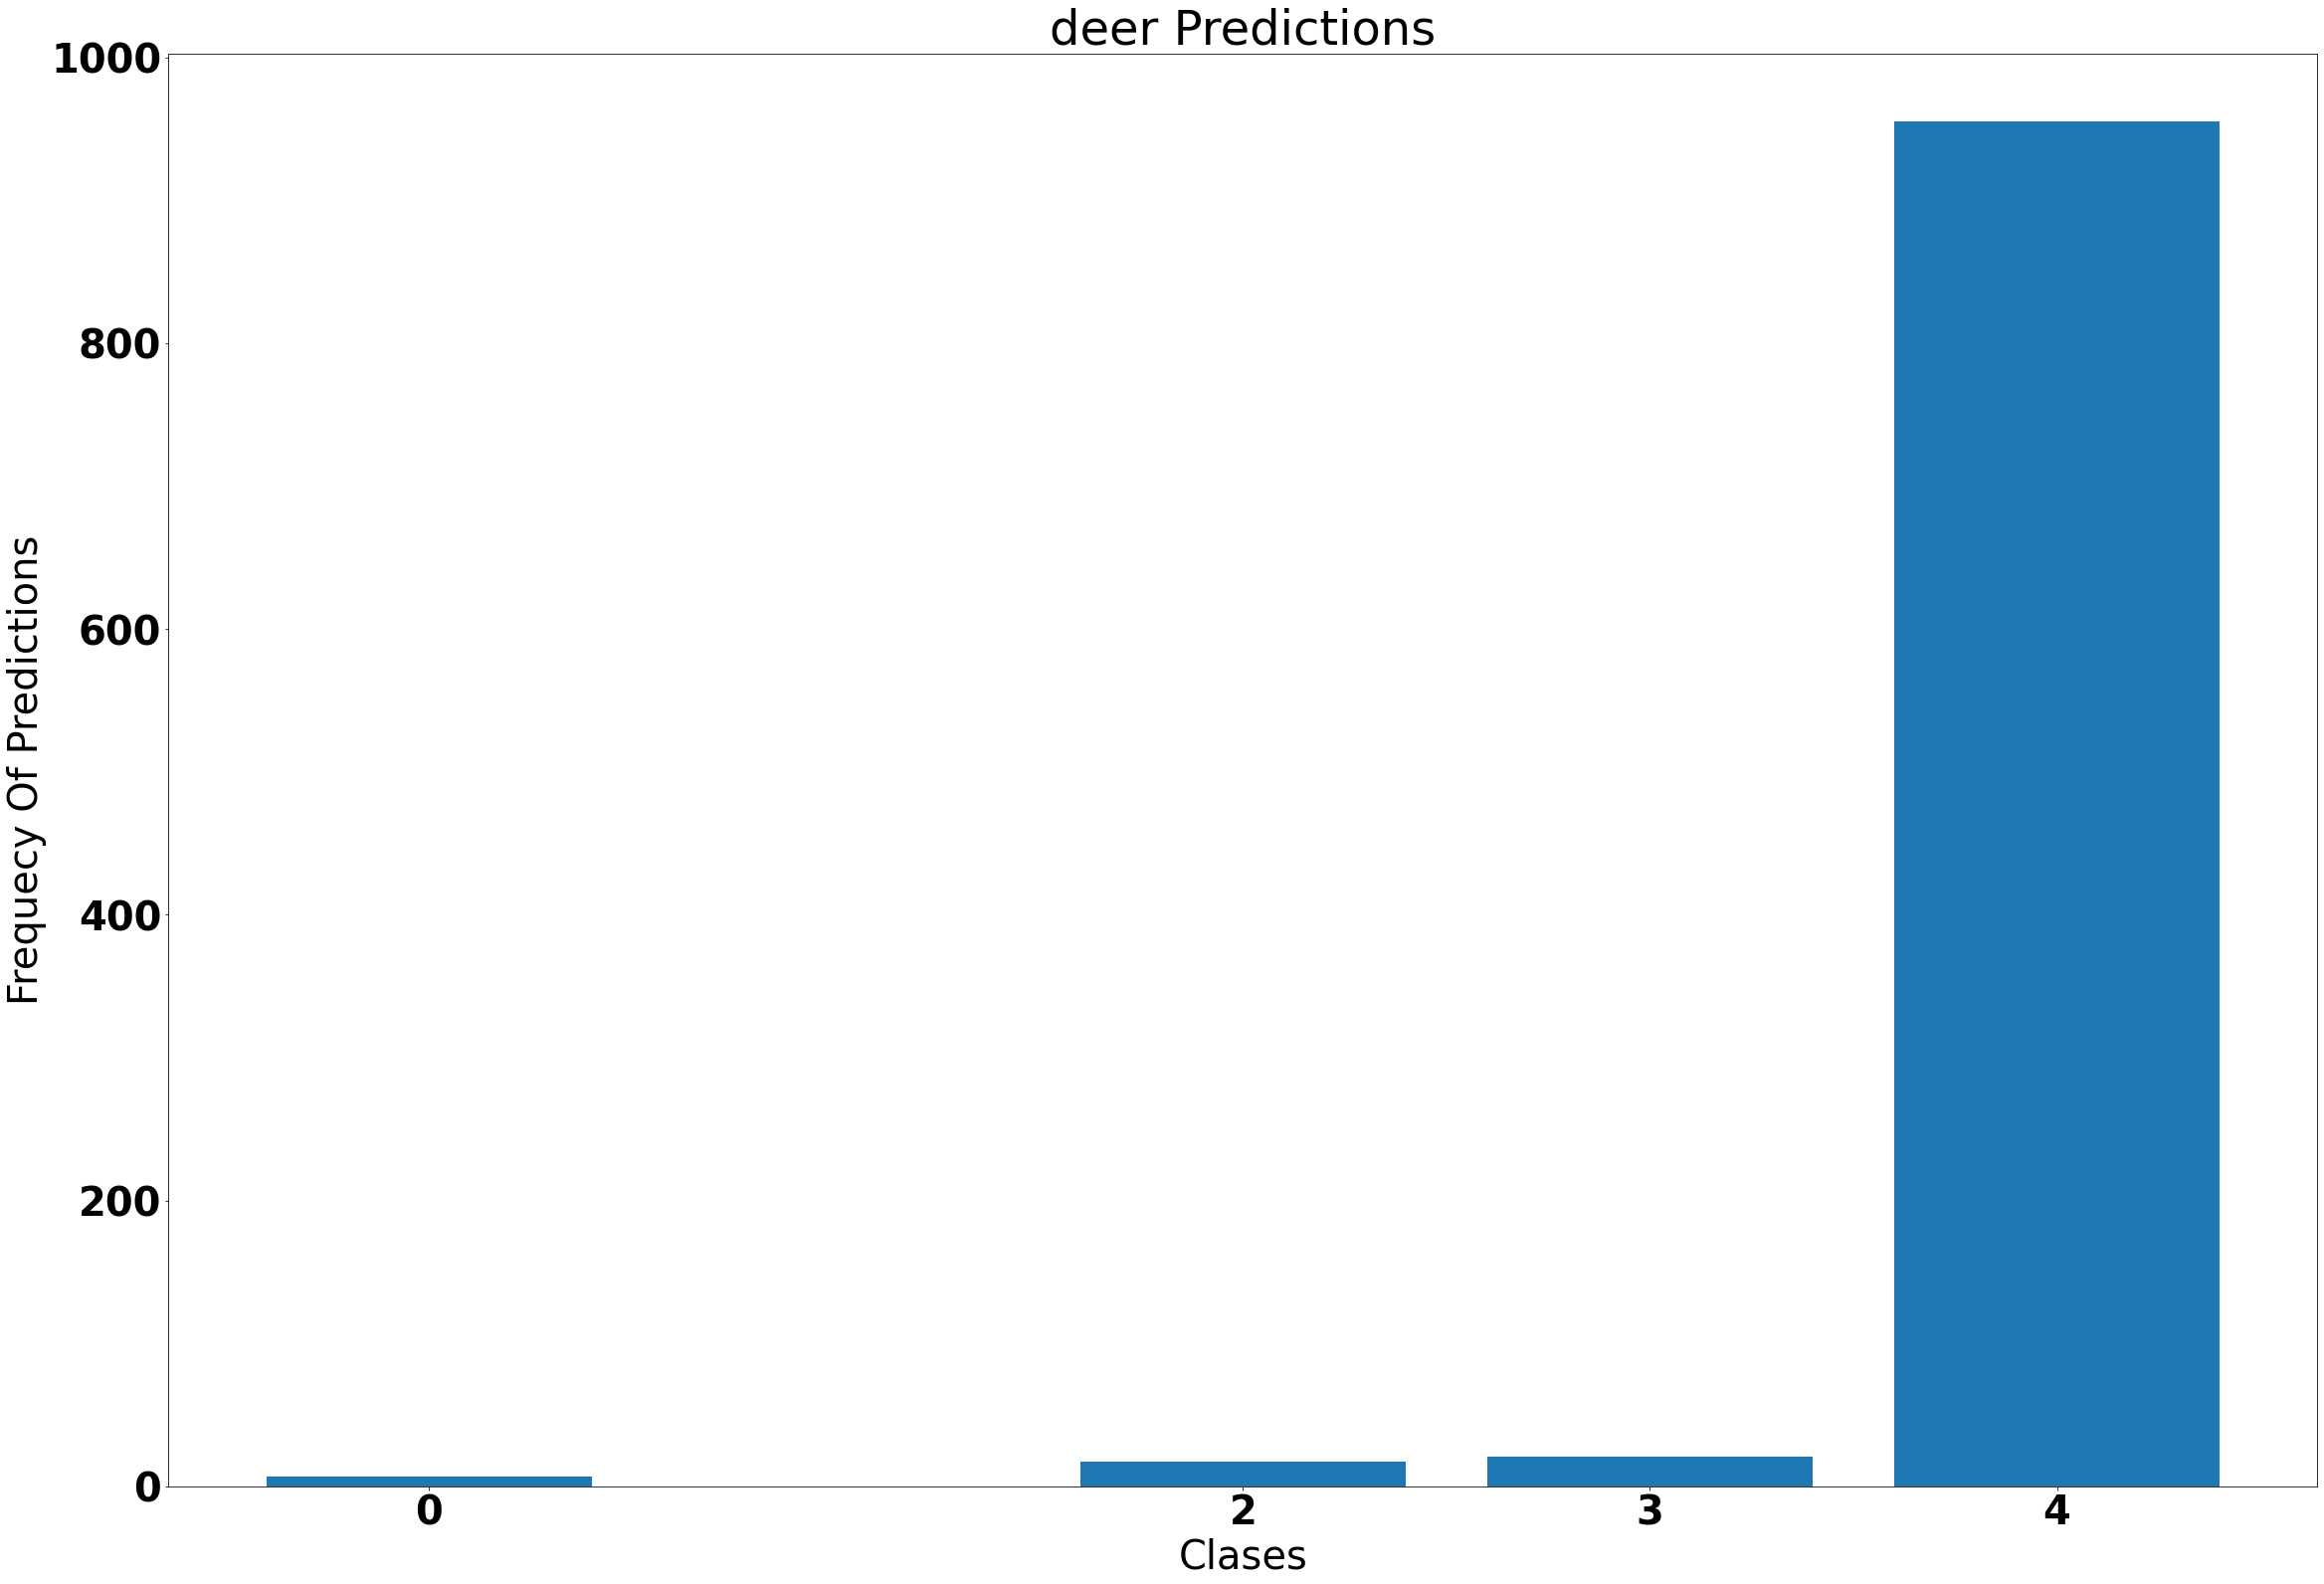

In [18]:
idx = 4
c = returnClassIndex(testY,idx)
preds = ran1.predict(test_feat1[c])
plot_class_predictions(preds, idx)

Class #5


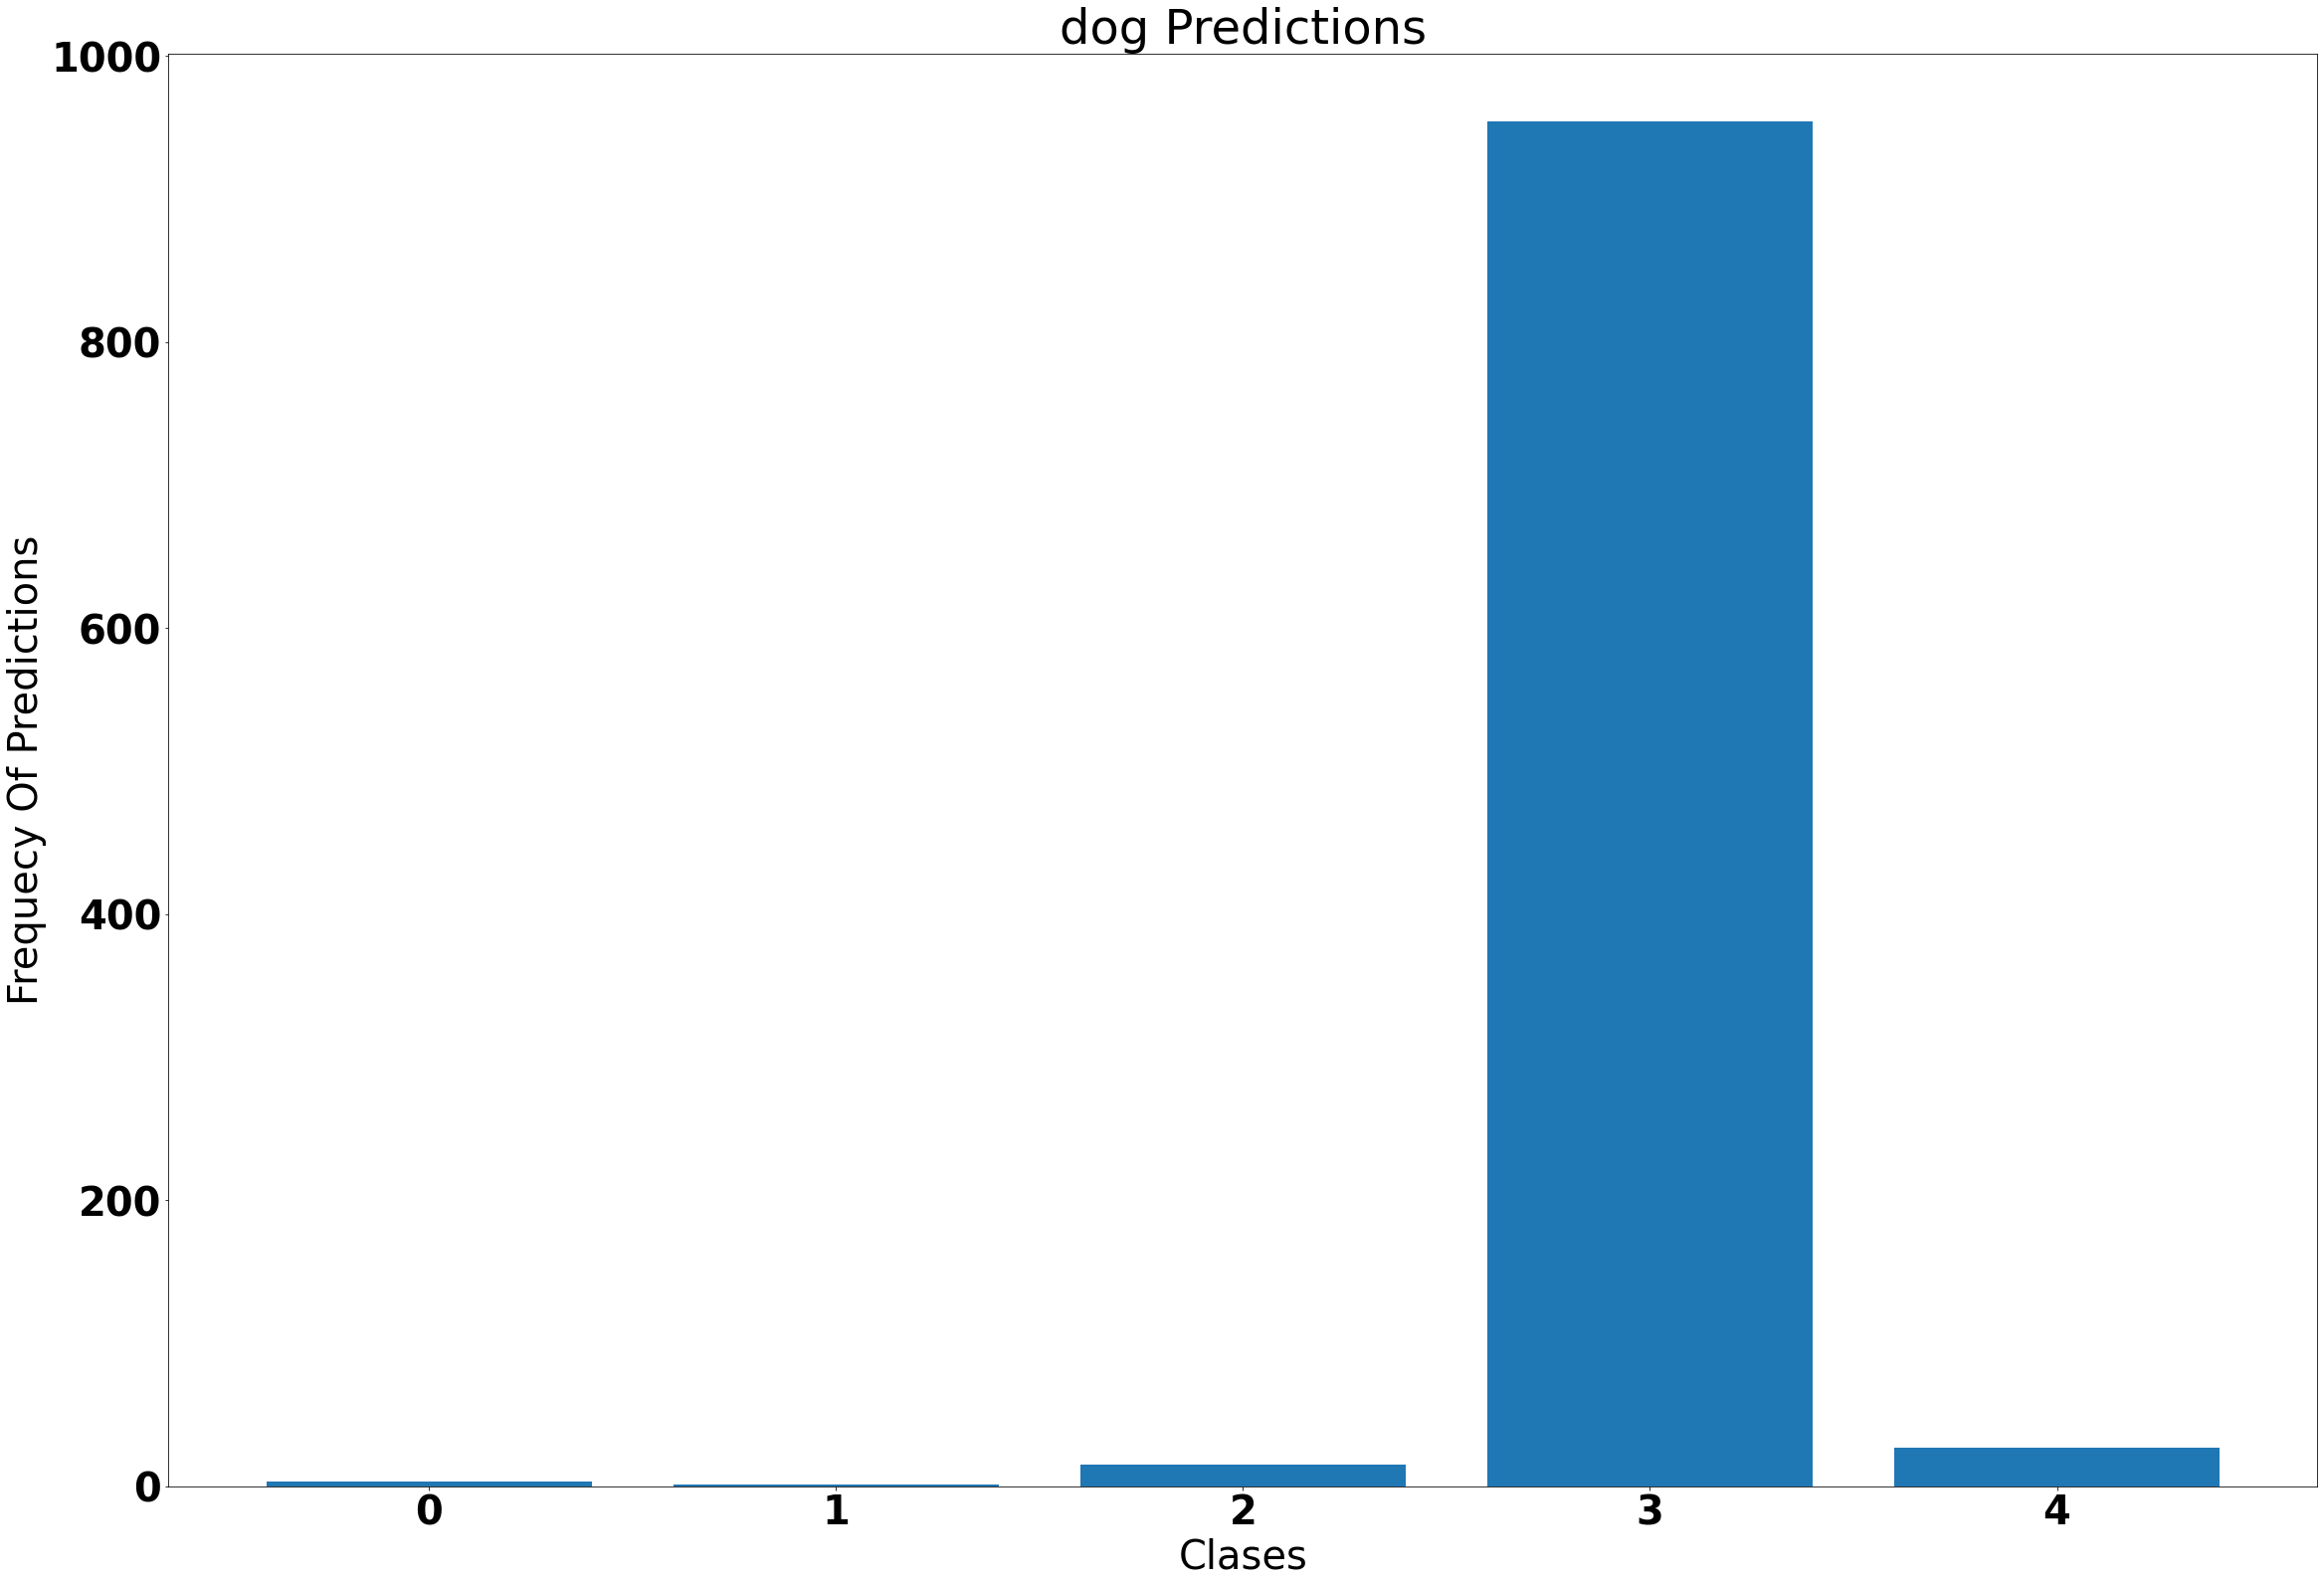

In [19]:
idx = 5
c = returnClassIndex(testY,idx)
preds = ran1.predict(test_feat1[c])
plot_class_predictions(preds, idx)

Class #6


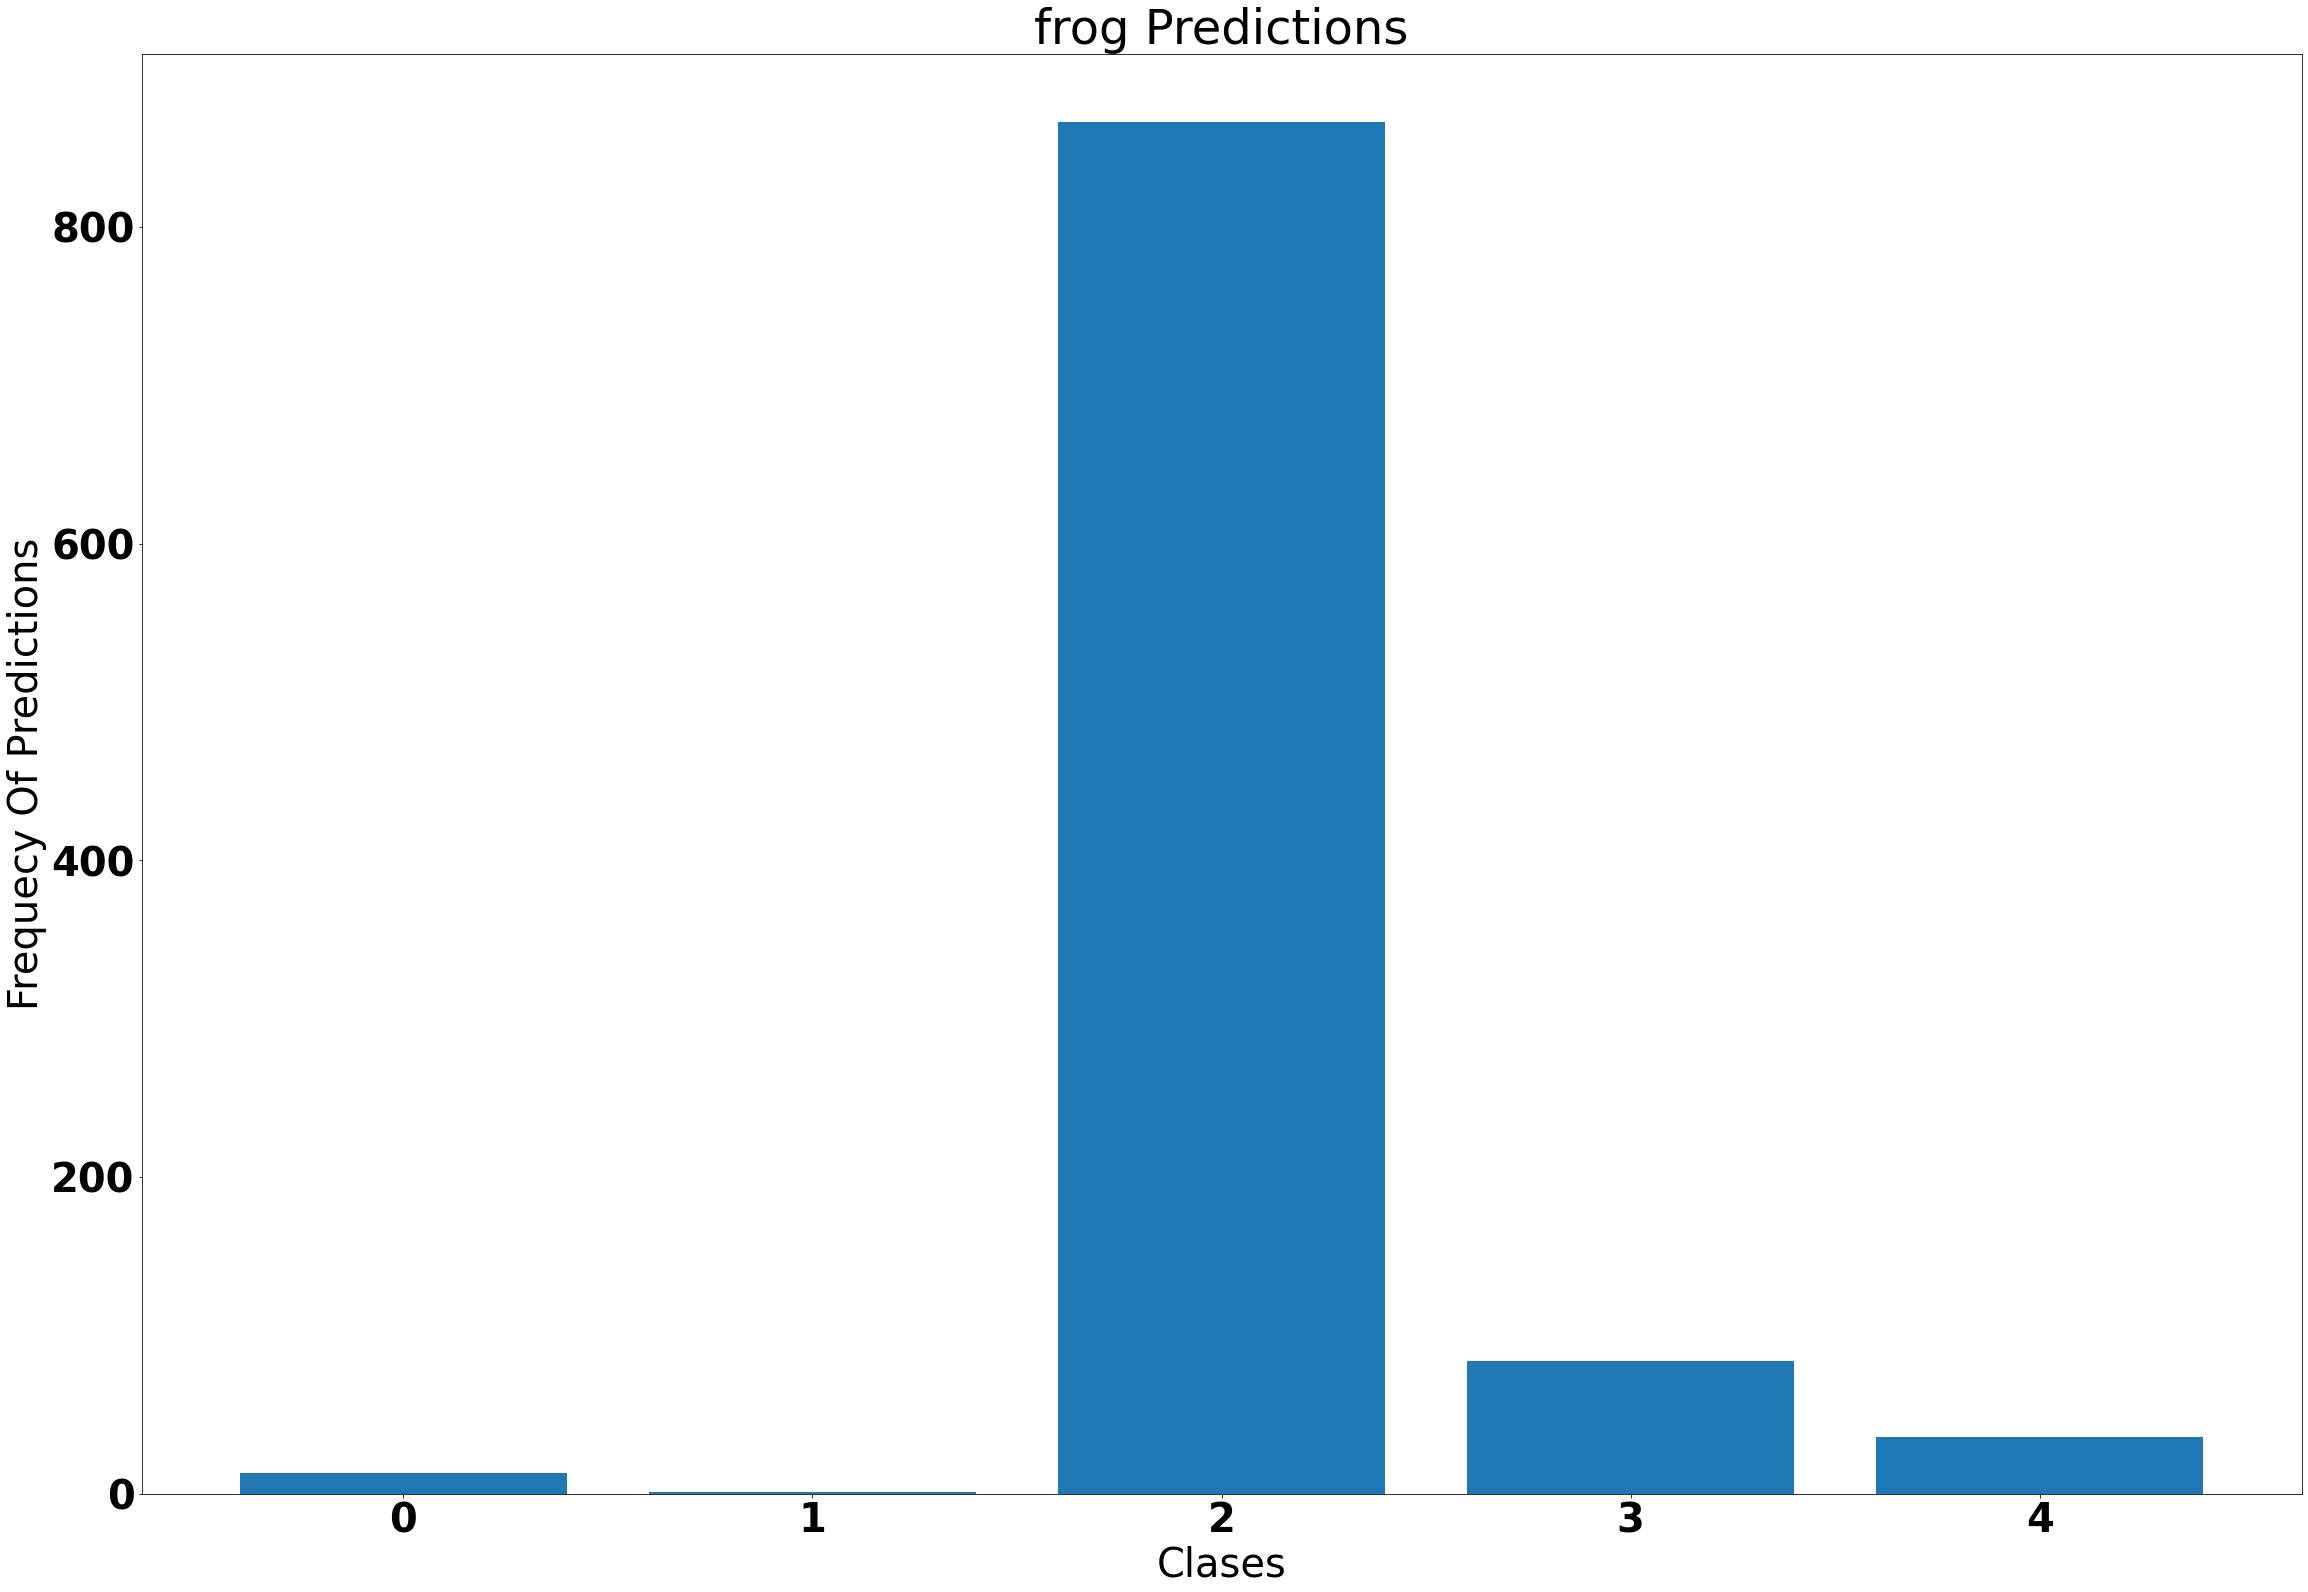

In [20]:
idx = 6
c = returnClassIndex(testY,idx)
preds = ran1.predict(test_feat1[c])
plot_class_predictions(preds, idx)

Class #7


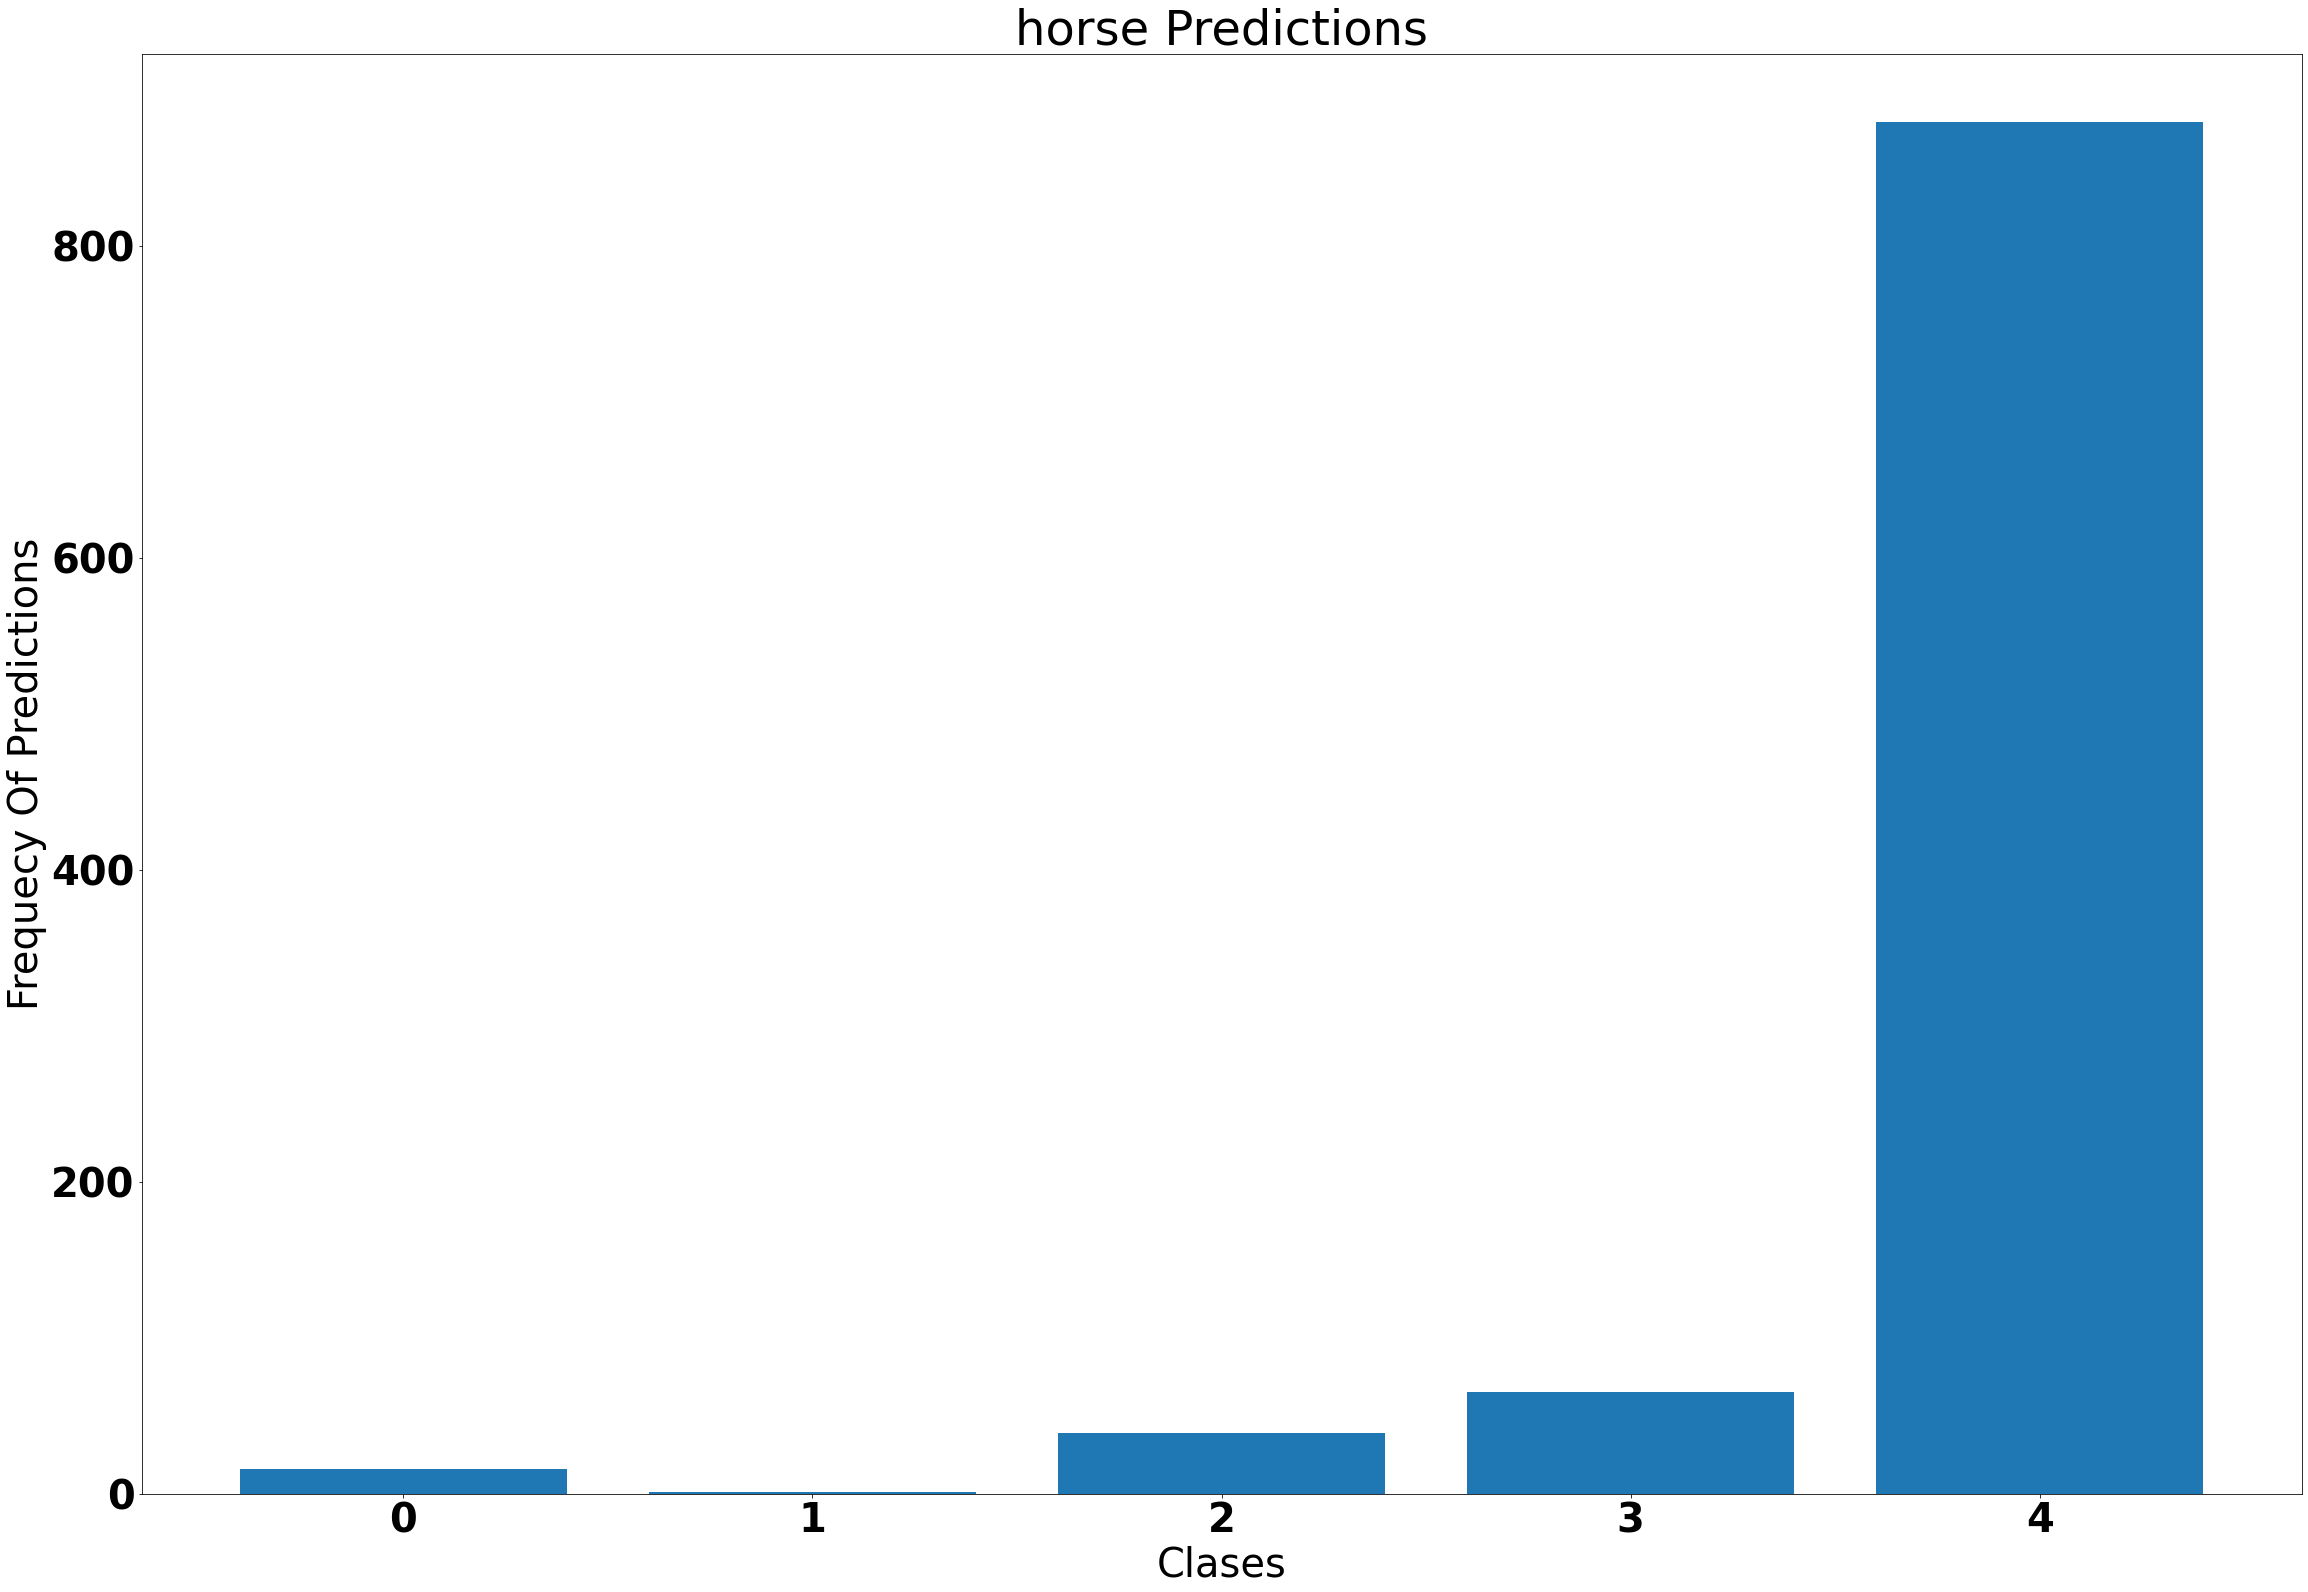

In [21]:
idx = 7
c = returnClassIndex(testY,idx)
preds = ran1.predict(test_feat1[c])
plot_class_predictions(preds, idx)

Class #8


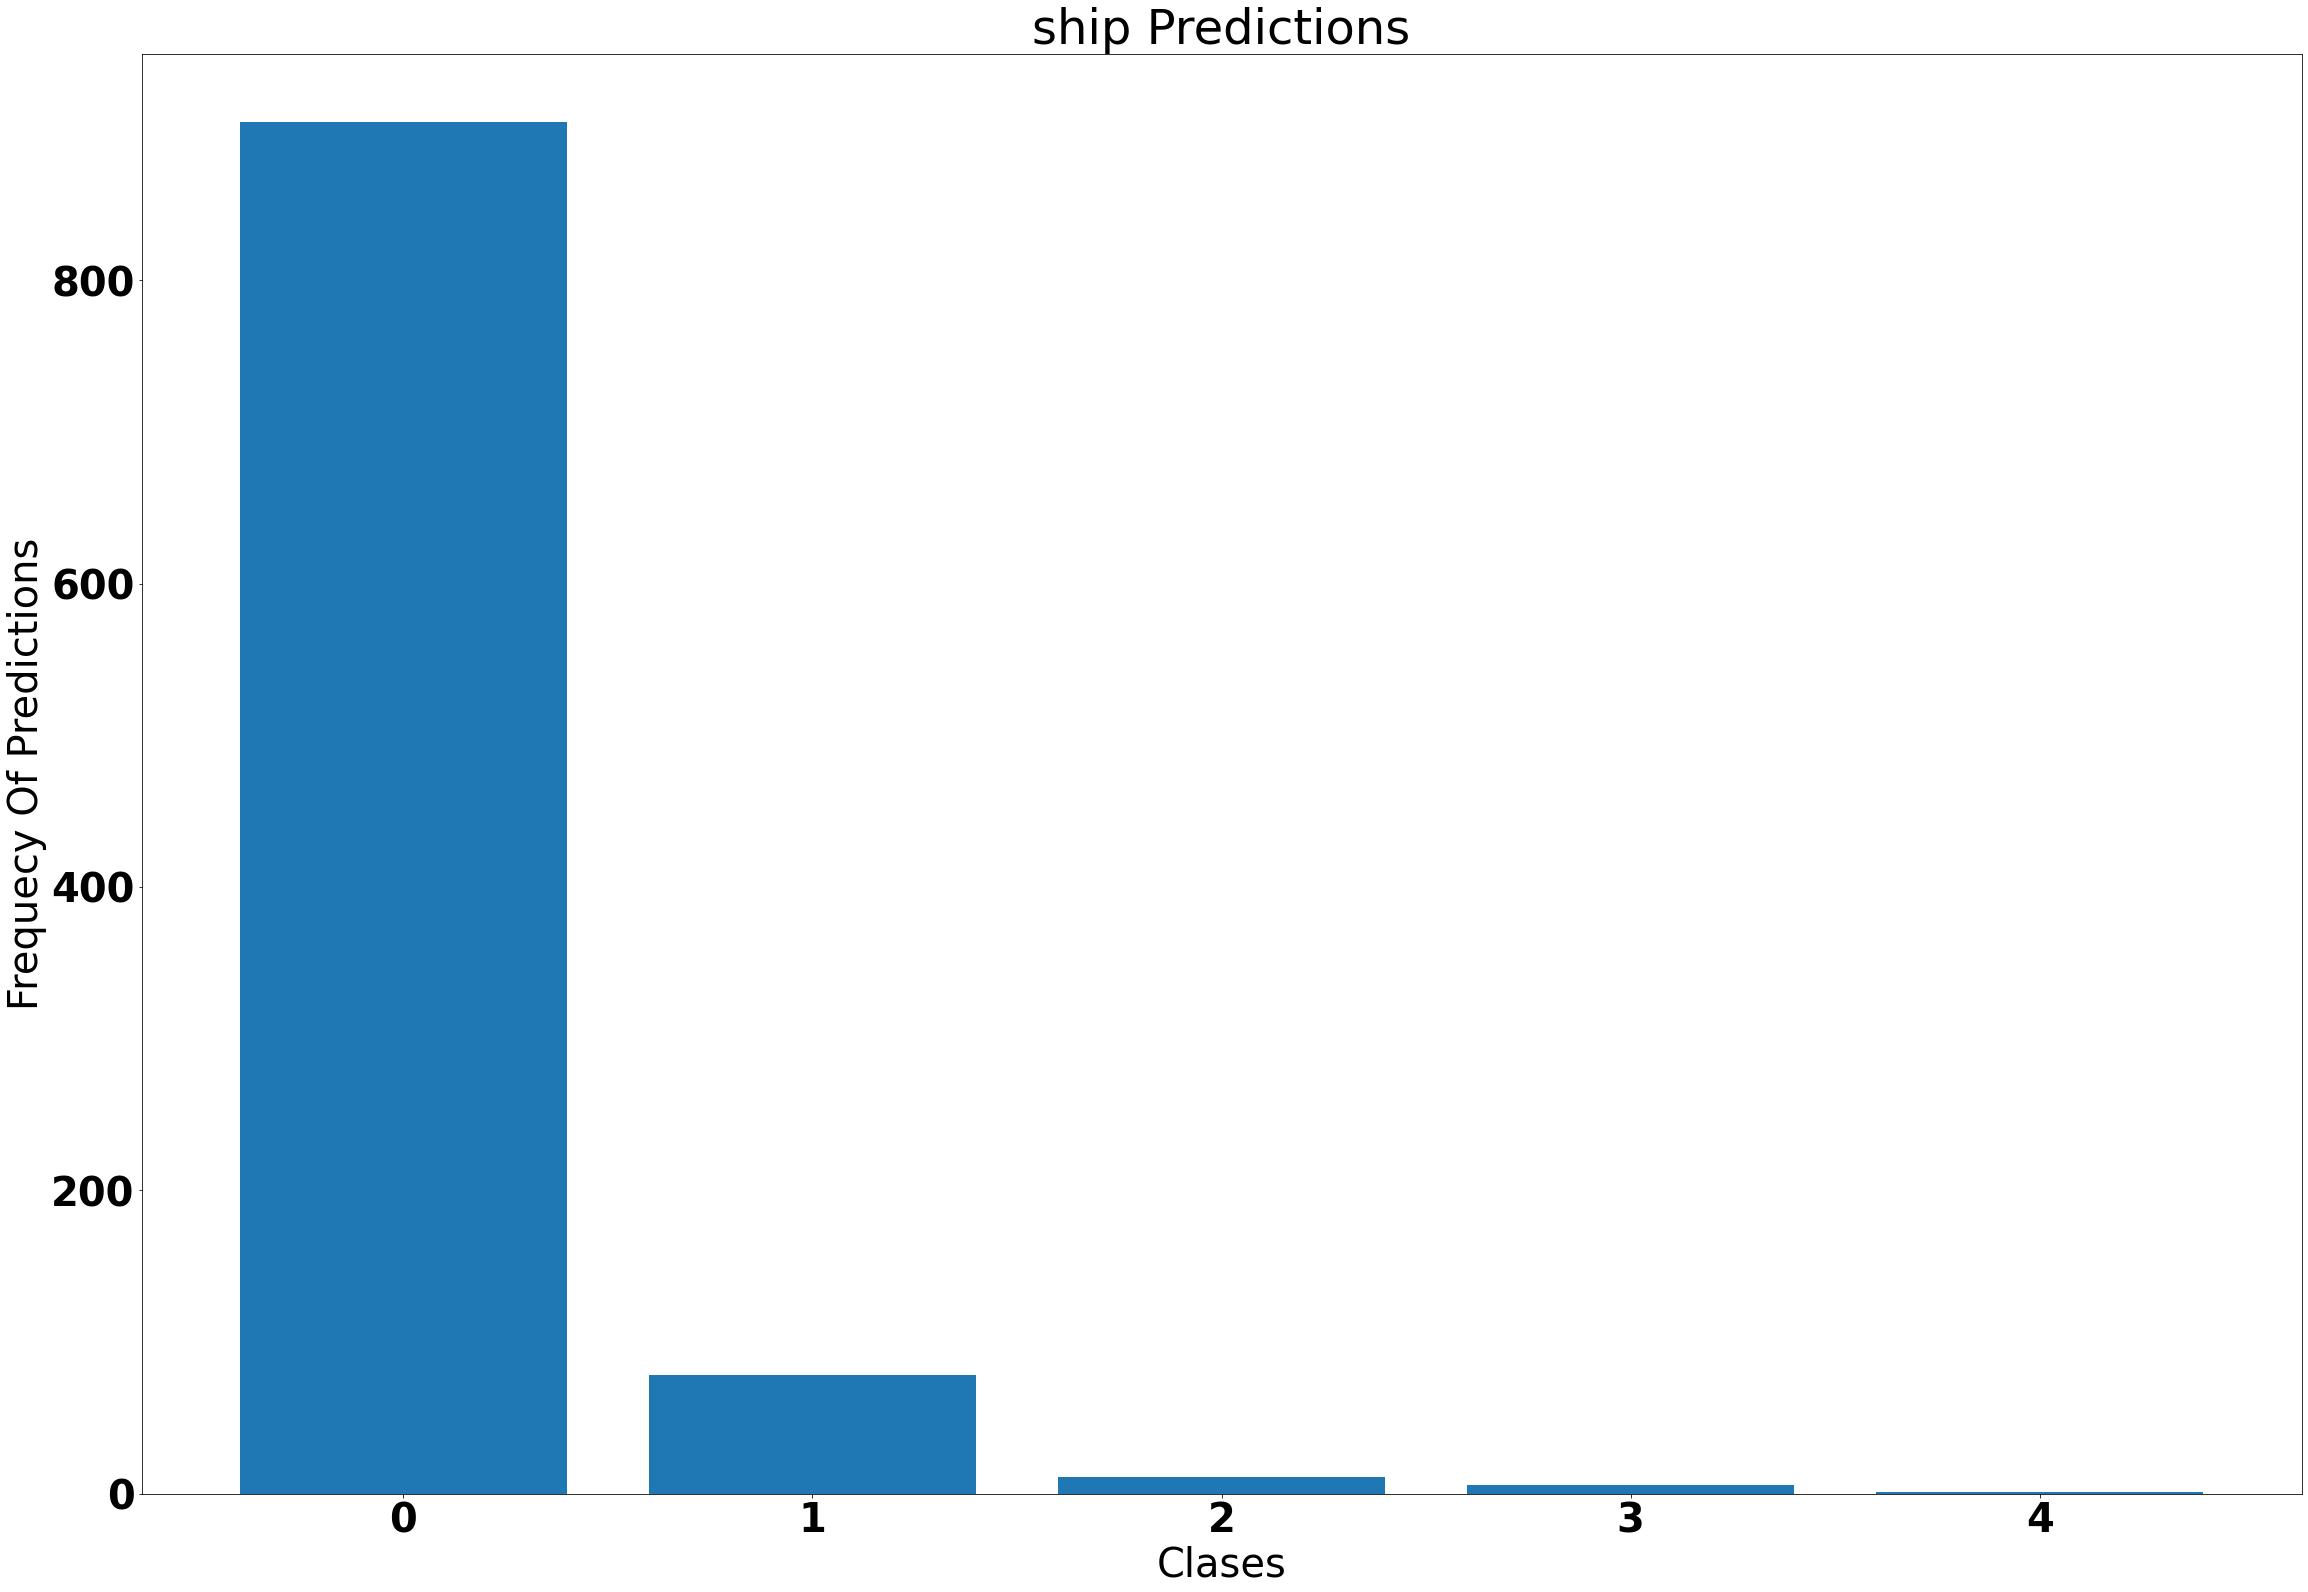

In [22]:
idx = 8
c = returnClassIndex(testY,idx)
preds = ran1.predict(test_feat1[c])
plot_class_predictions(preds, idx)

Class #9


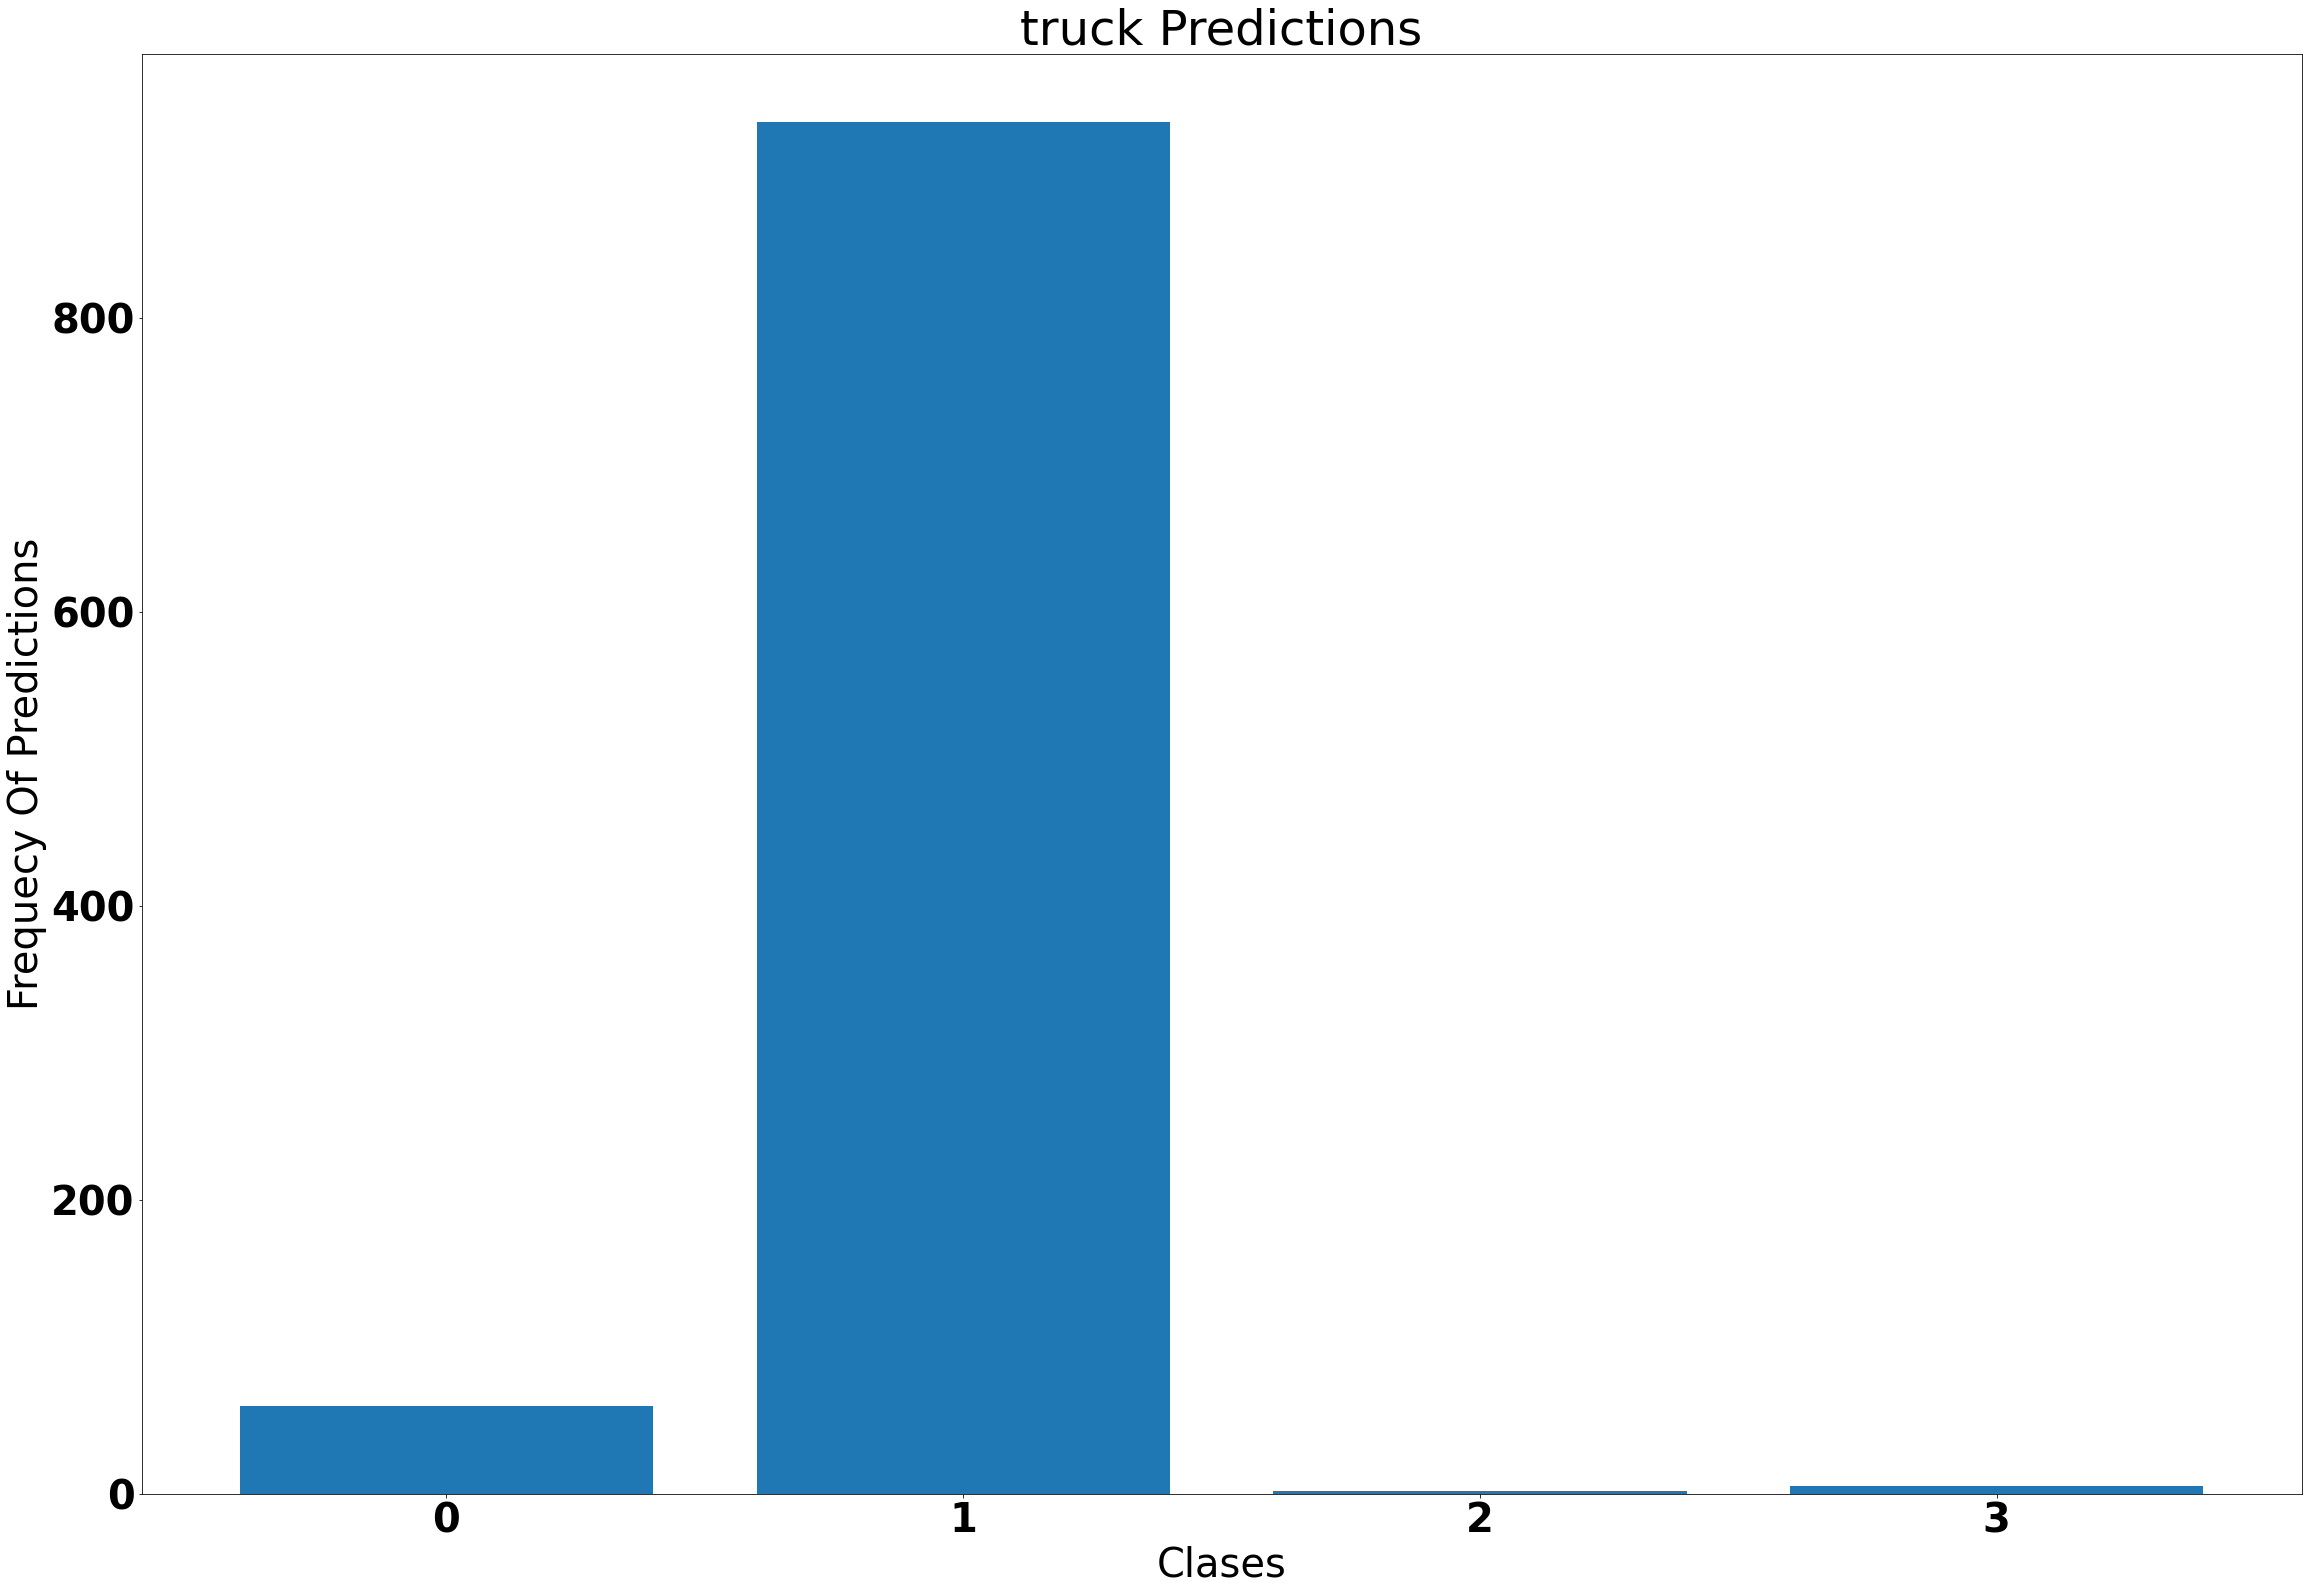

In [23]:
idx = 9
c = returnClassIndex(testY,idx)
preds = ran1.predict(test_feat1[c])
plot_class_predictions(preds, idx)

# Cifar10 New classes 

In [24]:
### Selecting the classes
hold_in_test_classes = [4,5,6,7]
hold_in_test_classes_idx = []
for i in hold_in_test_classes:
    hold_in_test_classes_idx = hold_in_test_classes_idx + returnClassIndex(testY,i)

In [25]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import log_loss, roc_curve
from sklearn.metrics import accuracy_score 
### Selecting the classes
hold_in_test_classes = [6,7,8,9]
hold_in_test_classes_idx = []
for i in hold_in_test_classes:
    hold_in_test_classes_idx = hold_in_test_classes_idx + returnClassIndex(testY,i)

### Nex classes indexes are supper imposed over old ones (groundTruth-5)
groundTruth =np.argmax(testY[hold_in_test_classes_idx], axis = 1)-5
pred = ran1.predict_proba(np.vstack(test_feat1[hold_in_test_classes_idx]))
### Metrics
f1 = f1_score(groundTruth, np.argmax(pred, axis = 1), average = "macro")
acc = accuracy_score(groundTruth,np.argmax(pred, axis = 1))
recall = recall_score(groundTruth, np.argmax(pred, axis = 1), average = "macro")
precision =precision_score(groundTruth, np.argmax(pred, axis = 1), average = "macro")
loss = log_loss(tf.keras.utils.to_categorical(groundTruth), pred)
print("Metrics")
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))
print("recall Score: {}".format(recall))
print("Precision Score: {}".format(precision))

Metrics
Loss: 5.155347167709931
Accuracy: 0.0115
F1 Score: 0.010401146279720098
recall Score: 0.0092
Precision Score: 0.016194165392382685


/home/trex/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


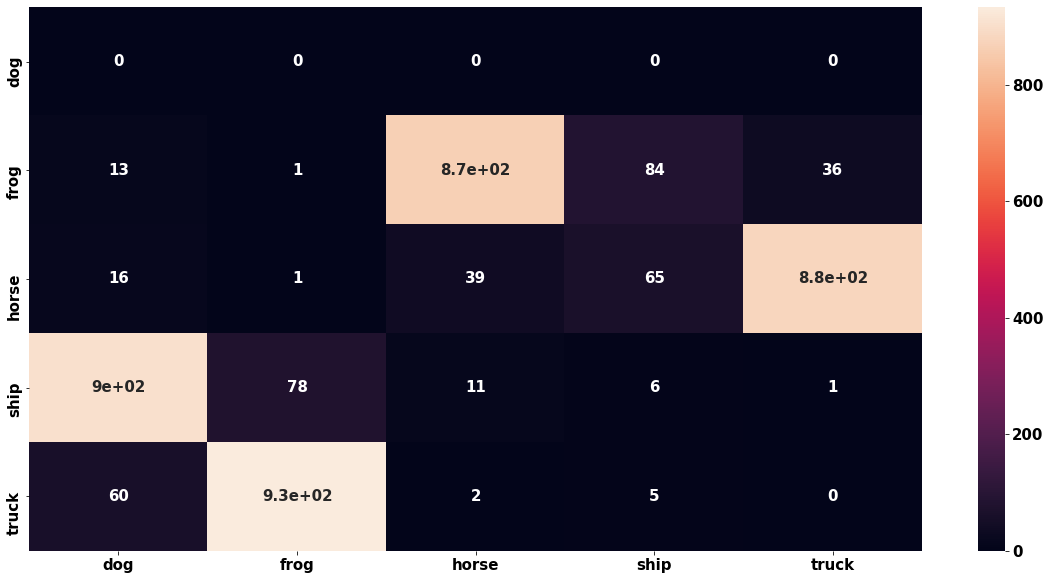

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf = tf.math.confusion_matrix(groundTruth,np.argmax(pred, axis = 1))
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)
labels_names = ['dog','frog','horse','ship','truck']
#'dog','frog','horse','ship',
#                'truck']
df_cm = pd.DataFrame(np.array(conf), index = [i for i in labels_names],
                  columns = [i for i in labels_names])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig("saveed_figures/en_ran/conf_Cifar new Classes.png", dpi = 200)
plt.savefig("saveed_figures/en_ran/conf_Cifar new Classes.pdf", dpi = 200)

/home/trex/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
<ipython-input-27-6f56fb01560f>:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


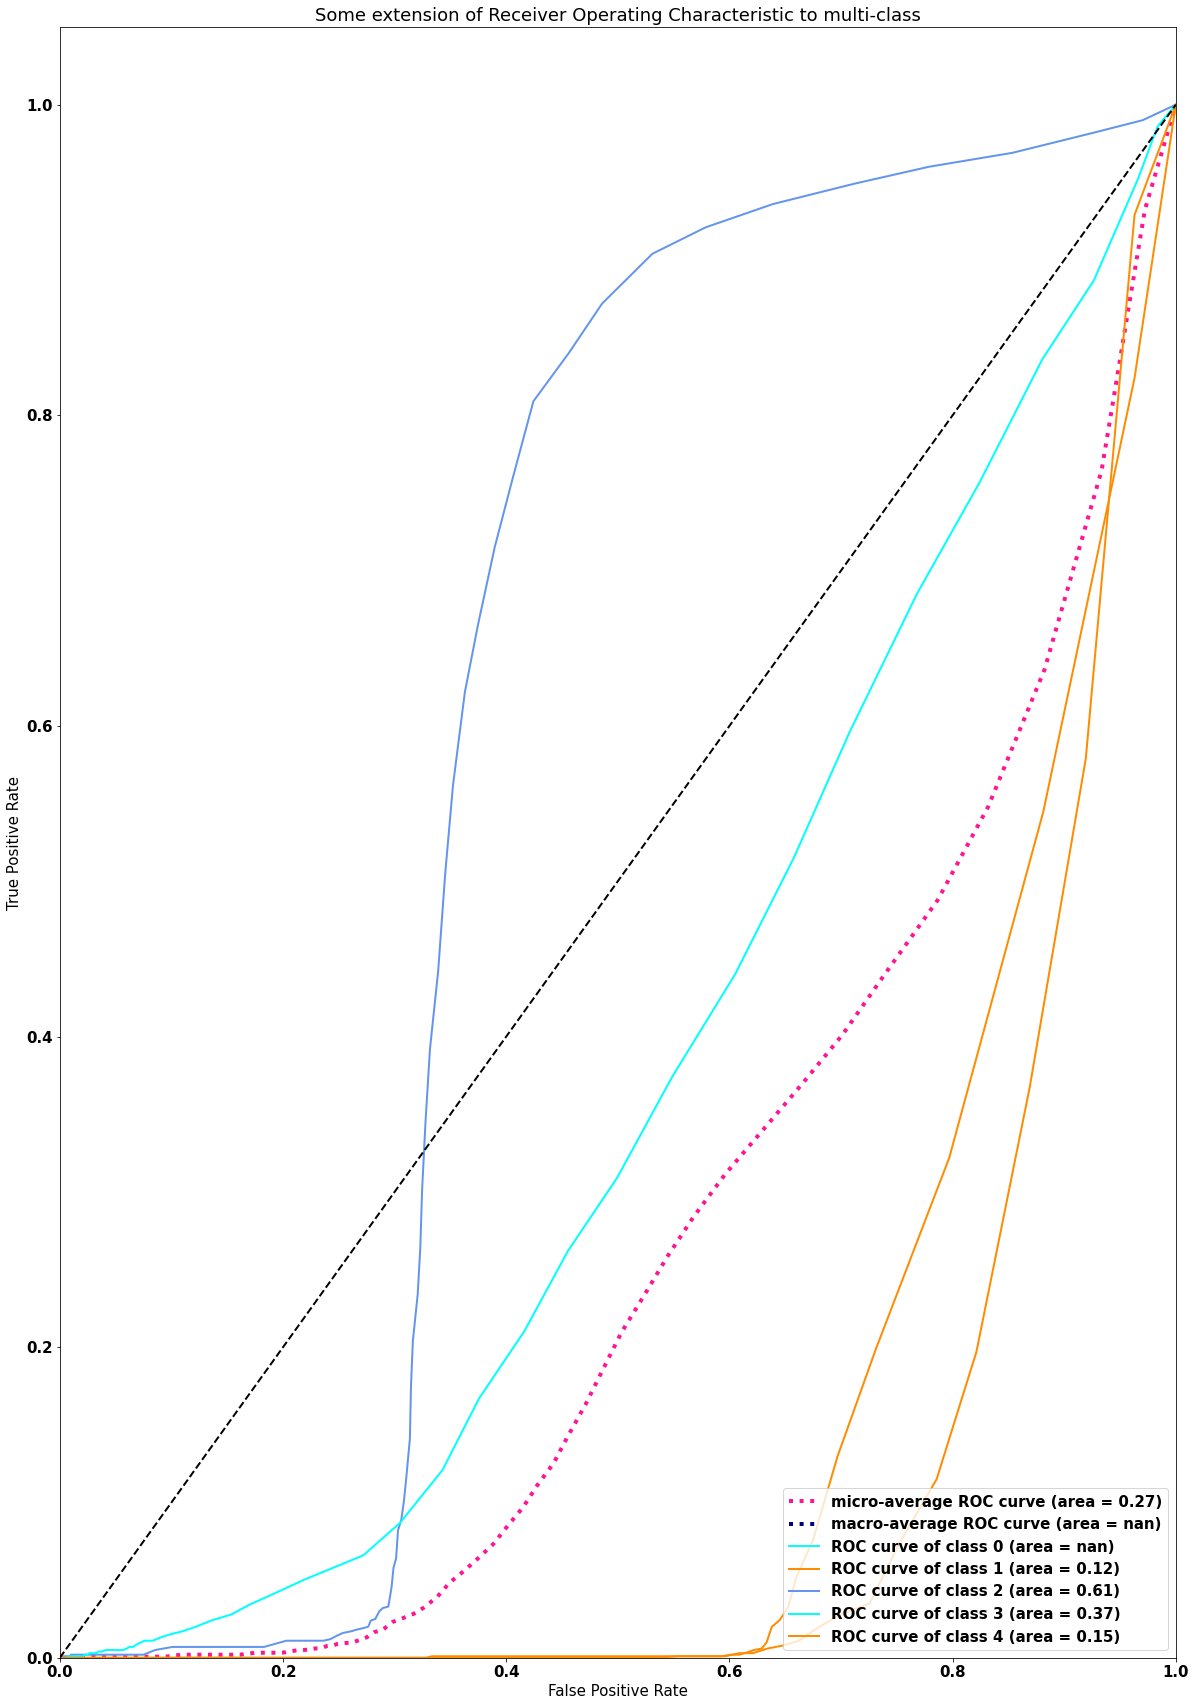

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(tf.keras.utils.to_categorical(groundTruth))
y_score = np.copy(pred)
n_classes =  5
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig("saveed_figures/en_ran/roc_Cifar new Classes.png", dpi = 200)
plt.savefig("saveed_figures/en_ran/roc_Cifar new Classes.pdf", dpi = 200)
plt.show()

Class #5
Class #6
Class #7
Class #8
Class #9


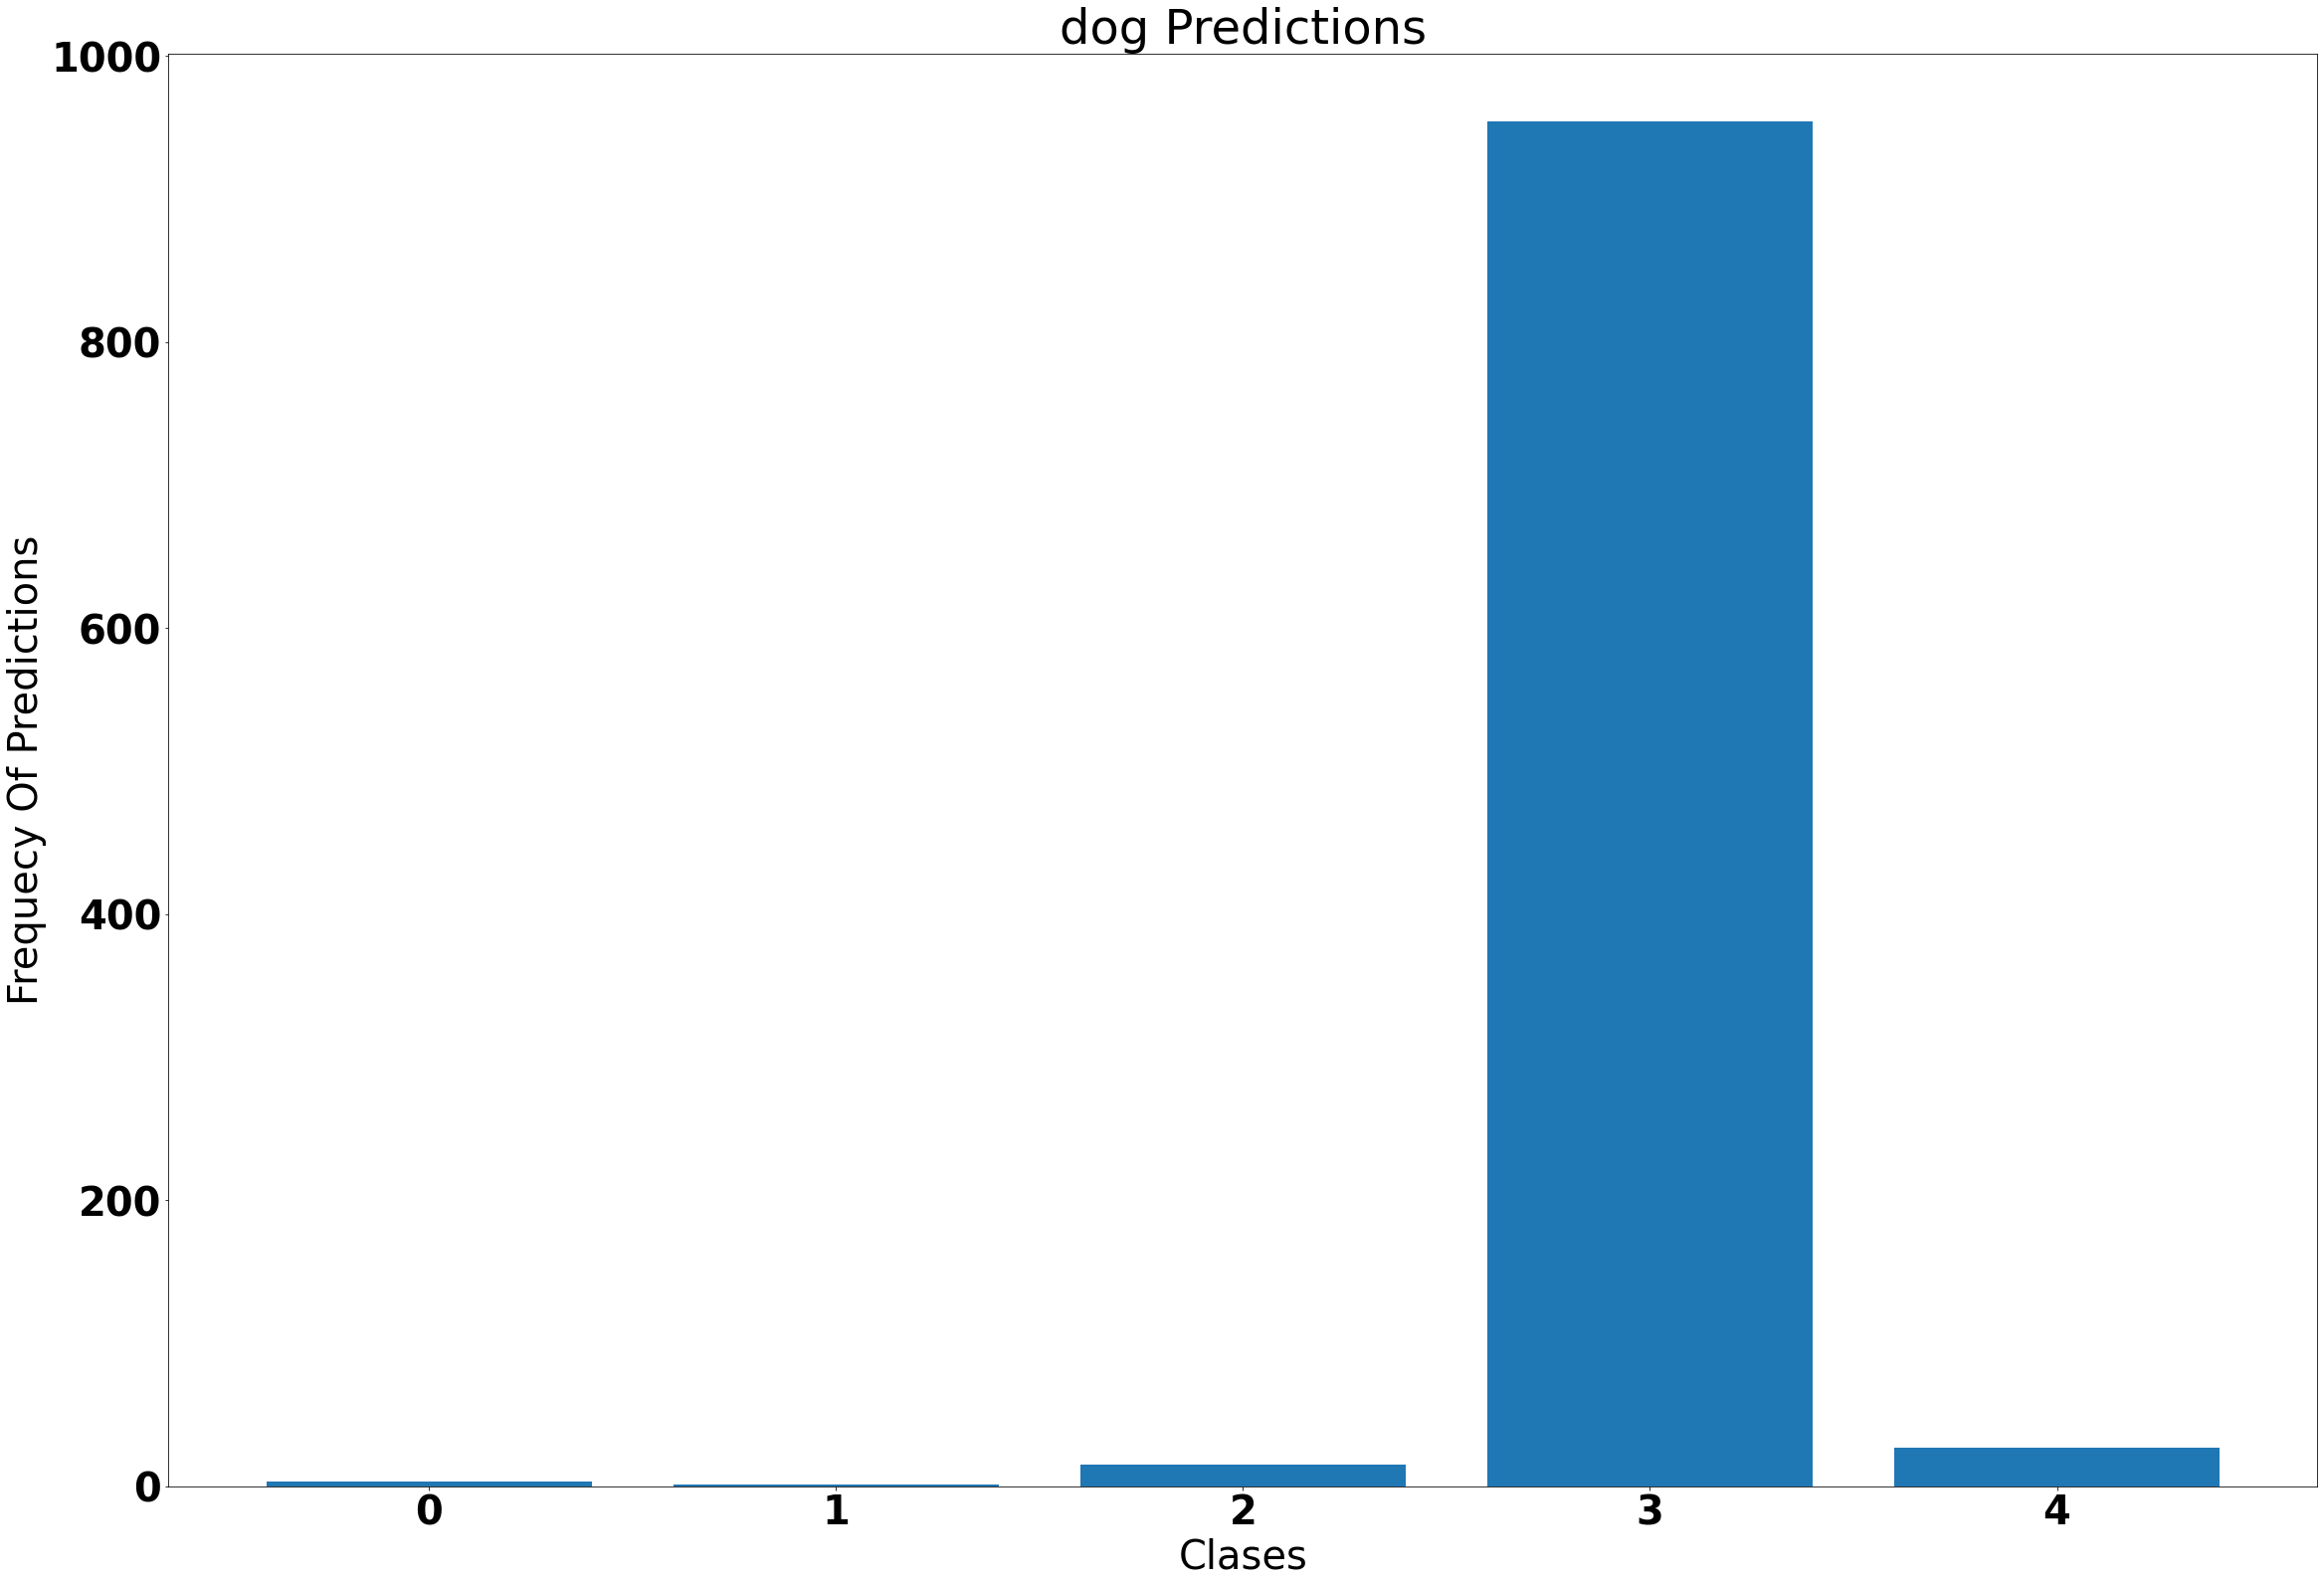

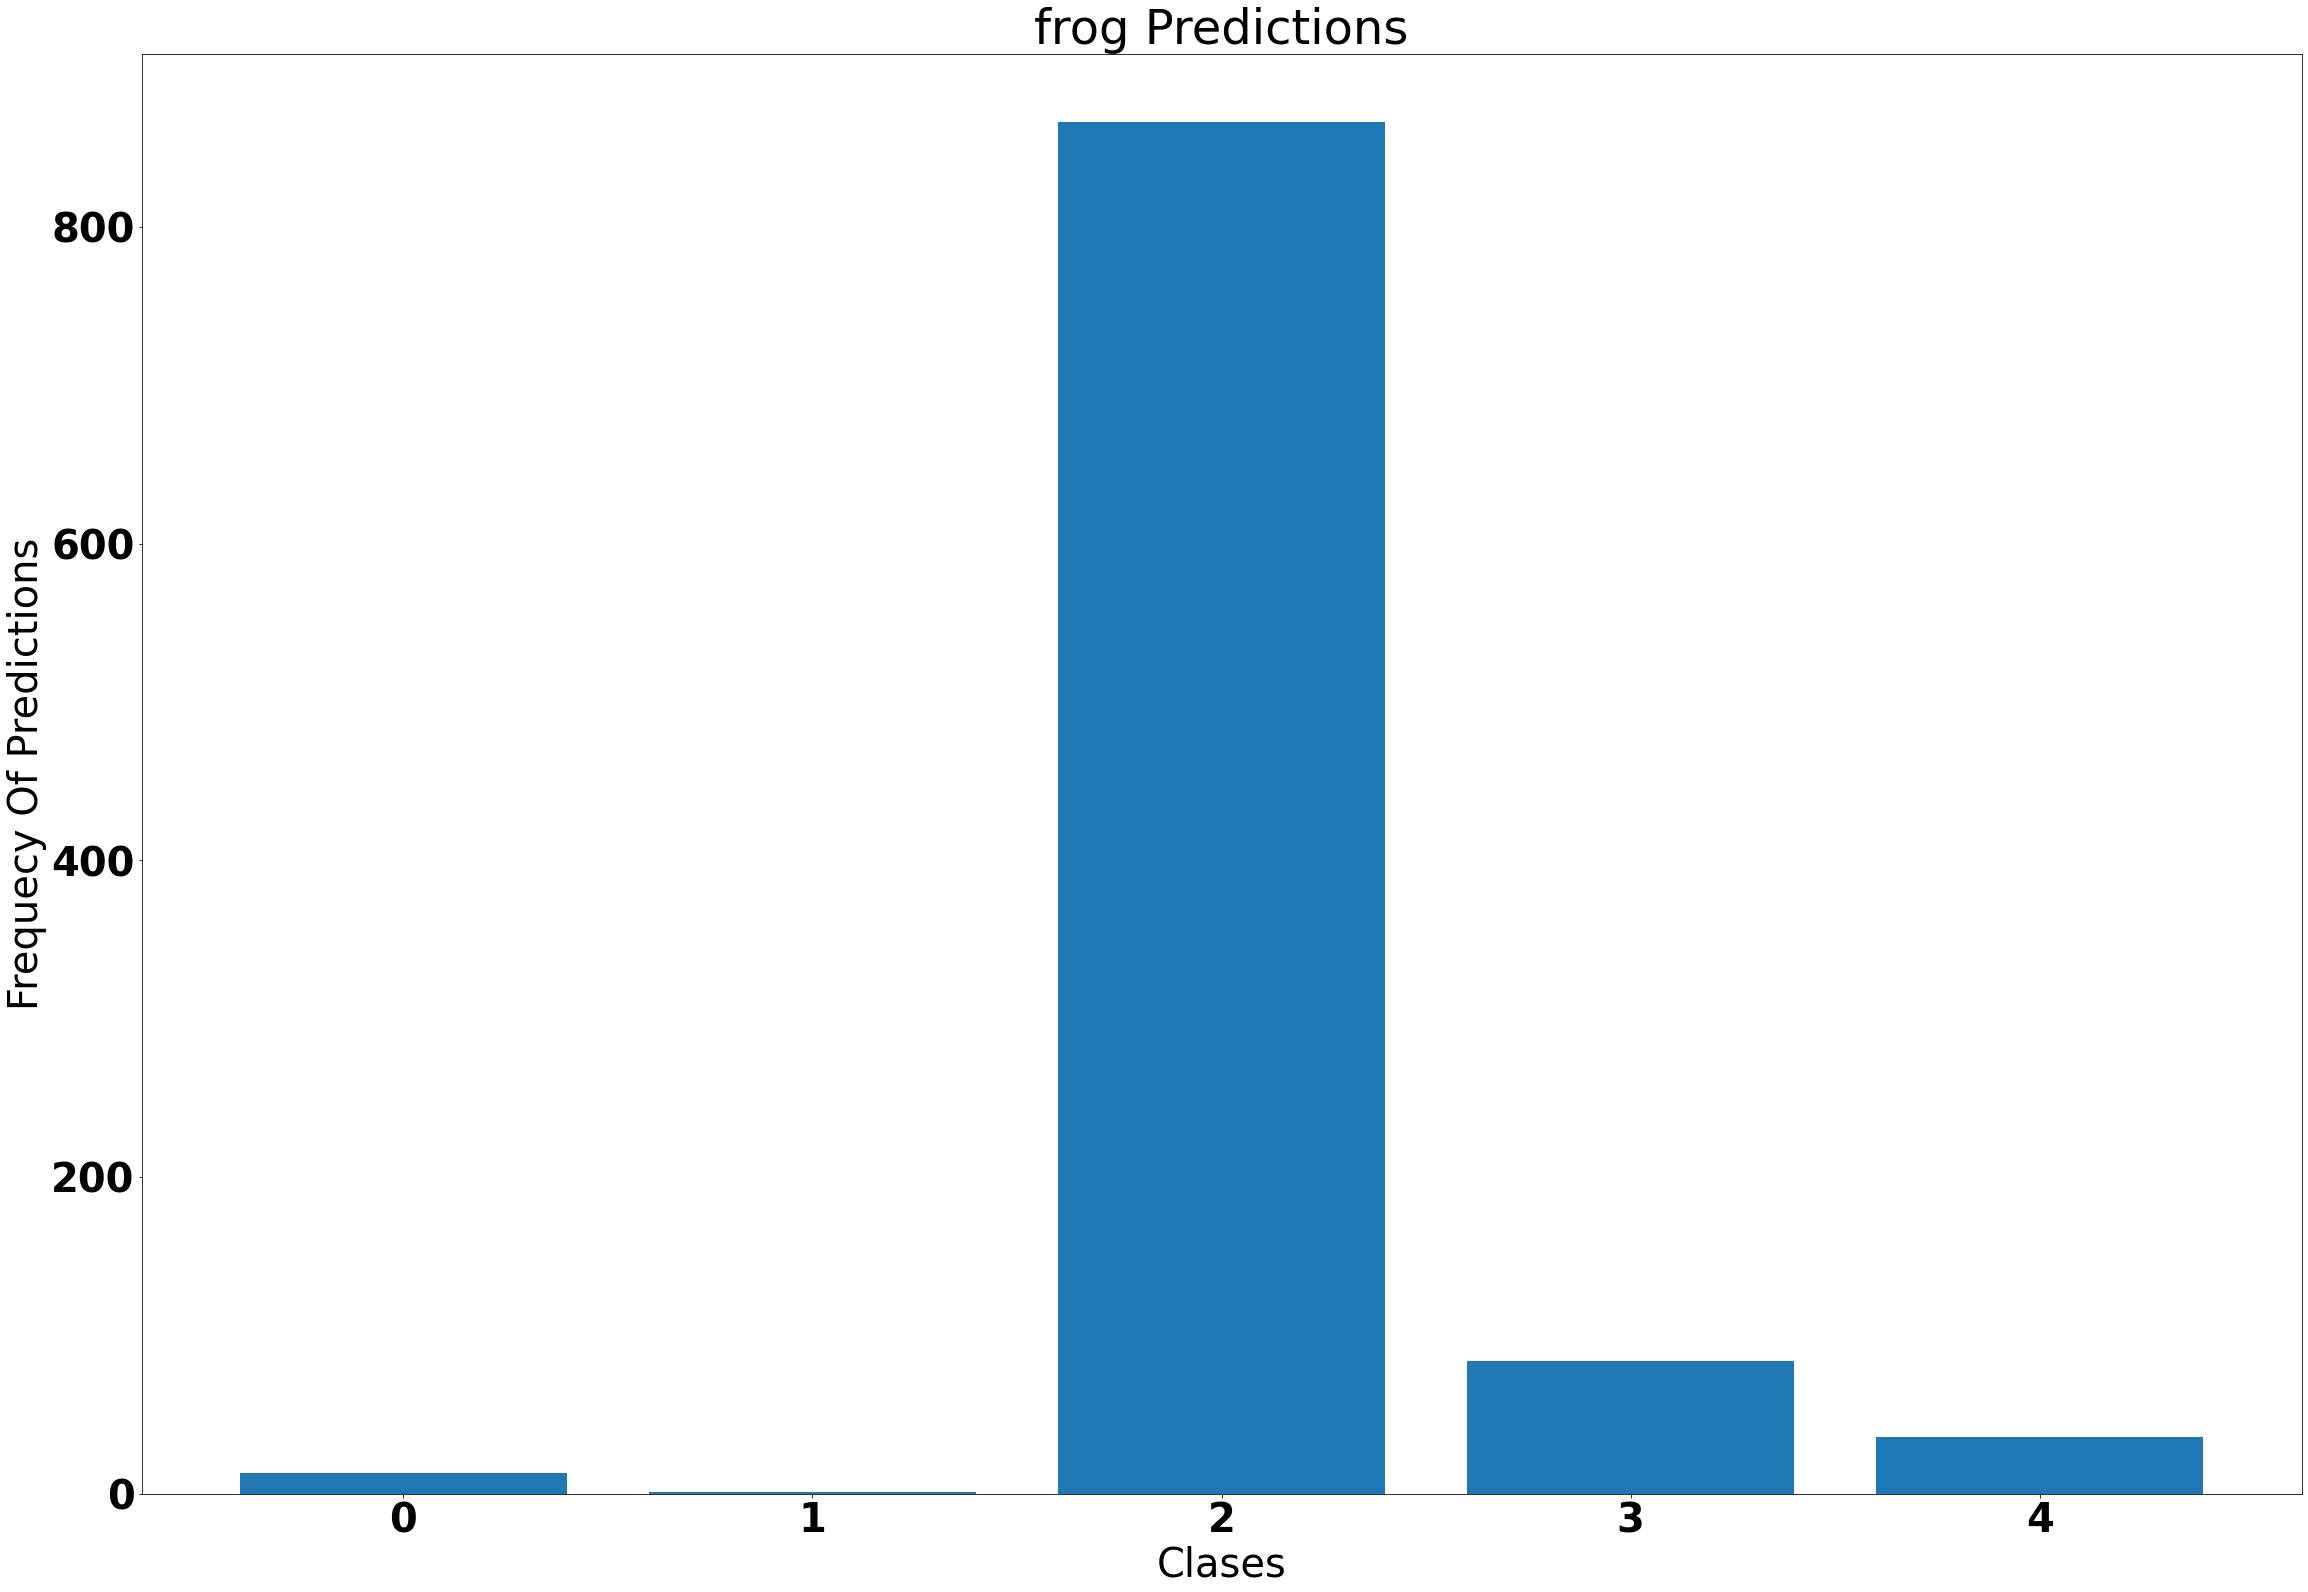

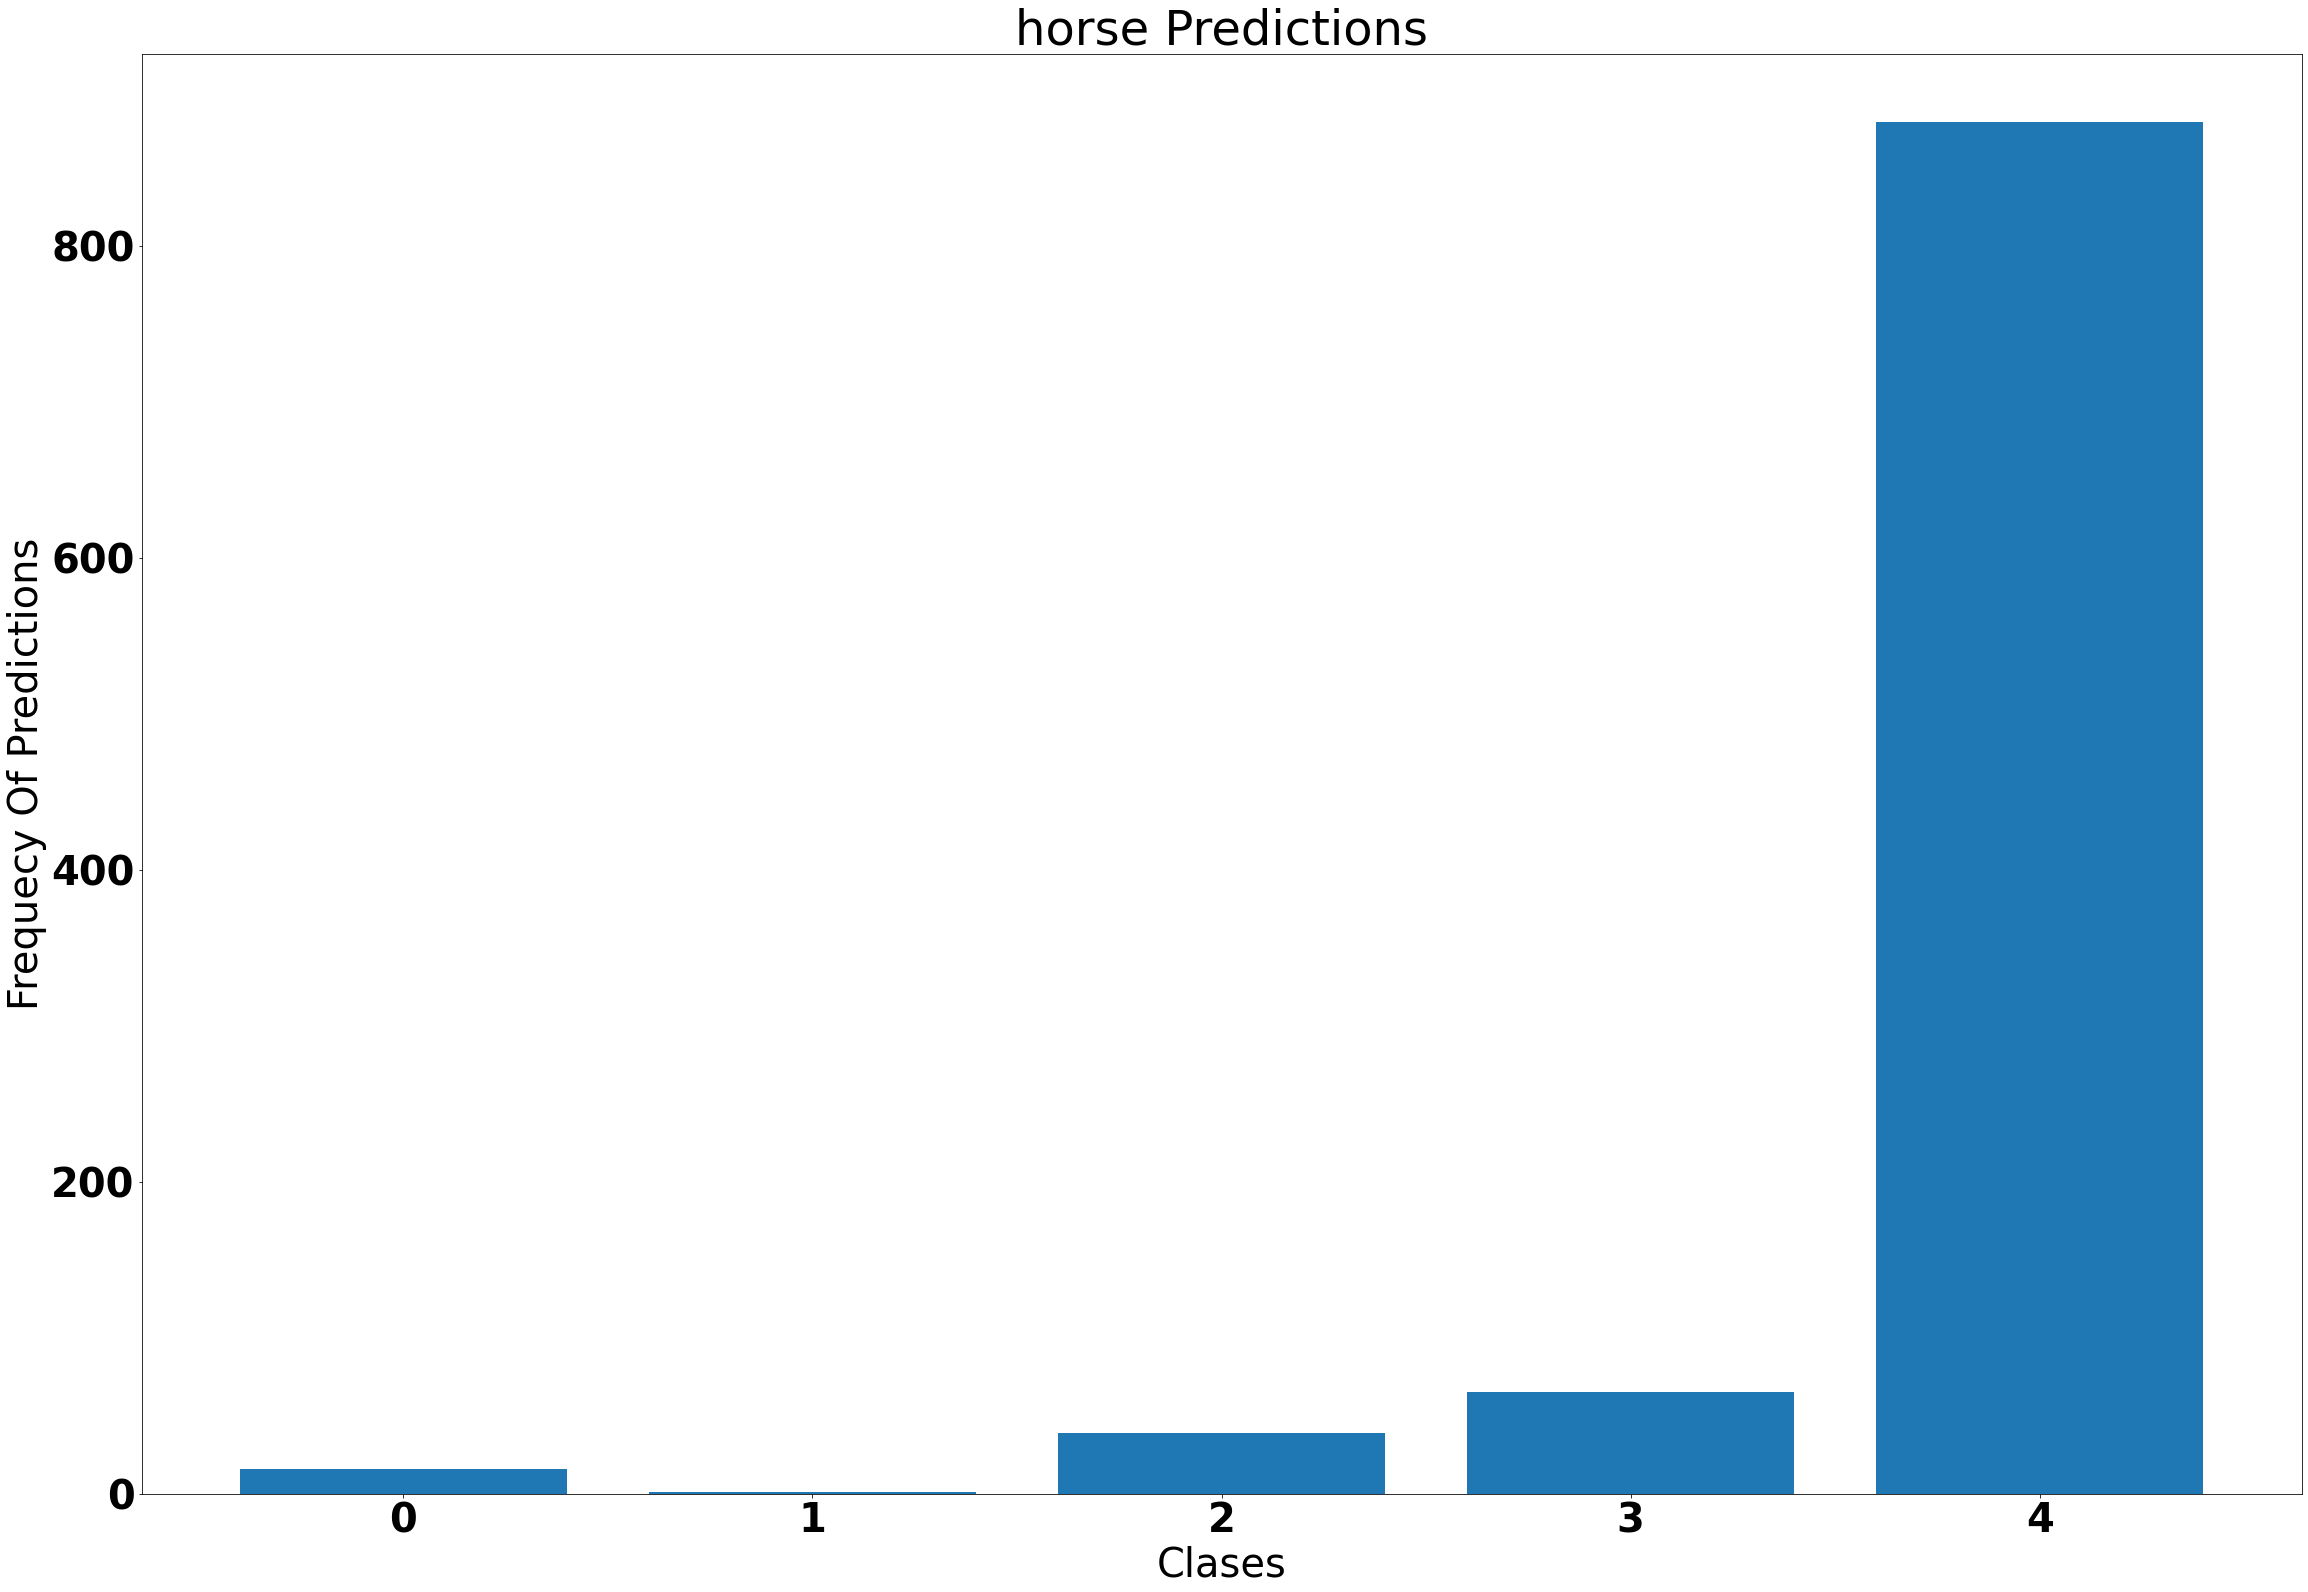

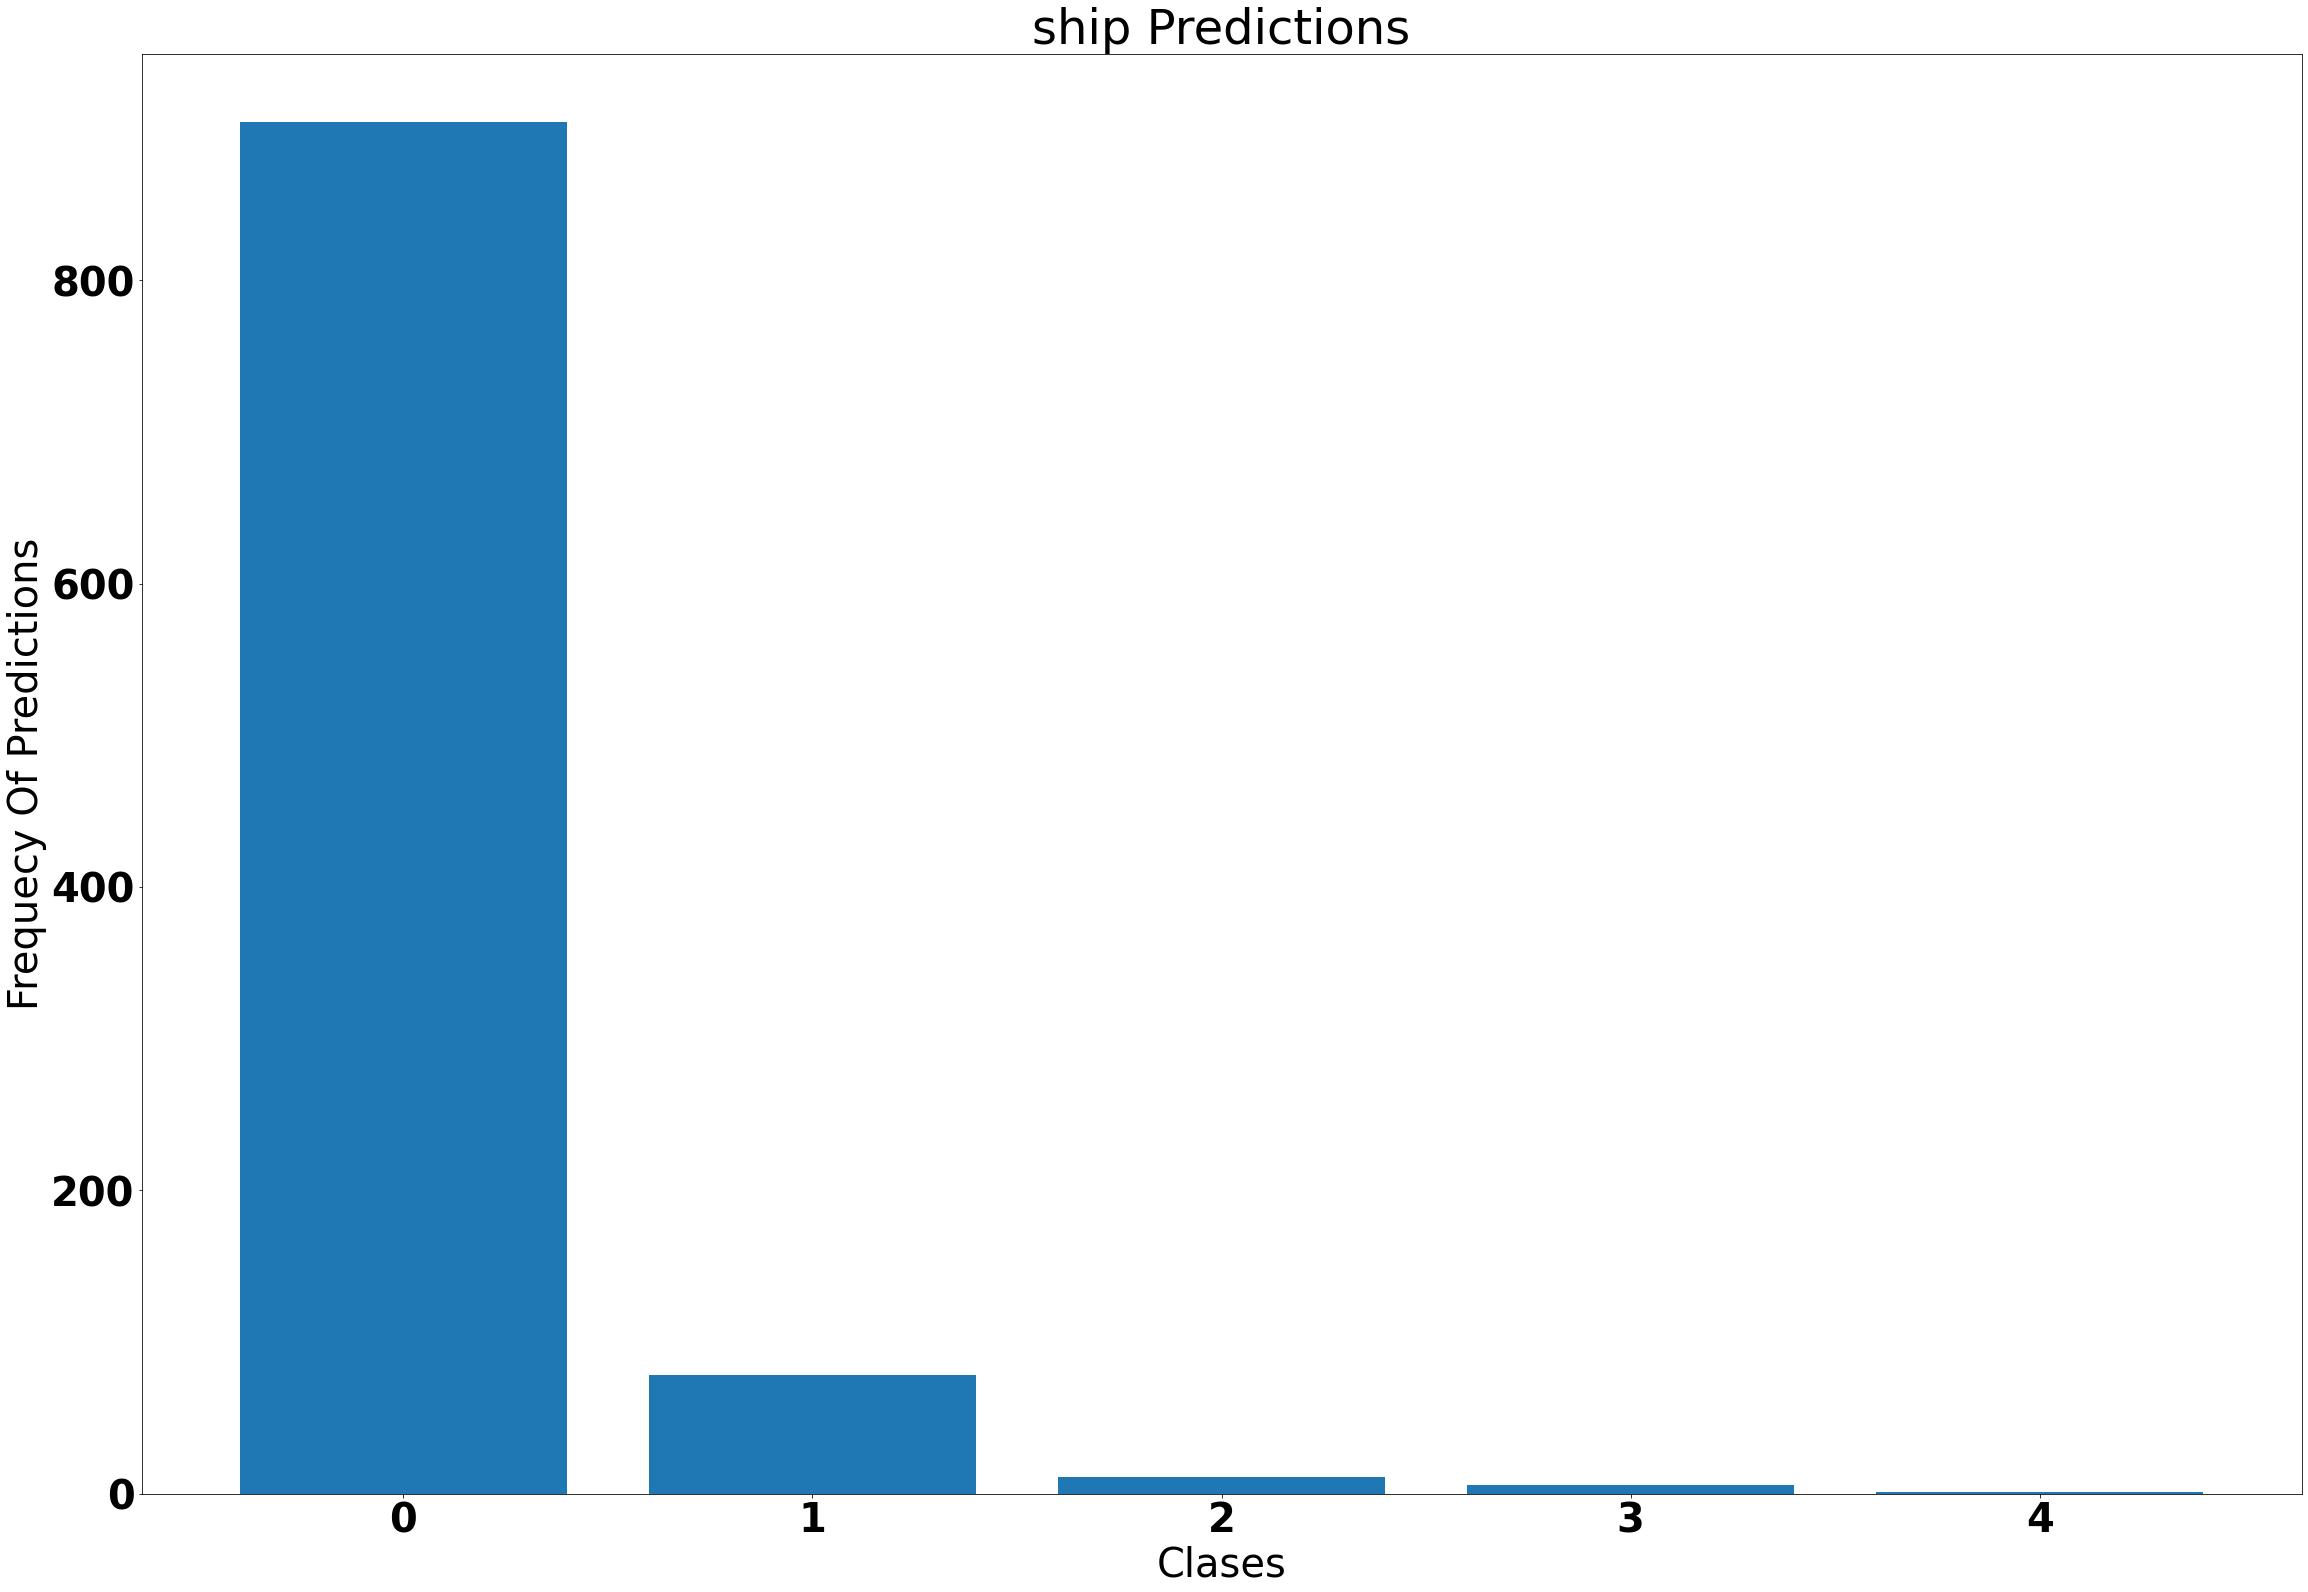

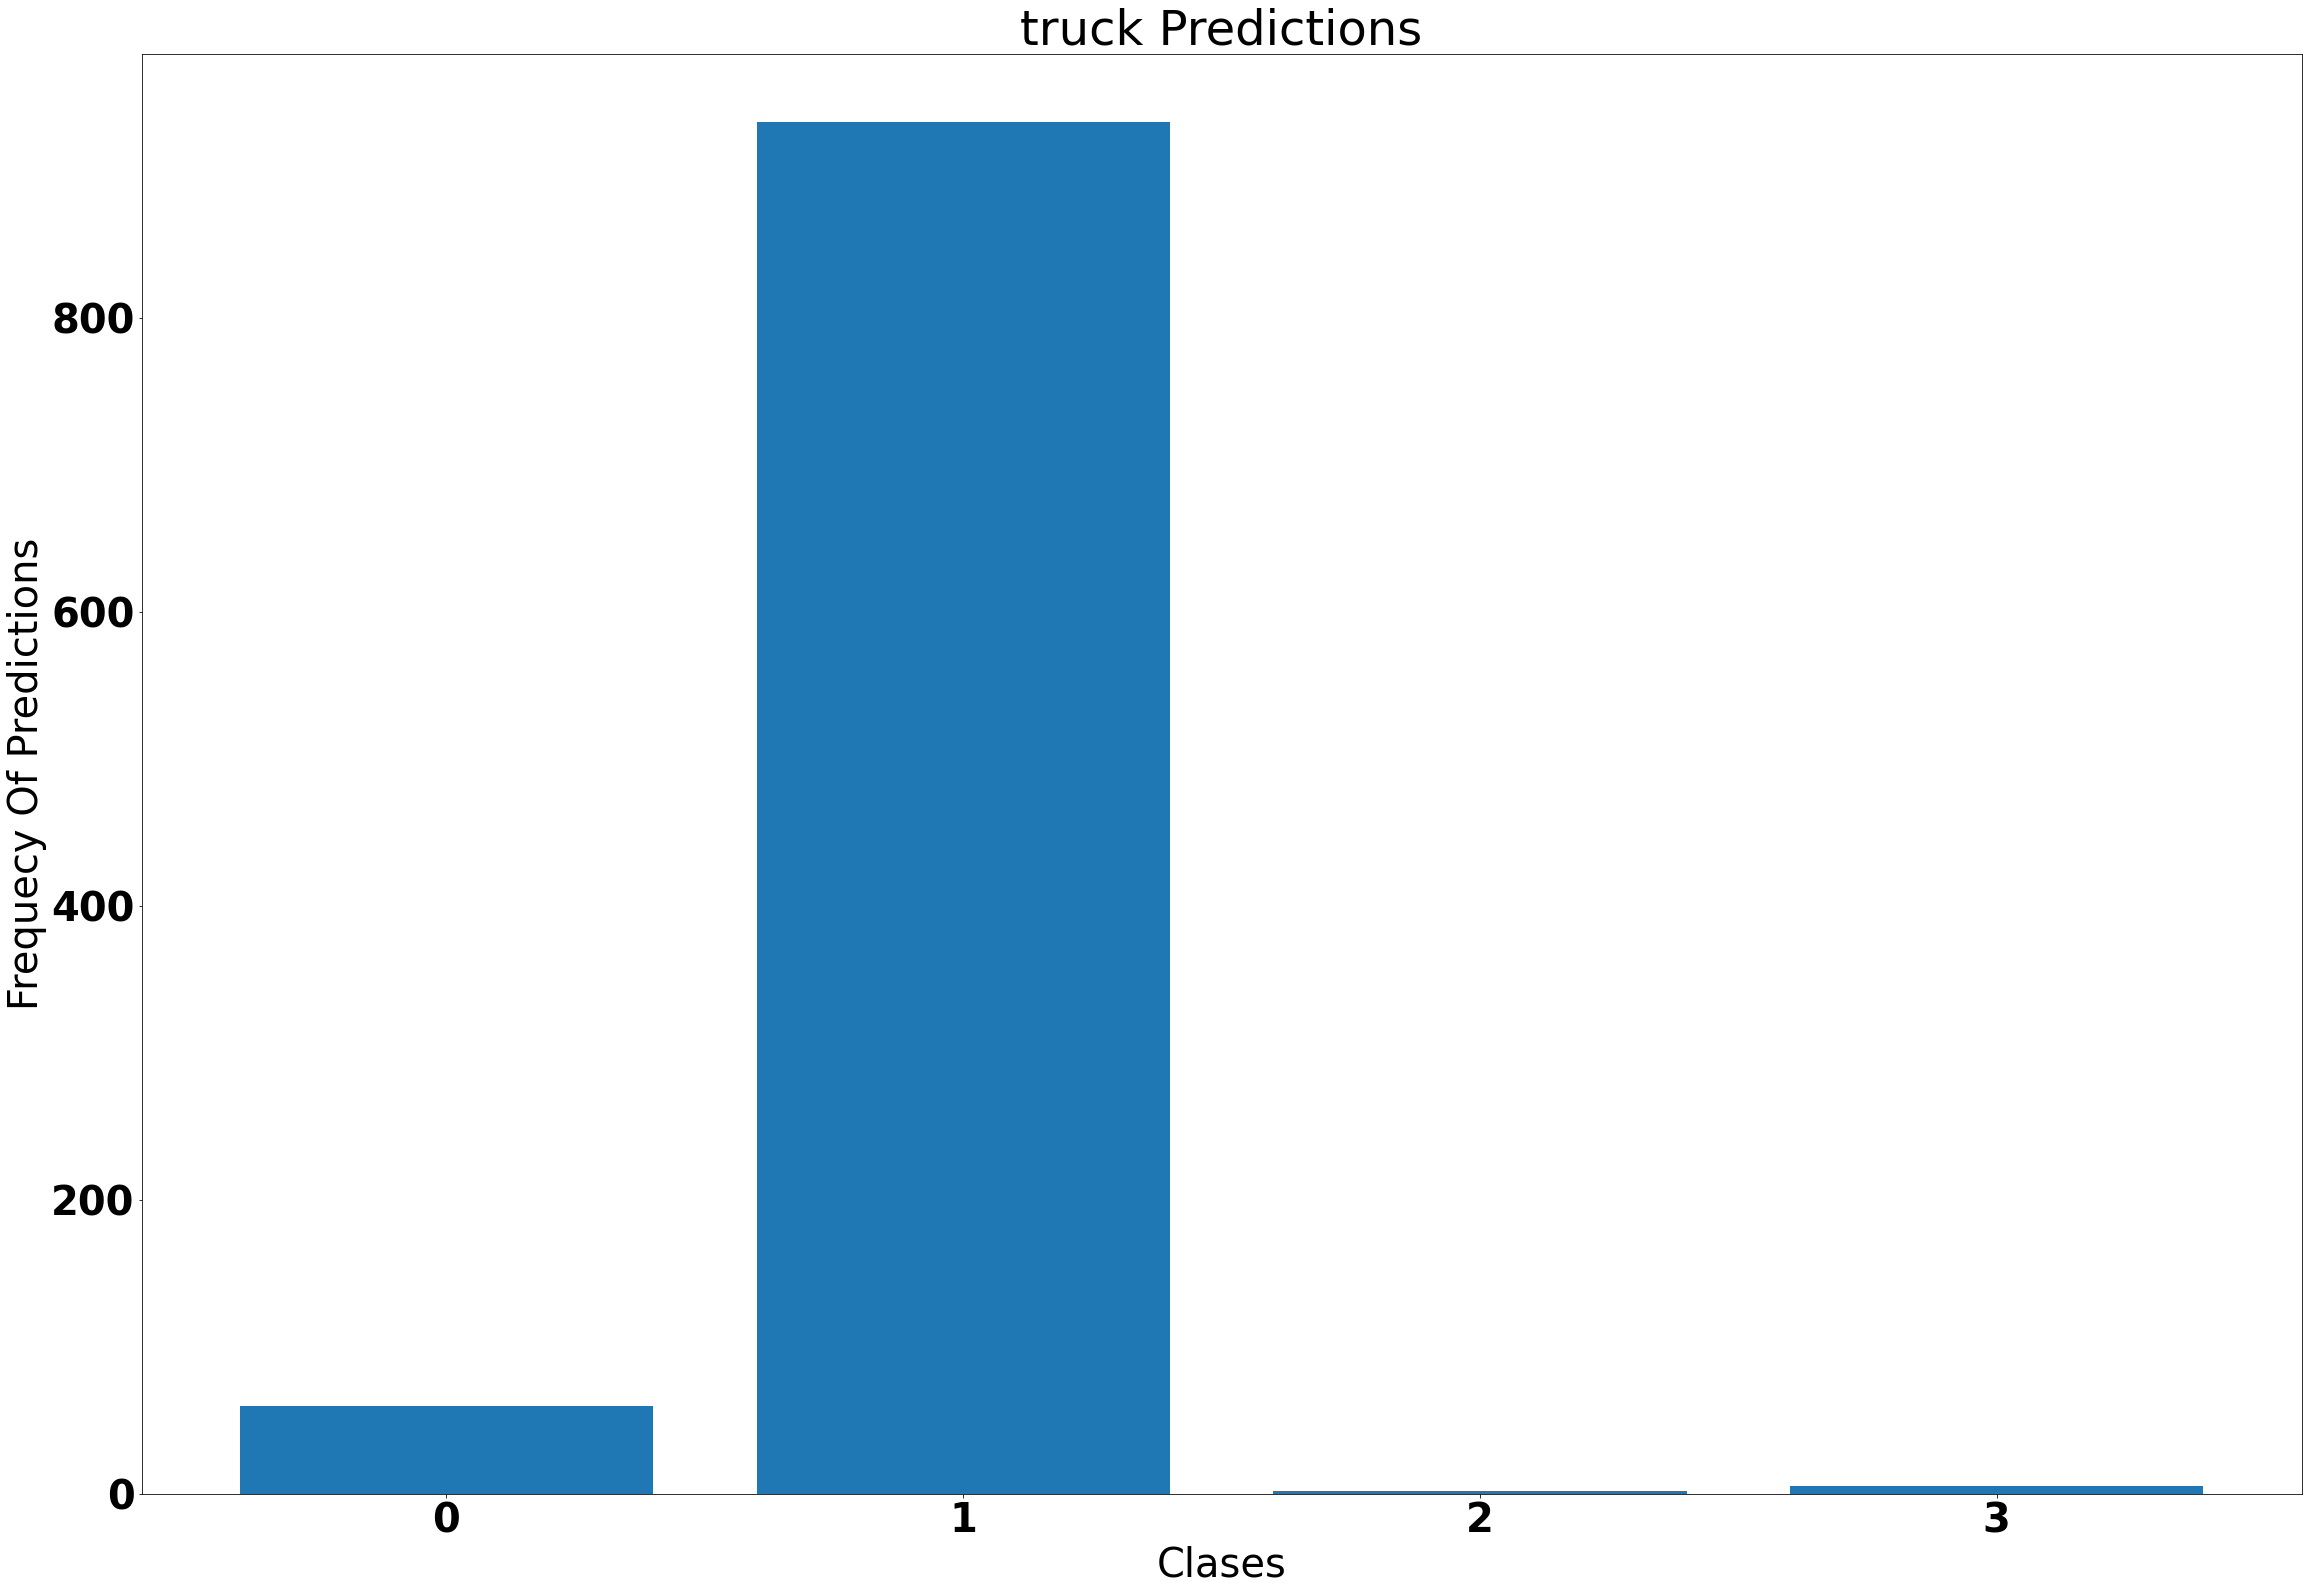

In [28]:

idx = 5
c = returnClassIndex(testY,idx)
preds = ran1.predict(test_feat1[c])
plot_class_predictions(preds, idx)

idx = 6
c = returnClassIndex(testY,idx)
preds = ran1.predict(test_feat1[c])
plot_class_predictions(preds, idx)

idx = 7
c = returnClassIndex(testY,idx)
preds = ran1.predict(test_feat1[c])
plot_class_predictions(preds, idx)

idx = 8
c = returnClassIndex(testY,idx)
preds = ran1.predict(test_feat1[c])
plot_class_predictions(preds, idx)

idx = 9
c = returnClassIndex(testY,idx)
preds = ran1.predict(test_feat1[c])
plot_class_predictions(preds, idx)

# RandomForest The Skin Disease Dataset

In [32]:
gnd_truth = pd.read_csv("data/SkinDiseaseDataset/ISIC_2019_Training_GroundTruth.csv")
#aug_df = pd.read_csv("data/augmentImageNameLabels.csv")
gnd_truth.head()

IMG_NAMES = gnd_truth['image']
TRAIN_IMG_RT_PATH = 'data/ISIC_2019_Training_Input/'
TEST_IMG_RT_PATH = 'data/ISIC_2019_Test_Input'
### No Examples of UNK so drop it
labels = np.array(gnd_truth.drop(columns = ["image", "UNK"]))


# of occurences
[ 4522 12875  3323   867  2624   239   253   628]
Classes
[0 1 2 3 4 5 6 7]


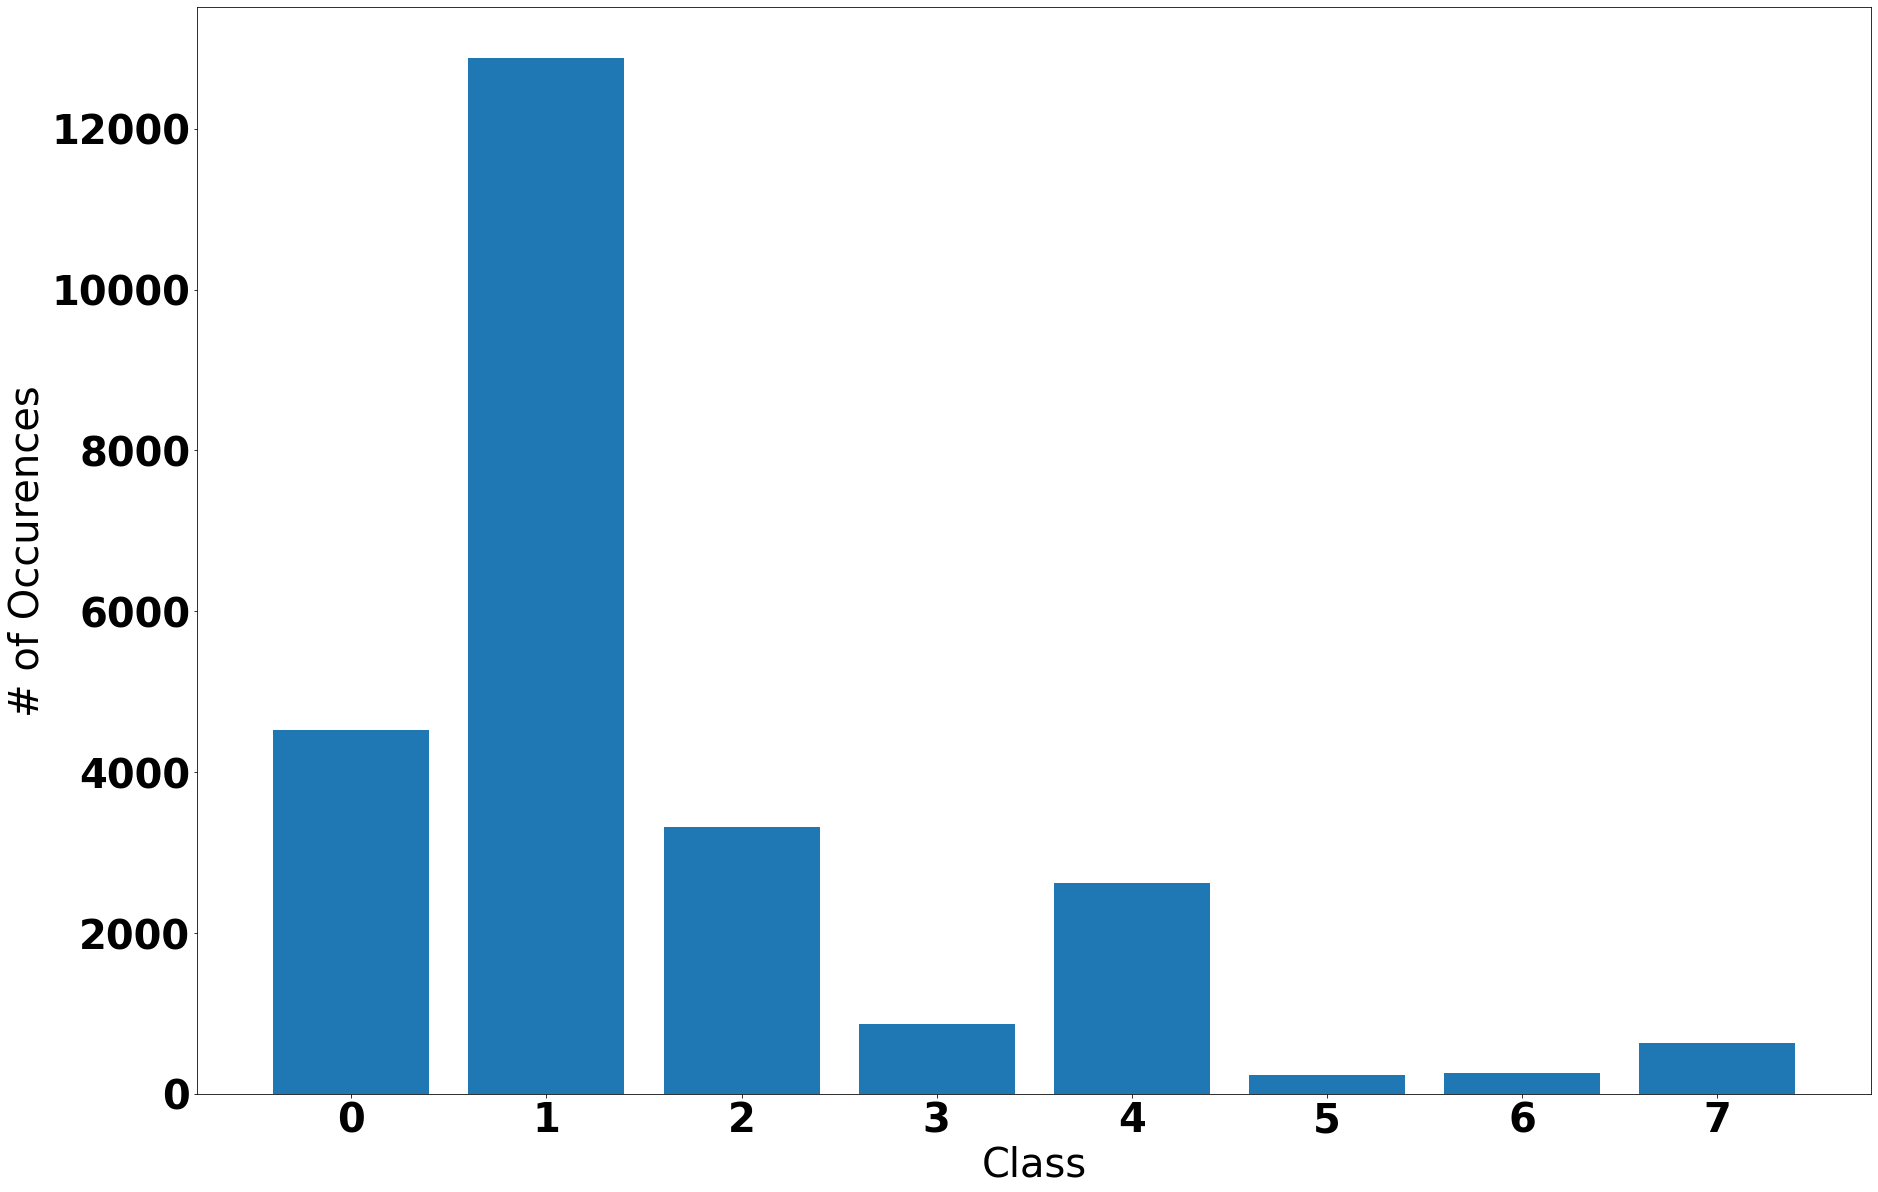

In [33]:
c, freq = np.unique(np.argmax(labels, axis= 1), return_counts = True)
fig = plt.figure( figsize = (30,20))
font = {'family' : 'sans',
            'weight' : 'bold',
            'size'   : 40}
matplotlib.rc('font', **font)
plt.xlabel("Class")
plt.ylabel("# of Occurences")
plt.bar(c,freq)
print("# of occurences")
print(freq)
print("Classes")
print(c)

In [34]:
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]


### Randomly Balance Sample from classes  
smpl_test_idxs = []
smpl_train_idxs = []
for i in range(len(labels[1])):
    idxs = np.array(returnClassIndex(labels, i))
    sel = np.random.RandomState(seed = 42).permutation(len(idxs))
    #print(len(idxs))
    ### Shuffle
    train_sel = list(sel[:int(0.75*len(idxs))])
    test_sel = list(sel[int(0.75*len(idxs)):])
    smpl_train_idxs += list(idxs[train_sel])
    smpl_test_idxs += list(idxs[test_sel])

paths = np.array([TRAIN_IMG_RT_PATH + m +'.jpg' for m in IMG_NAMES ])

In [35]:
im_size =200
channels = 3
num_classes = 8
lr = 0.001 ### learning rate
input_shape = ( im_size, im_size, channels)
l1_lambda = 0 ### L1 regularization lambda parameter
l2_lambda = 0
keep_prob =  0
batch_size = 16

In [36]:
### Dataframes for Generator
train_df = pd.DataFrame({"filename":paths[smpl_train_idxs],
                        "class": np.argmax(labels, axis = 1)[smpl_train_idxs].astype(str)})
test_df = pd.DataFrame({"filename":paths[smpl_test_idxs],
                        "class": np.argmax(labels, axis = 1)[smpl_test_idxs].astype(str)})

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,
        samplewise_center = True,
        samplewise_std_normalization = True, 
        horizontal_flip=True,
        vertical_flip = True,
        shear_range=0.5,
        zoom_range=0.5,
        rotation_range = 30
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size, 
    target_size = (im_size, im_size)
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size,
    target_size = (im_size, im_size)
)

Found 18996 validated image filenames belonging to 8 classes.
Found 6335 validated image filenames belonging to 8 classes.


In [37]:
skin_trainY = []
skin_feat_train = []
for i in tqdm(range(len(train_generator))):
    tmp = next(train_generator)
    skin_feat_train.append(extractor0.predict(tmp[0]))
    skin_trainY.append(tmp[1])

100%|██████████| 1188/1188 [13:21<00:00,  1.48it/s]


In [38]:
skin_testY = []
skin_feat_test = []
for i in tqdm(range(len(test_generator))):
    tmp = next(test_generator)
    skin_feat_test.append(extractor0.predict(tmp[0]))
    skin_testY.append(tmp[1])

100%|██████████| 396/396 [04:29<00:00,  1.47it/s]


In [39]:
skin_trainY_ = np.vstack(skin_trainY)
skin_feat_train_ = np.vstack(skin_feat_train)
skin_testY_ = np.vstack(skin_testY)
skin_feat_test_ = np.vstack(skin_feat_test)

In [40]:
### Selecting the classes
hold_in_train_classes = [0,1,2,3]
hold_in_train_classes_idx = []
for i in hold_in_train_classes:
    hold_in_train_classes_idx = hold_in_train_classes_idx + returnClassIndex(skin_trainY_,i)

In [41]:
### Selecting the classes
hold_in_test_classes = [0,1,2,3]
hold_in_test_classes_idx = []
for i in hold_in_test_classes:
    hold_in_test_classes_idx = hold_in_test_classes_idx + returnClassIndex(skin_testY_,i)

In [42]:
from sklearn.ensemble import RandomForestClassifier 
sran = RandomForestClassifier()
sran.fit(np.vstack(skin_feat_train_[hold_in_train_classes_idx]),
         np.argmax(skin_trainY_[hold_in_train_classes_idx], axis = 1))

RandomForestClassifier()

In [43]:
from sklearn.metrics import accuracy_score 
groundTruth =np.argmax(skin_testY_[hold_in_test_classes_idx ], axis = 1)
pred = sran.predict_proba(np.vstack(skin_feat_test_[hold_in_test_classes_idx ]))

In [44]:
groundTruth

array([0, 0, 0, ..., 3, 3, 3])

In [45]:
pred.shape

(5398, 4)

In [46]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import log_loss, roc_curve

f1 = f1_score(groundTruth, np.argmax(pred, axis = 1), average = "macro")
acc = accuracy_score(groundTruth,np.argmax(pred, axis = 1))
recall = recall_score(groundTruth, np.argmax(pred, axis = 1), average = "macro")
precision =precision_score(groundTruth, np.argmax(pred, axis = 1), average = "macro")
loss = log_loss(tf.keras.utils.to_categorical(groundTruth), pred)
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))
print("recall Score: {}".format(recall))
print("Precision Score: {}".format(precision))

Loss: 1.5035673758815522
Accuracy: 0.6450537236013338
F1 Score: 0.3185274491402078
recall Score: 0.3262079697408964
Precision Score: 0.5010914044262558


/home/trex/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
labels_names[:4]

['dog', 'frog', 'horse', 'ship']

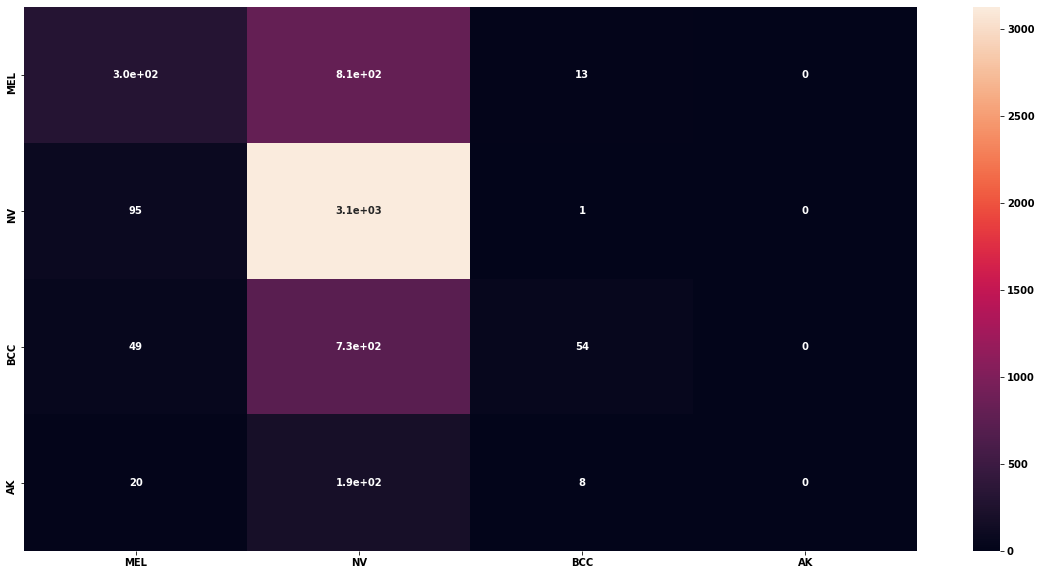

In [48]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf = tf.math.confusion_matrix(groundTruth,np.argmax(pred, axis = 1))
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
labels_names = list(gnd_truth.columns[1:-1])
df_cm = pd.DataFrame(np.array(conf), index = labels_names[:4],
                  columns = labels_names[:4])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig("saveed_figures/en_ran/conf_skin old Classes.png", dpi = 200)
plt.savefig("saveed_figures/en_ran/conf_skin old Classes.pdf", dpi = 200)

<ipython-input-49-94f88638af75>:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


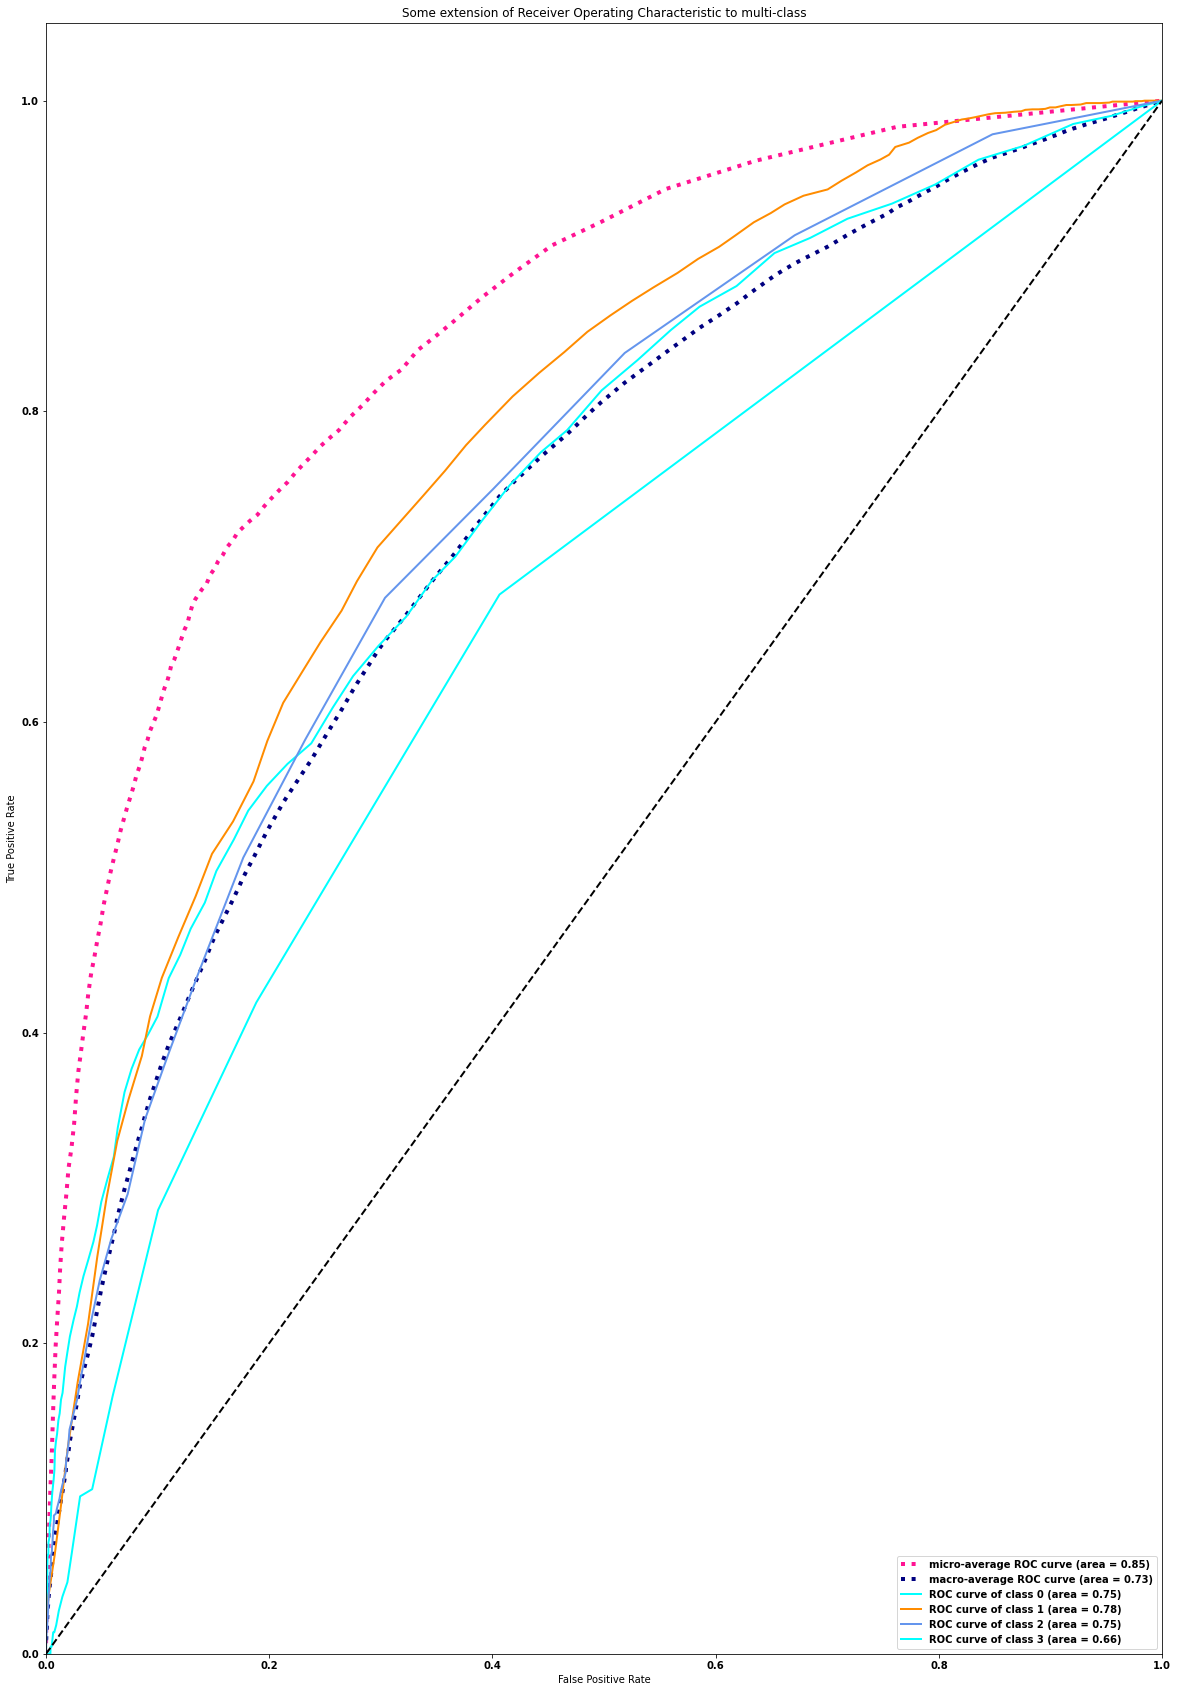

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(tf.keras.utils.to_categorical(groundTruth))
y_score = np.copy(pred)
n_classes =  4
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig("saveed_figures/en_ran/roc_skin old Classes.png", dpi = 200)
plt.savefig("saveed_figures/en_ran/roc_skin old Classes.pdf", dpi = 200)
plt.show()

In [50]:
%matplotlib inline
def plot_class_predictions(preds,idx, classes):
    
    print("Class #{}".format(idx))
    c, f = np.unique(preds, return_counts = True)
    fig = plt.figure( figsize = (30,20))
    font = {'family' : 'sans',
            'weight' : 'bold',
            'size'   : 40}
    matplotlib.rc('font', **font)
    ax = fig.add_axes([0,0,1,1 ])
    ax.set_title("{} Predictions".format(classes[idx]))
    ax.set_xlabel("Clases")
    ax.set_ylabel("Frequecy Of Predictions")
    ax.set_xticks(c)
    ax.bar(c,f)
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]

Class #0


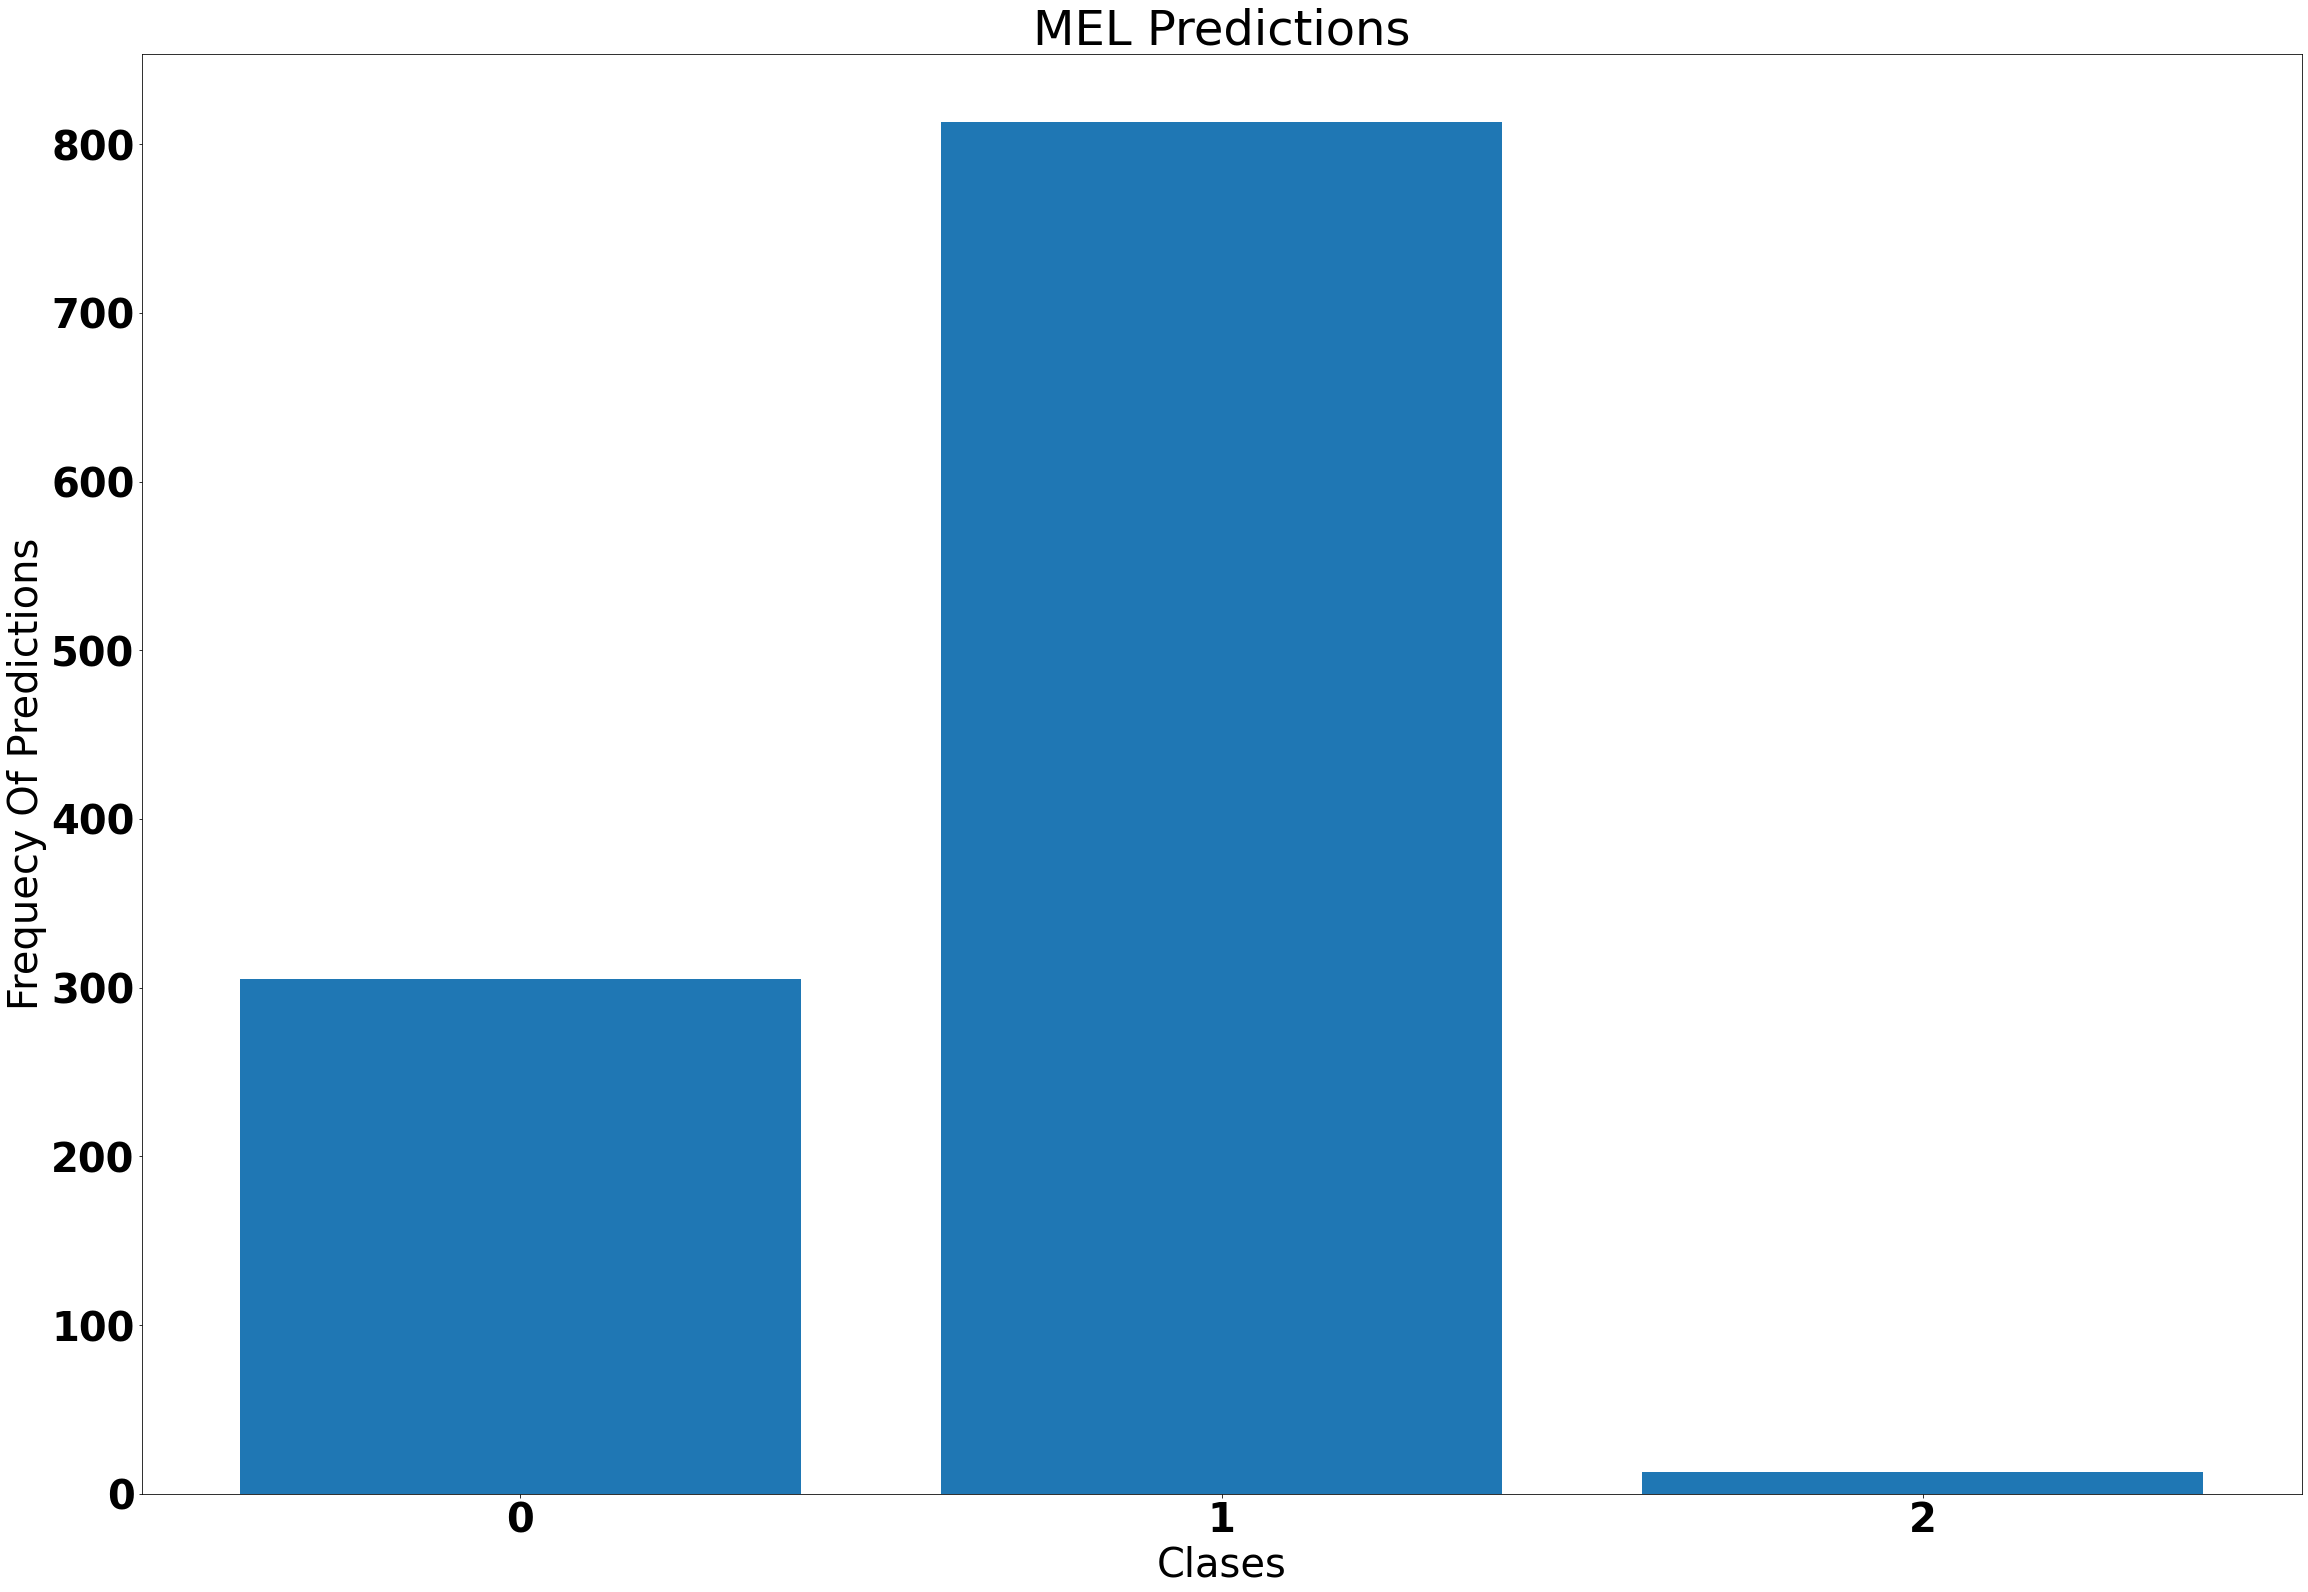

In [51]:
sclasses =list(gnd_truth.columns[1:-1])[:4]
idx = 0
c = returnClassIndex(skin_testY_,idx)
preds = sran.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses )

Class #1


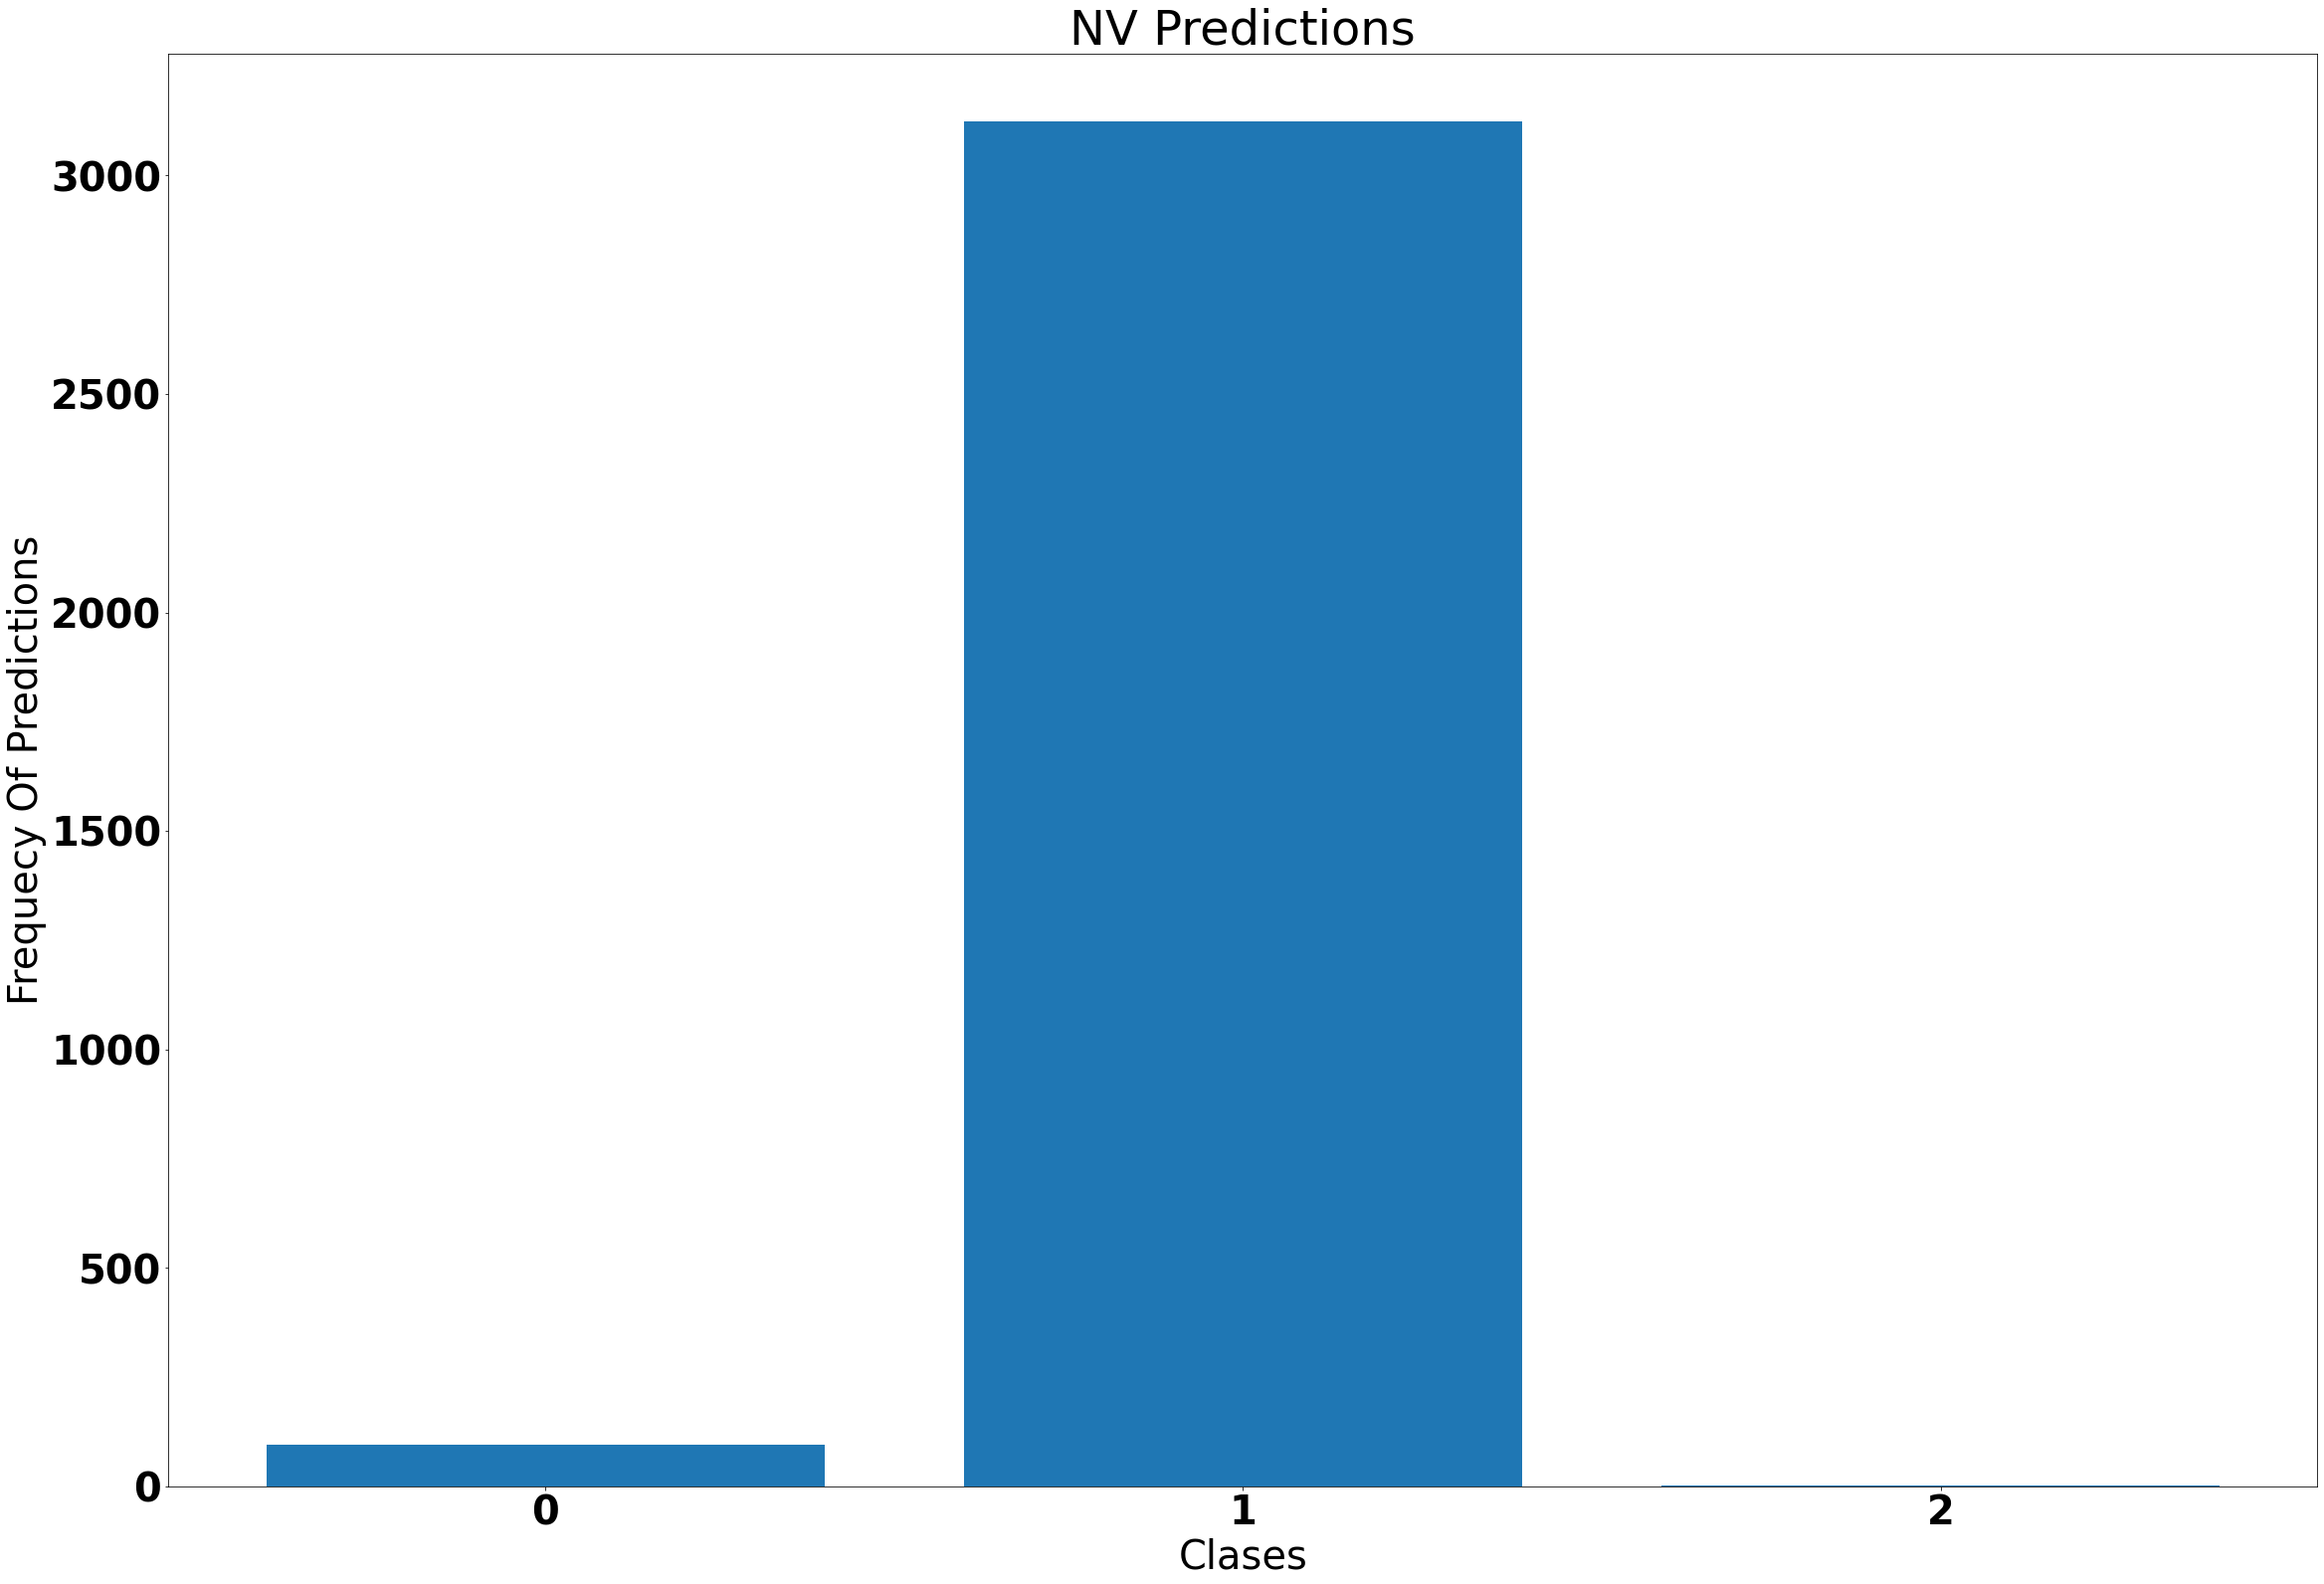

In [52]:
idx = 1
c = returnClassIndex(skin_testY_,idx)
preds = sran.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses )

Class #2


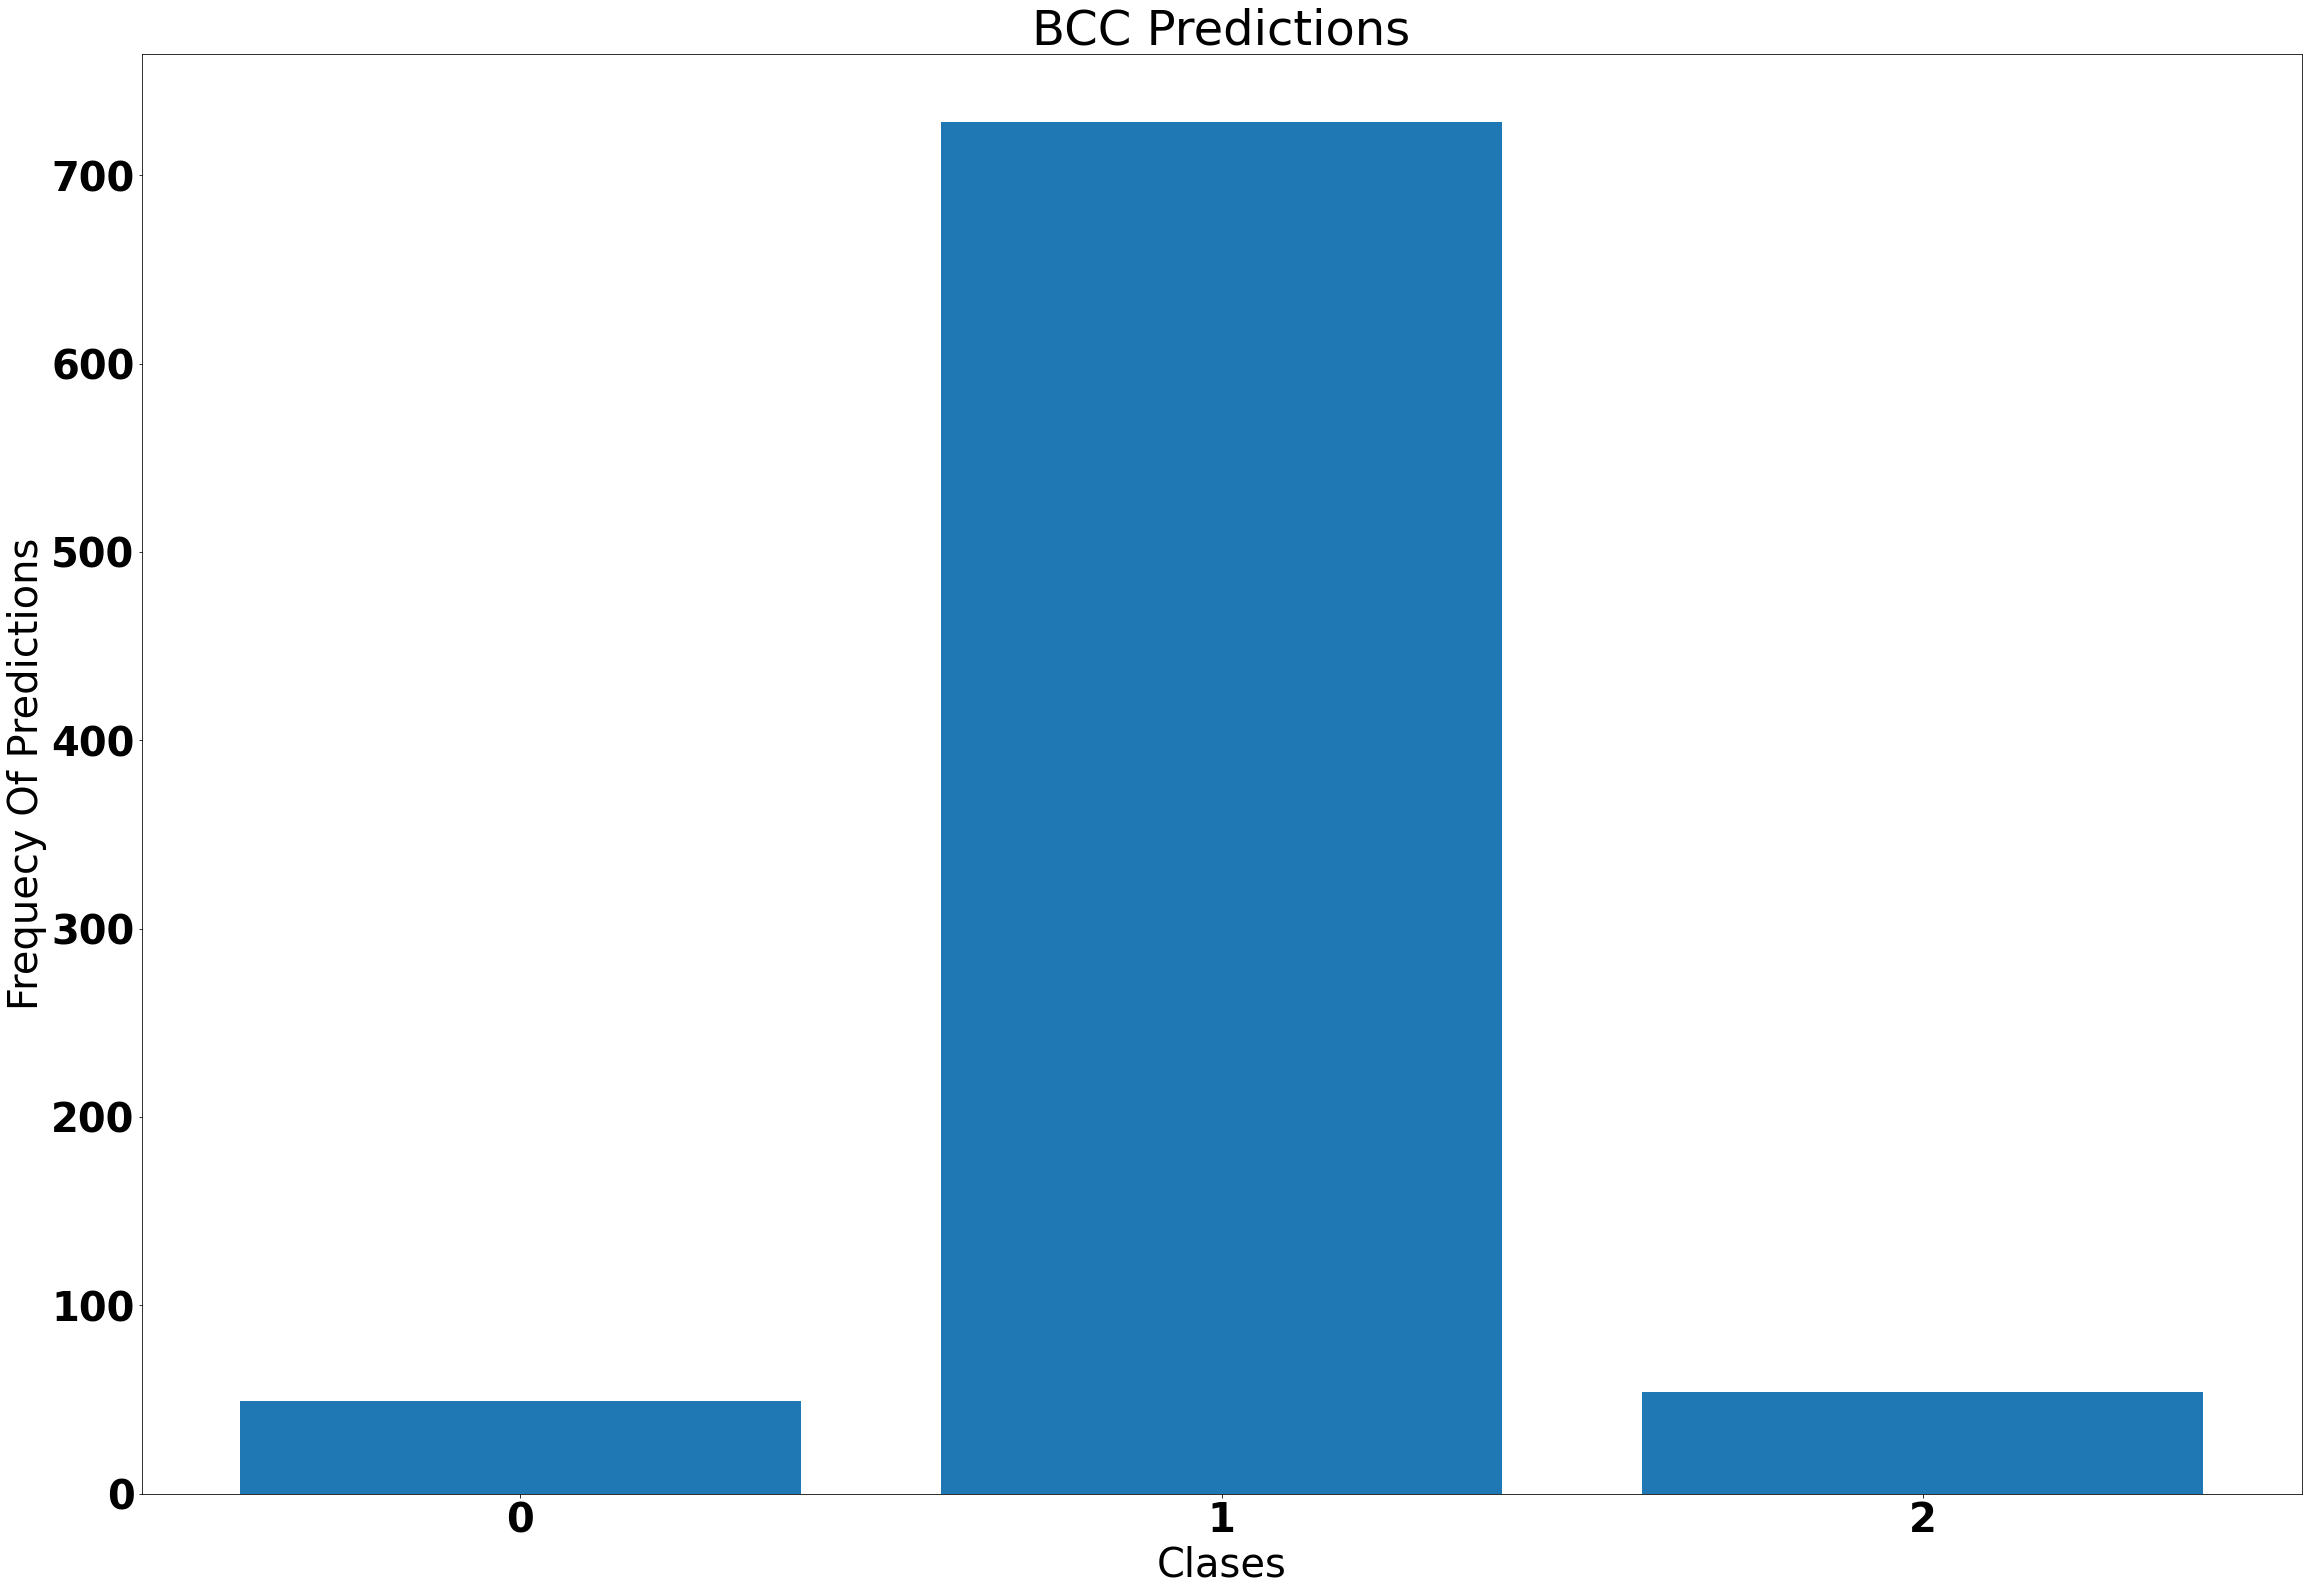

In [53]:
idx = 2
c = returnClassIndex(skin_testY_,idx)
preds = sran.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses )

Class #3


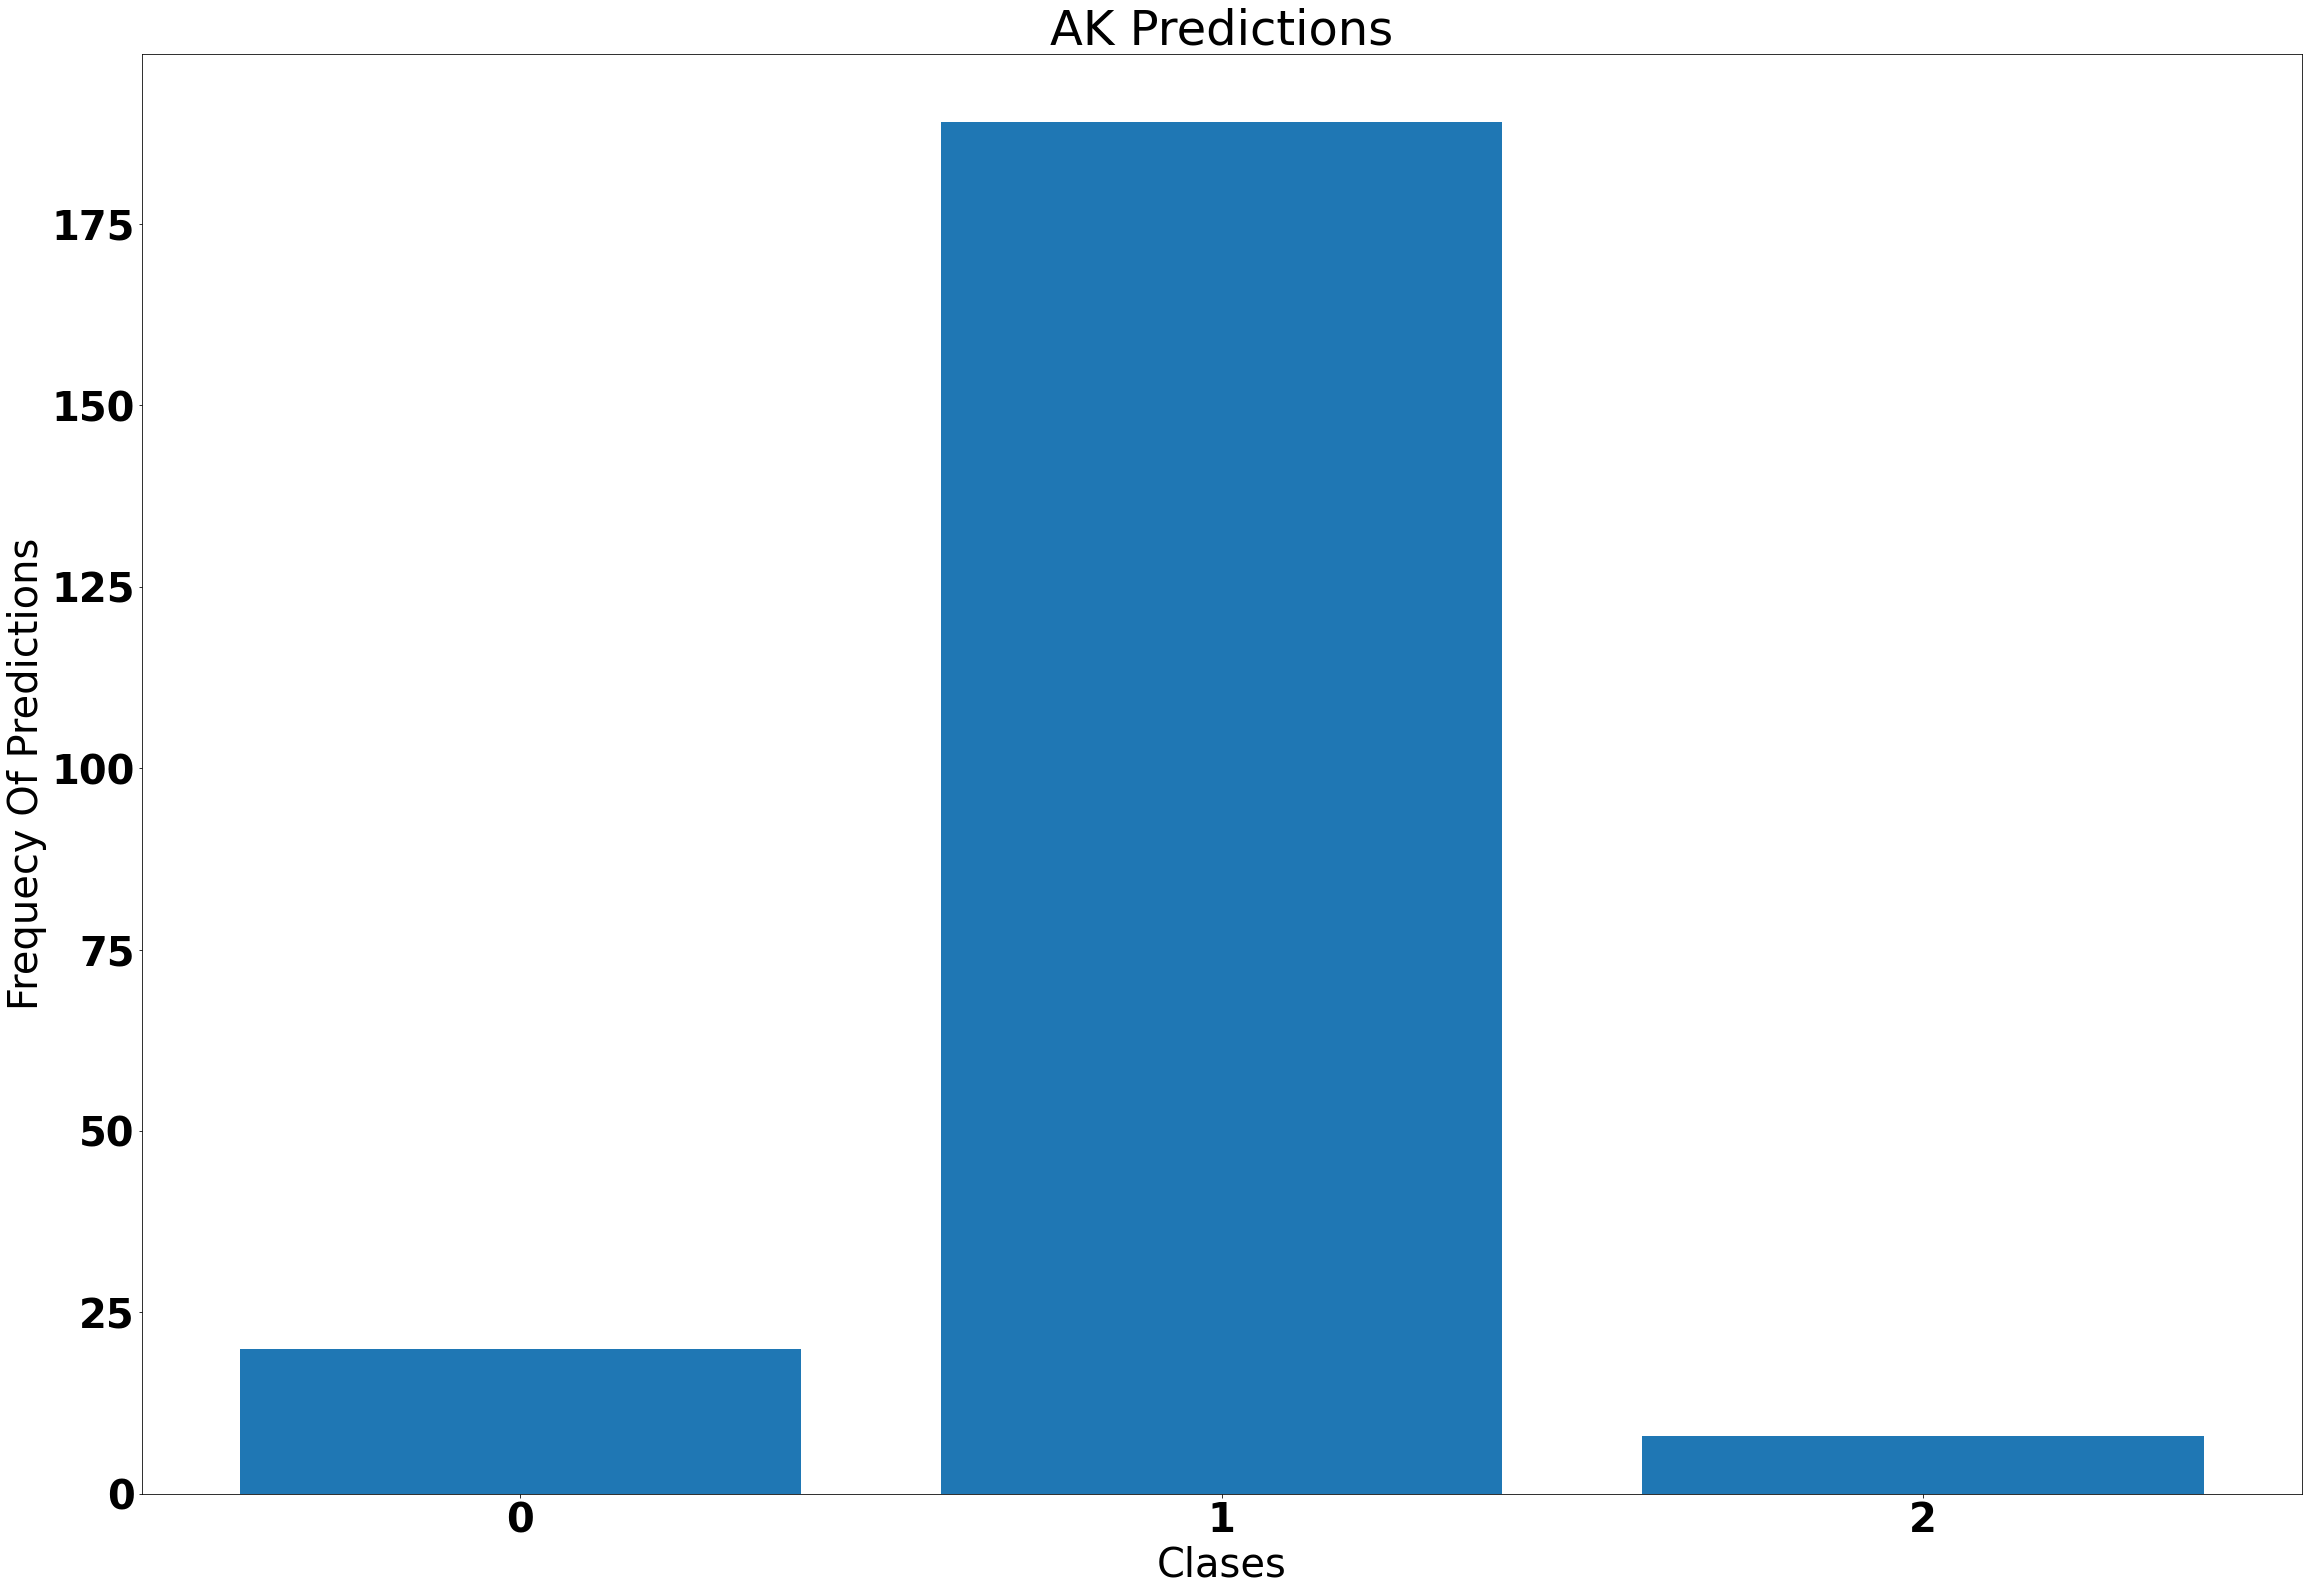

In [54]:
idx = 3
c = returnClassIndex(skin_testY_,idx)
preds = sran.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses )

## New classes

In [55]:
### Selecting the classes
hold_in_train_classes = [4,5,6,7]
hold_in_train_classes_idx = []
for i in hold_in_train_classes:
    hold_in_train_classes_idx = hold_in_train_classes_idx + returnClassIndex(skin_trainY_,i)

In [56]:
### Selecting the classes
hold_in_test_classes = [4,5,6,7]
hold_in_test_classes_idx = []
for i in hold_in_test_classes:
    hold_in_test_classes_idx = hold_in_test_classes_idx + returnClassIndex(skin_testY_,i)

In [57]:
from sklearn.metrics import accuracy_score 
groundTruth =np.argmax(skin_testY_[hold_in_test_classes_idx ], axis = 1) -4
pred = sran.predict_proba(np.vstack(skin_feat_test_[hold_in_test_classes_idx ]))

In [58]:
pred.shape

(937, 4)

In [59]:
groundTruth

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [60]:
tf.keras.utils.to_categorical(groundTruth )

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [61]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import log_loss, roc_curve

f1 = f1_score(groundTruth, np.argmax(pred, axis = 1), average = "macro")
acc = accuracy_score(groundTruth,np.argmax(pred, axis = 1))
recall = recall_score(groundTruth, np.argmax(pred, axis = 1), average = "macro")
precision =precision_score(groundTruth, np.argmax(pred, axis = 1), average = "macro")
loss = log_loss(tf.keras.utils.to_categorical(groundTruth, num_classes =4 ), pred)
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))
print("recall Score: {}".format(recall))
print("Precision Score: {}".format(precision))

Loss: 3.9309910607600056
Accuracy: 0.12913553895410887
F1 Score: 0.08036968242621202
recall Score: 0.2616298272357724
Precision Score: 0.20808806980488564


/home/trex/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


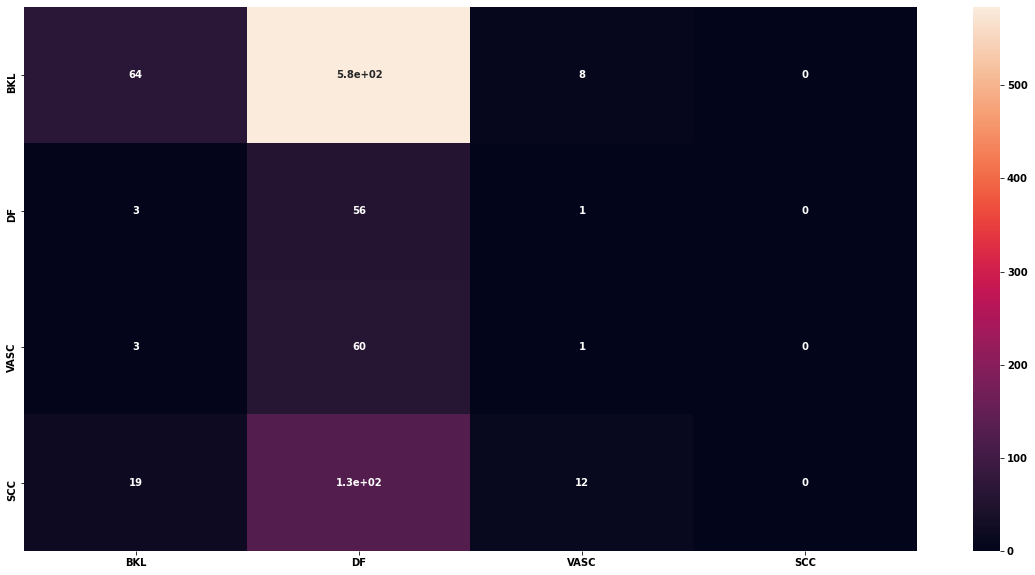

In [62]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf = tf.math.confusion_matrix(groundTruth,np.argmax(pred, axis = 1))
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
labels_names = list(gnd_truth.columns[1:-1])
df_cm = pd.DataFrame(np.array(conf), index = labels_names[-4:],
                  columns = labels_names[-4:])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig("saveed_figures/en_ran/conf_skin mew Classes.png", dpi = 200)
plt.savefig("saveed_figures/en_ran/conf_skin new Classes.pdf", dpi = 200)

In [63]:
skin_testY_[hold_in_test_classes_idx].shape

(937, 8)

In [64]:
pred.shape

(937, 4)

<ipython-input-65-07eb0141b8db>:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


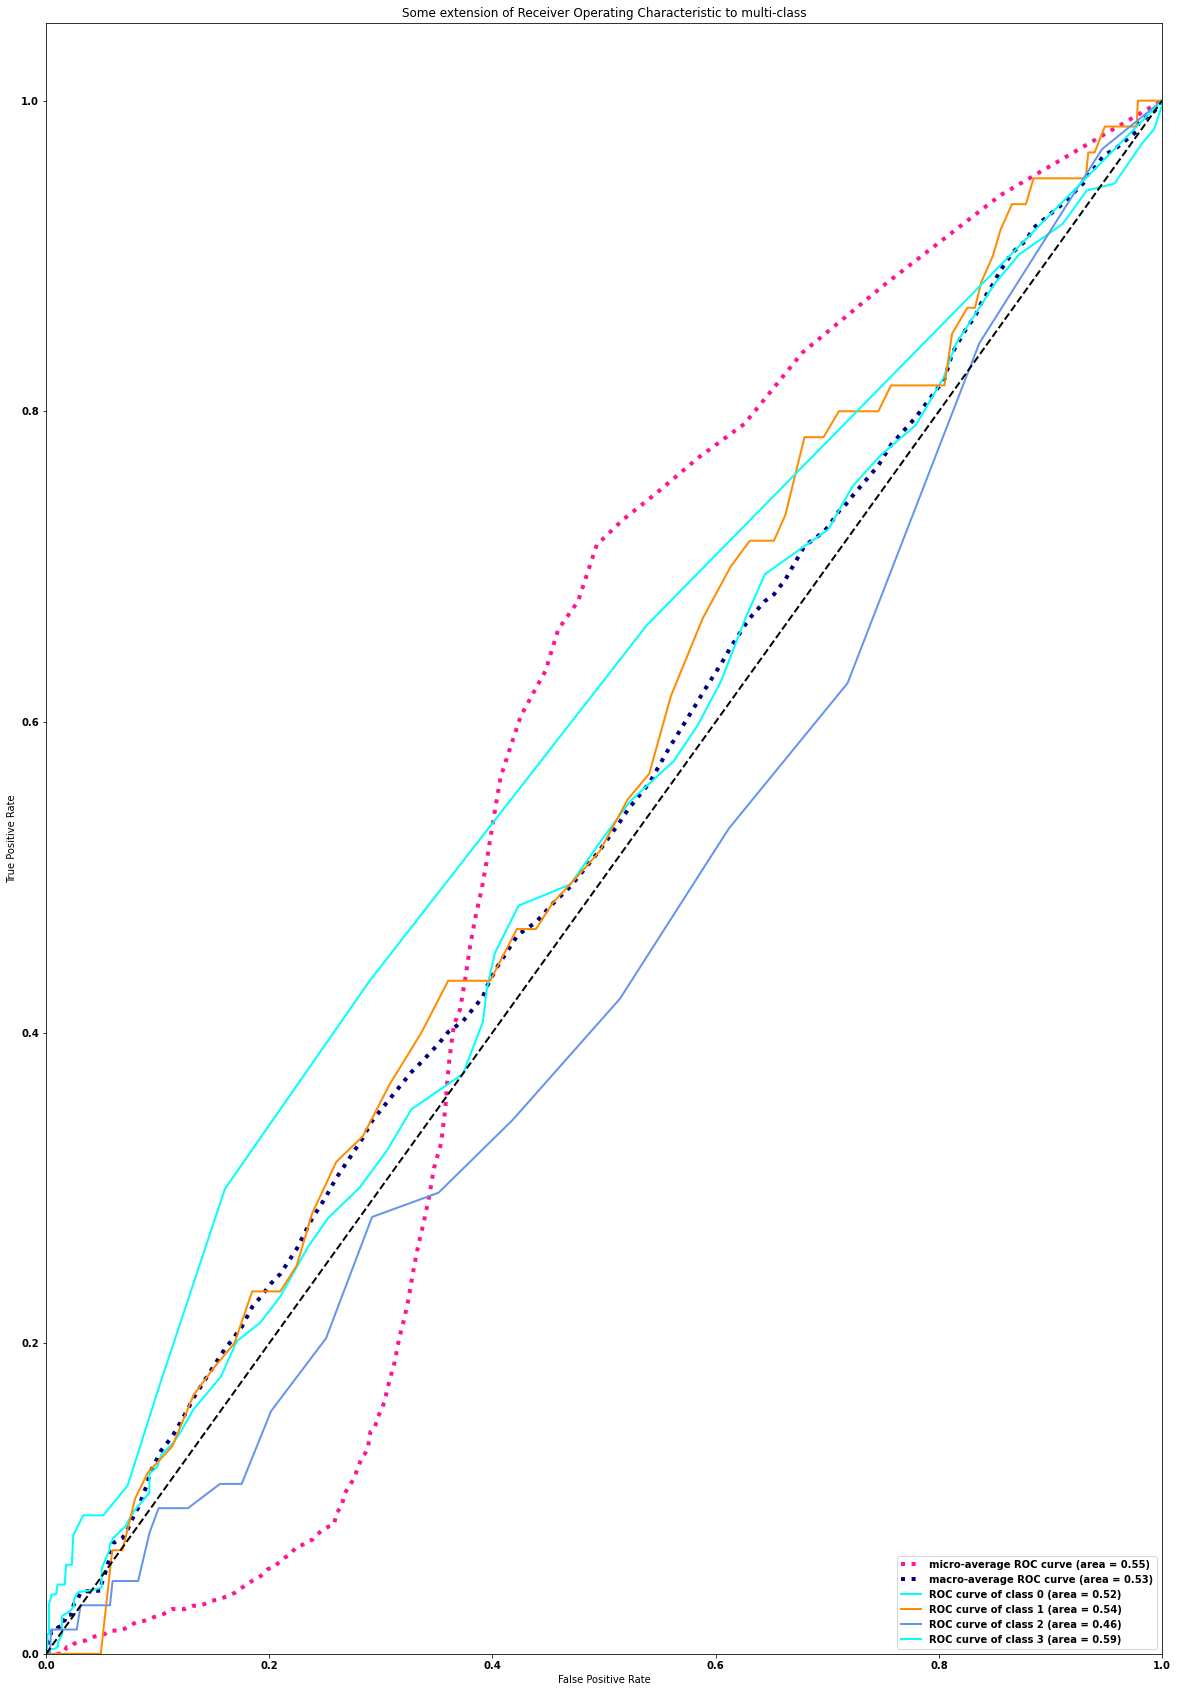

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(tf.keras.utils.to_categorical(groundTruth))
y_score = np.copy(pred)
n_classes =  4
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig("saveed_figures/en_ran/roc_skin new Classes.png", dpi = 200)
plt.savefig("saveed_figures/en_ran/roc_skin new Classes.pdf", dpi = 200)
plt.show()

In [66]:
%matplotlib inline
def plot_class_predictions(preds,idx, classes):
    
    print("Class #{}".format(idx))
    c, f = np.unique(preds, return_counts = True)
    fig = plt.figure( figsize = (30,20))
    font = {'family' : 'sans',
            'weight' : 'bold',
            'size'   : 40}
    matplotlib.rc('font', **font)
    ax = fig.add_axes([0,0,1,1 ])
    ax.set_title("{} Predictions".format(classes[idx]))
    ax.set_xlabel("Clases")
    ax.set_ylabel("Frequecy Of Predictions")
    ax.set_xticks(c)
    ax.bar(c,f)
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]

Class #0


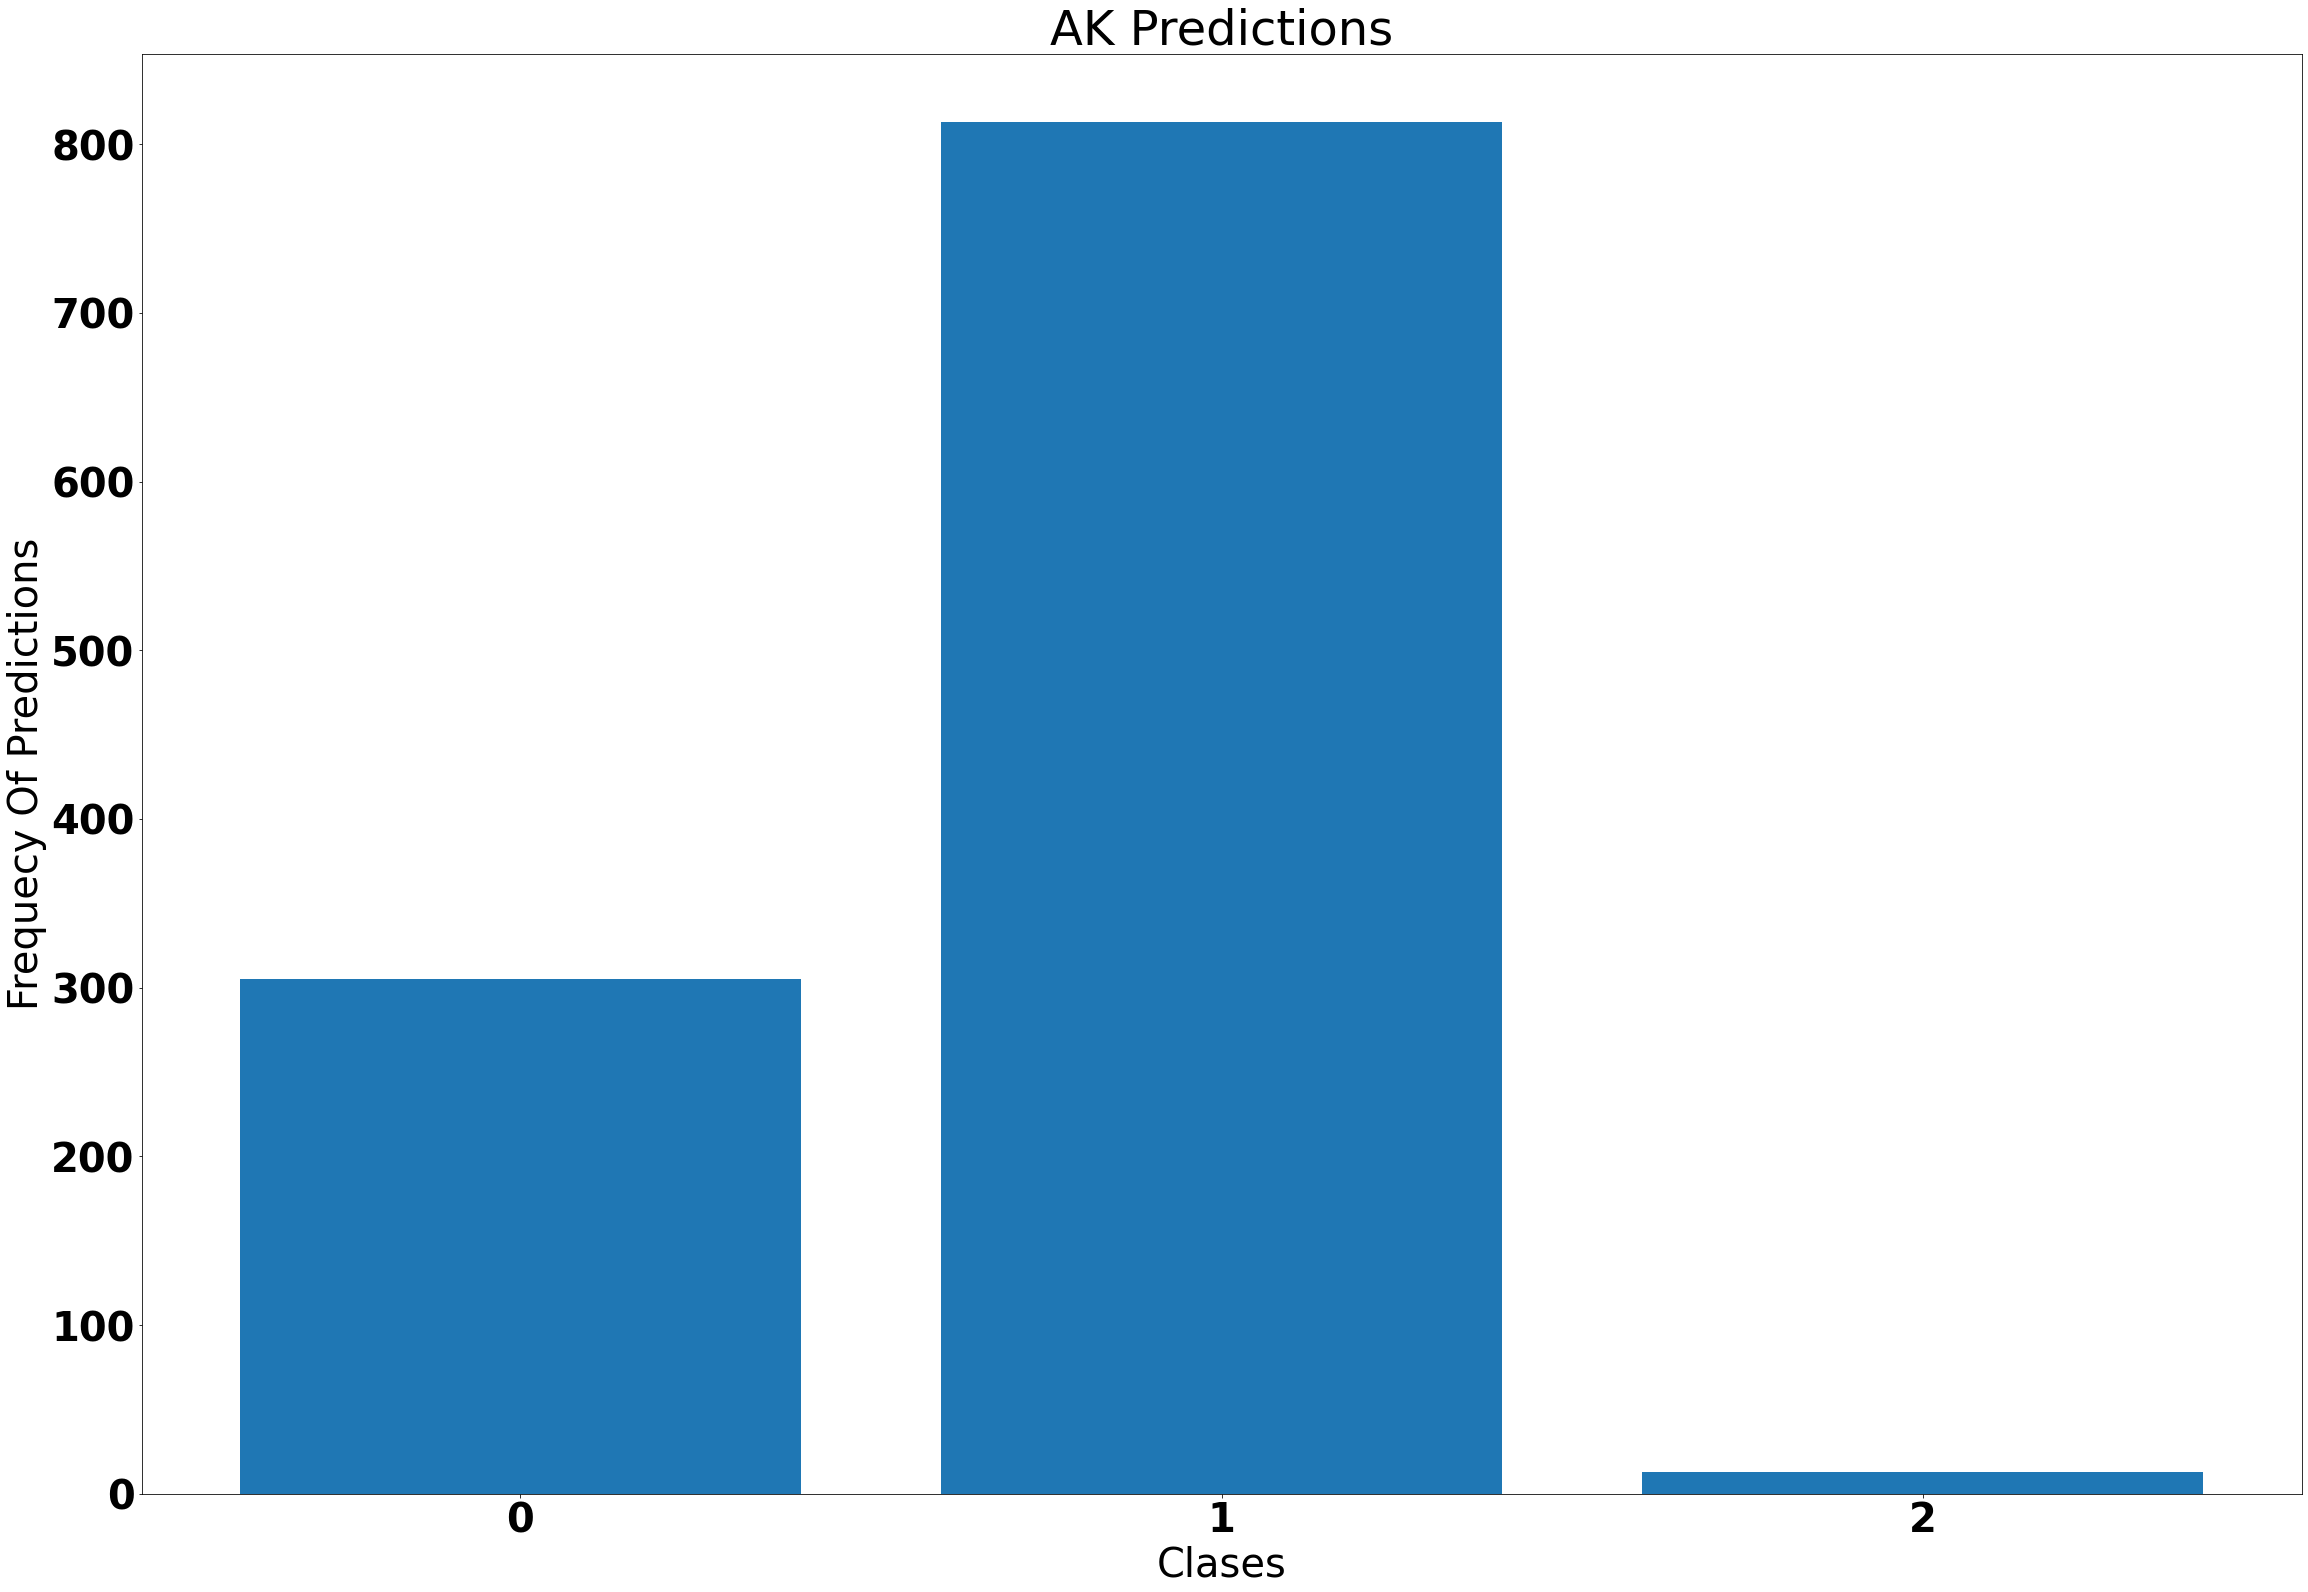

In [67]:
sclasses =list(gnd_truth.columns[1:-1])[3:]
idx = 0
c = returnClassIndex(skin_testY_,idx)
preds = sran.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses )

Class #1


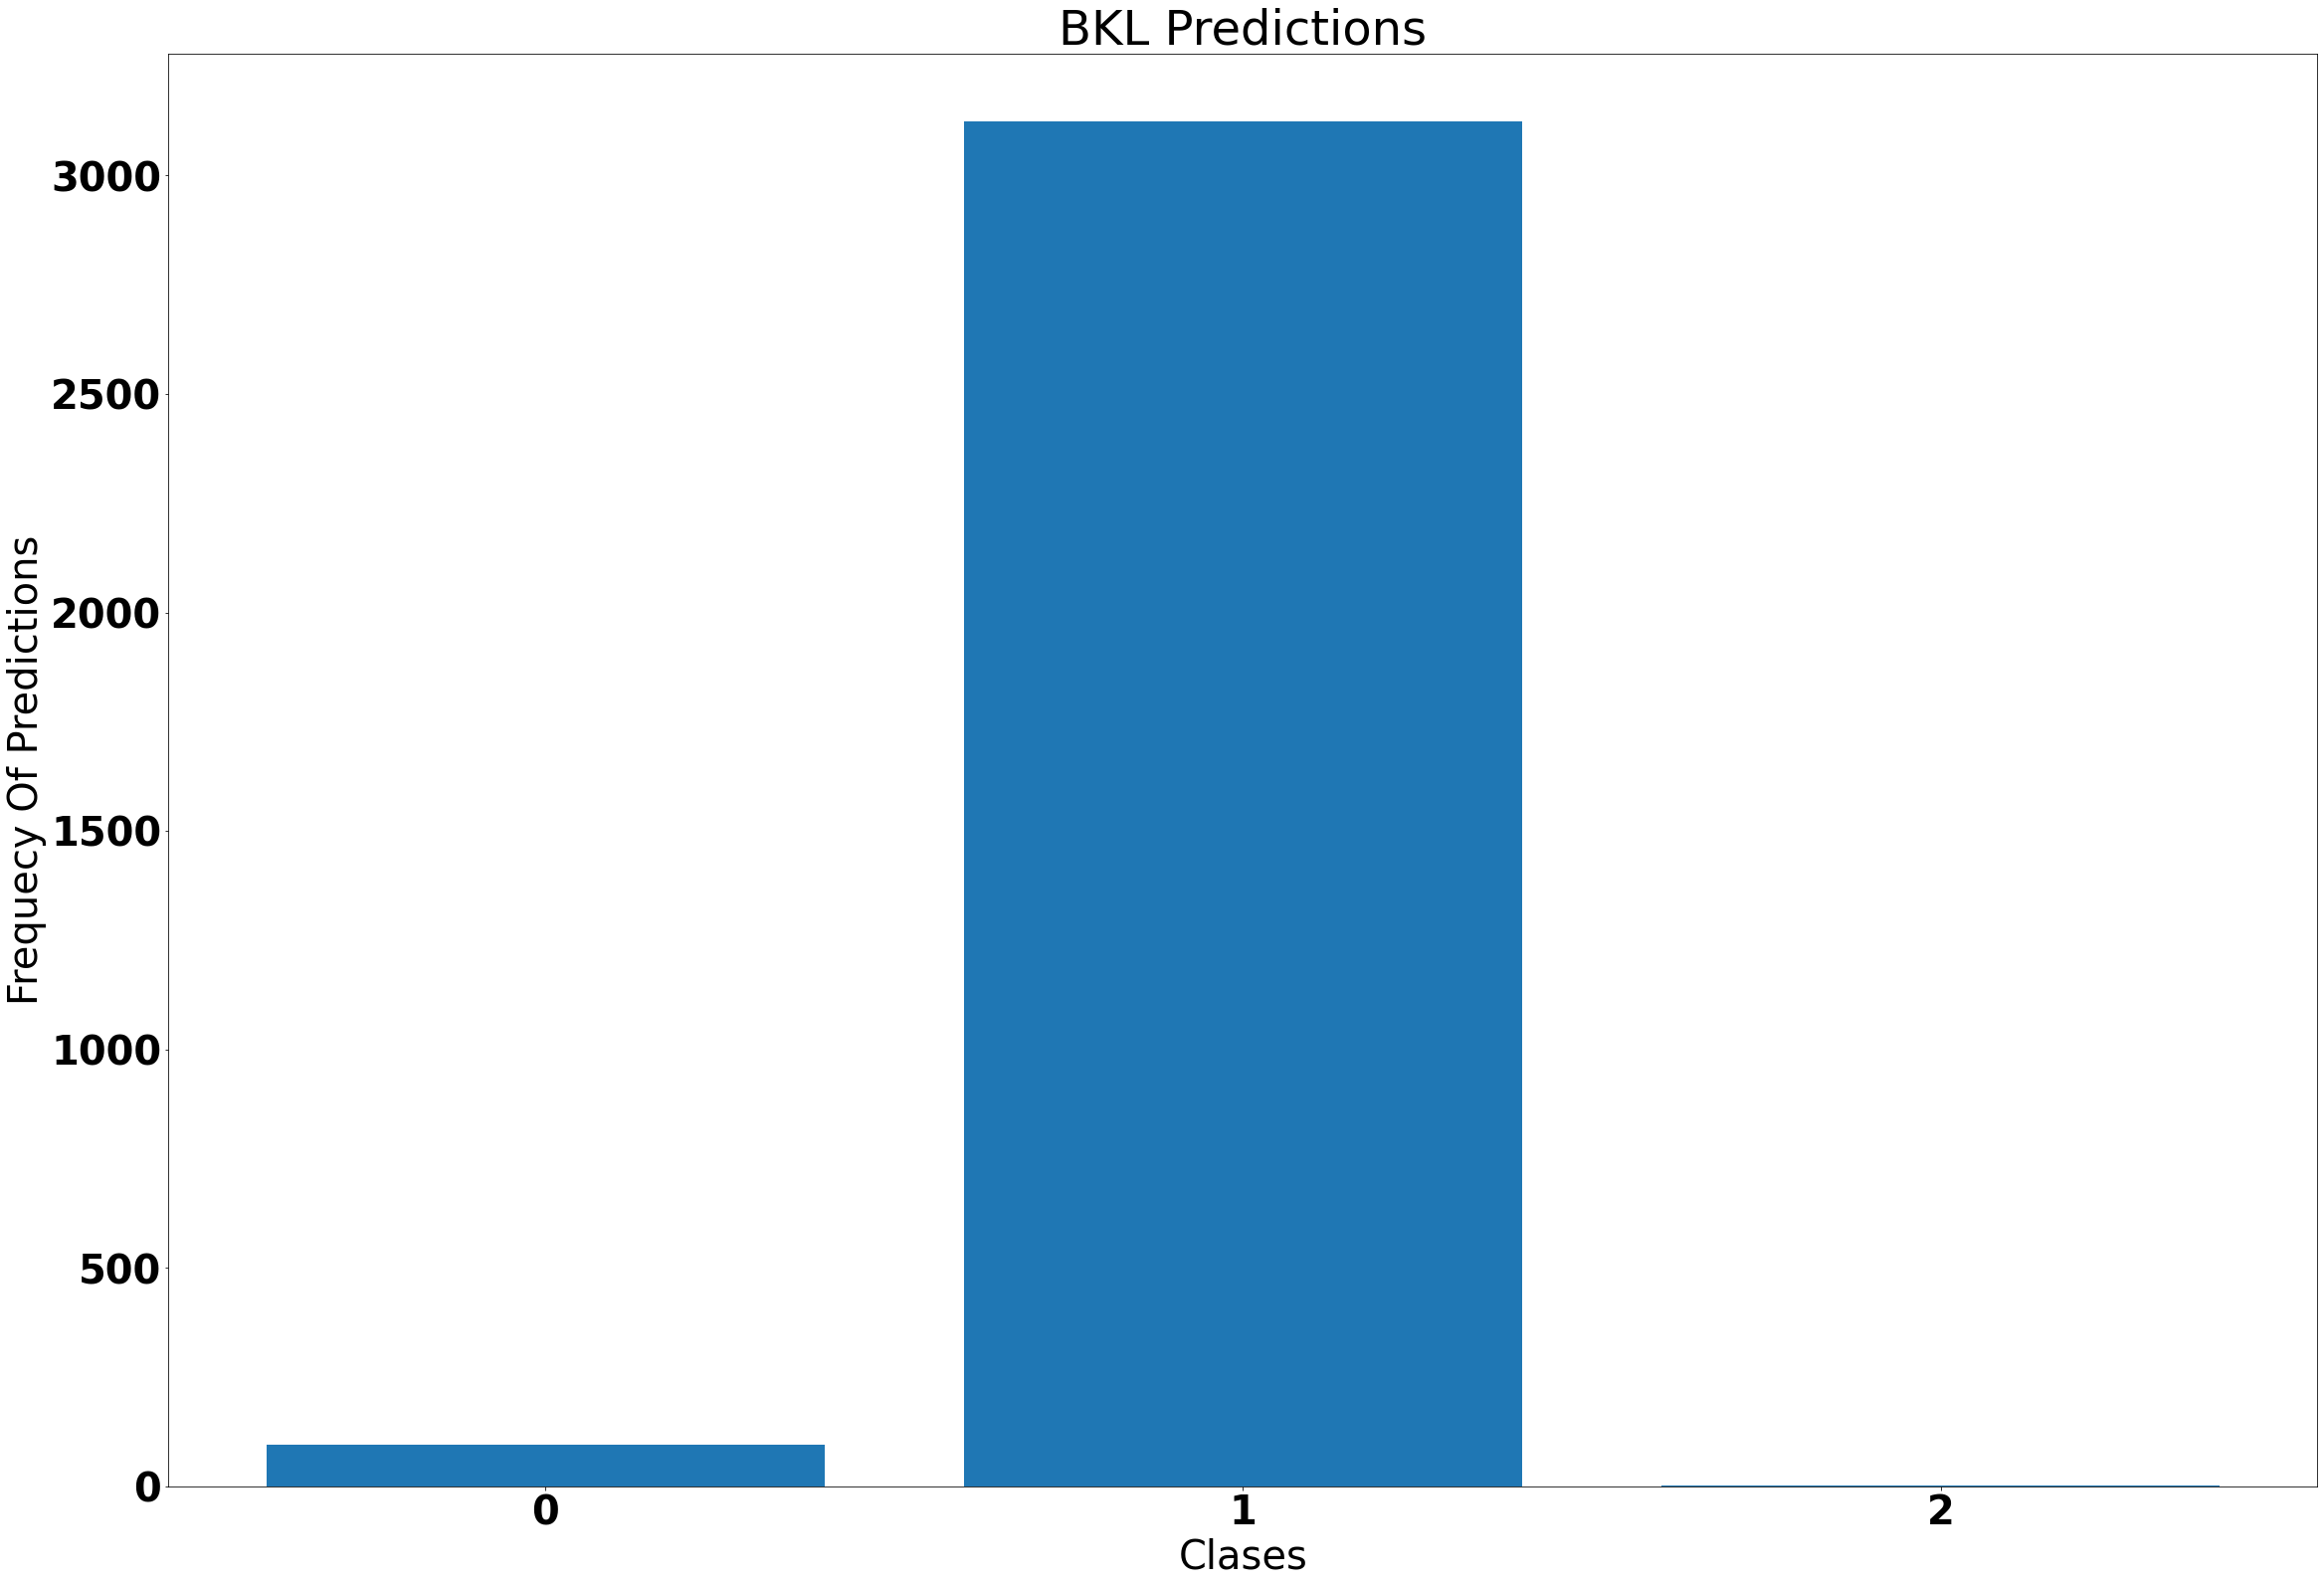

In [68]:
idx = 1
c = returnClassIndex(skin_testY_,idx)
preds = sran.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses )

Class #2


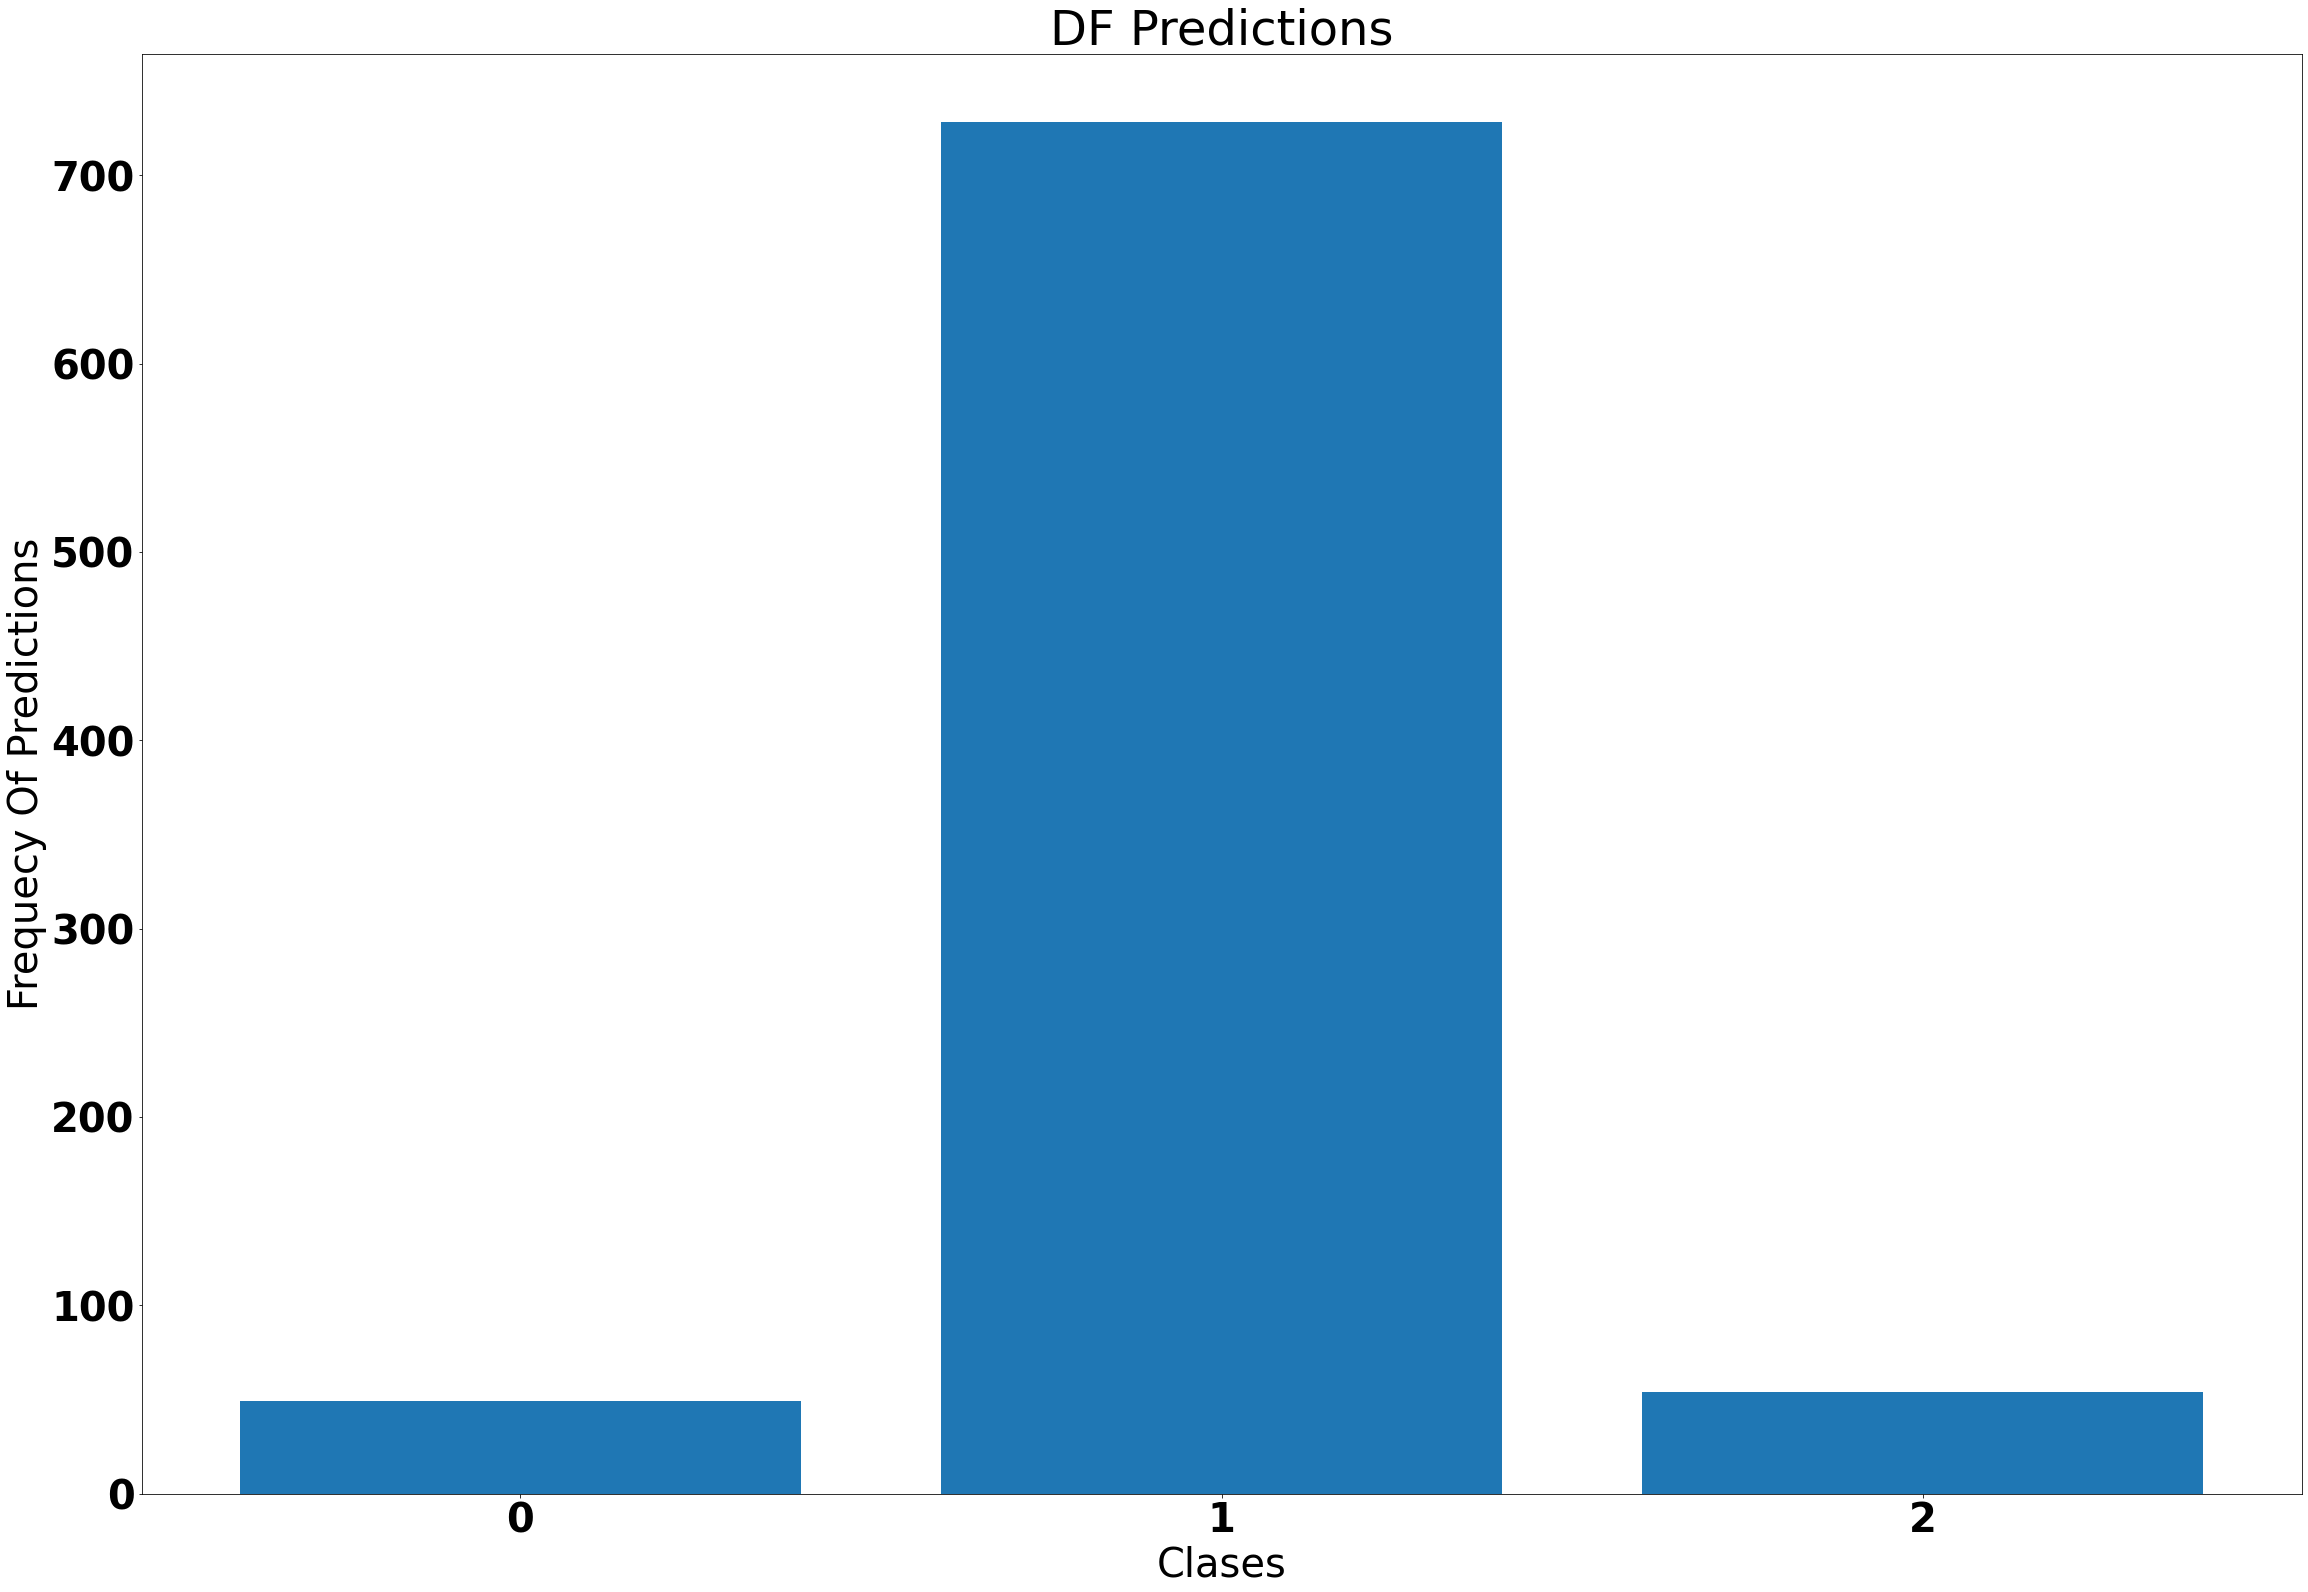

In [69]:
idx = 2
c = returnClassIndex(skin_testY_,idx)
preds = sran.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses )

Class #3


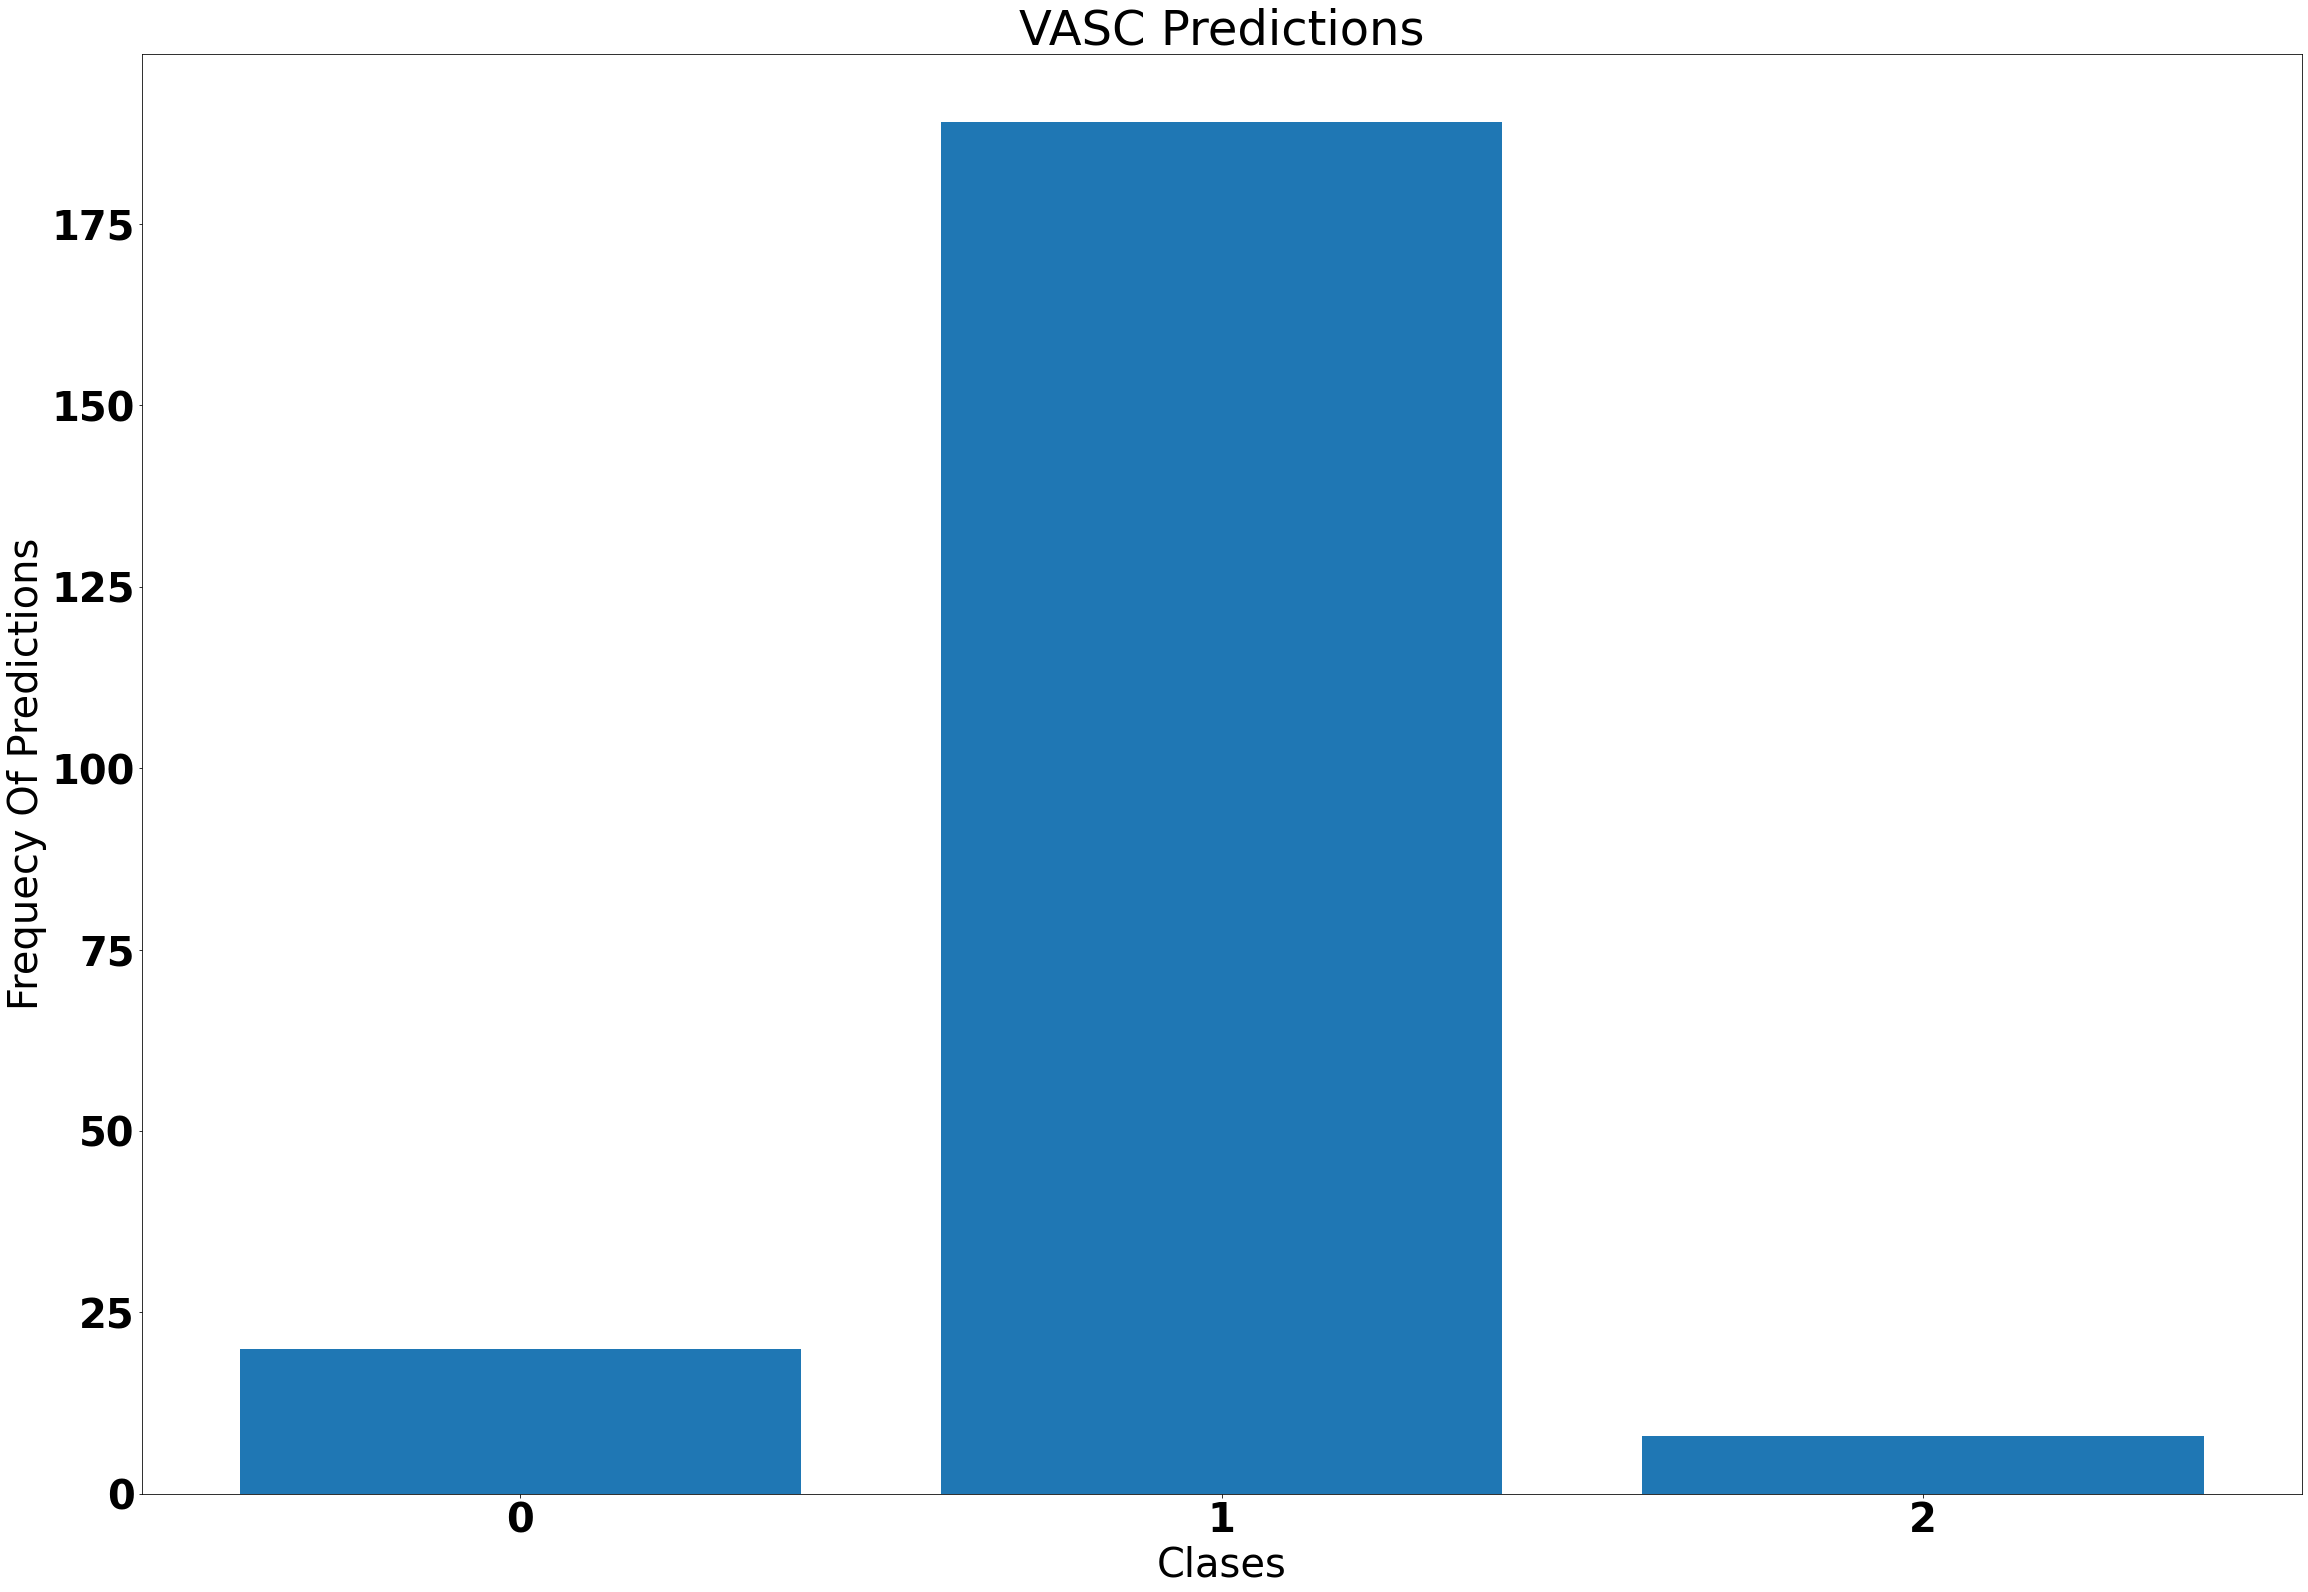

In [70]:
idx = 3
c = returnClassIndex(skin_testY_,idx)
preds = sran.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses )

Class #4


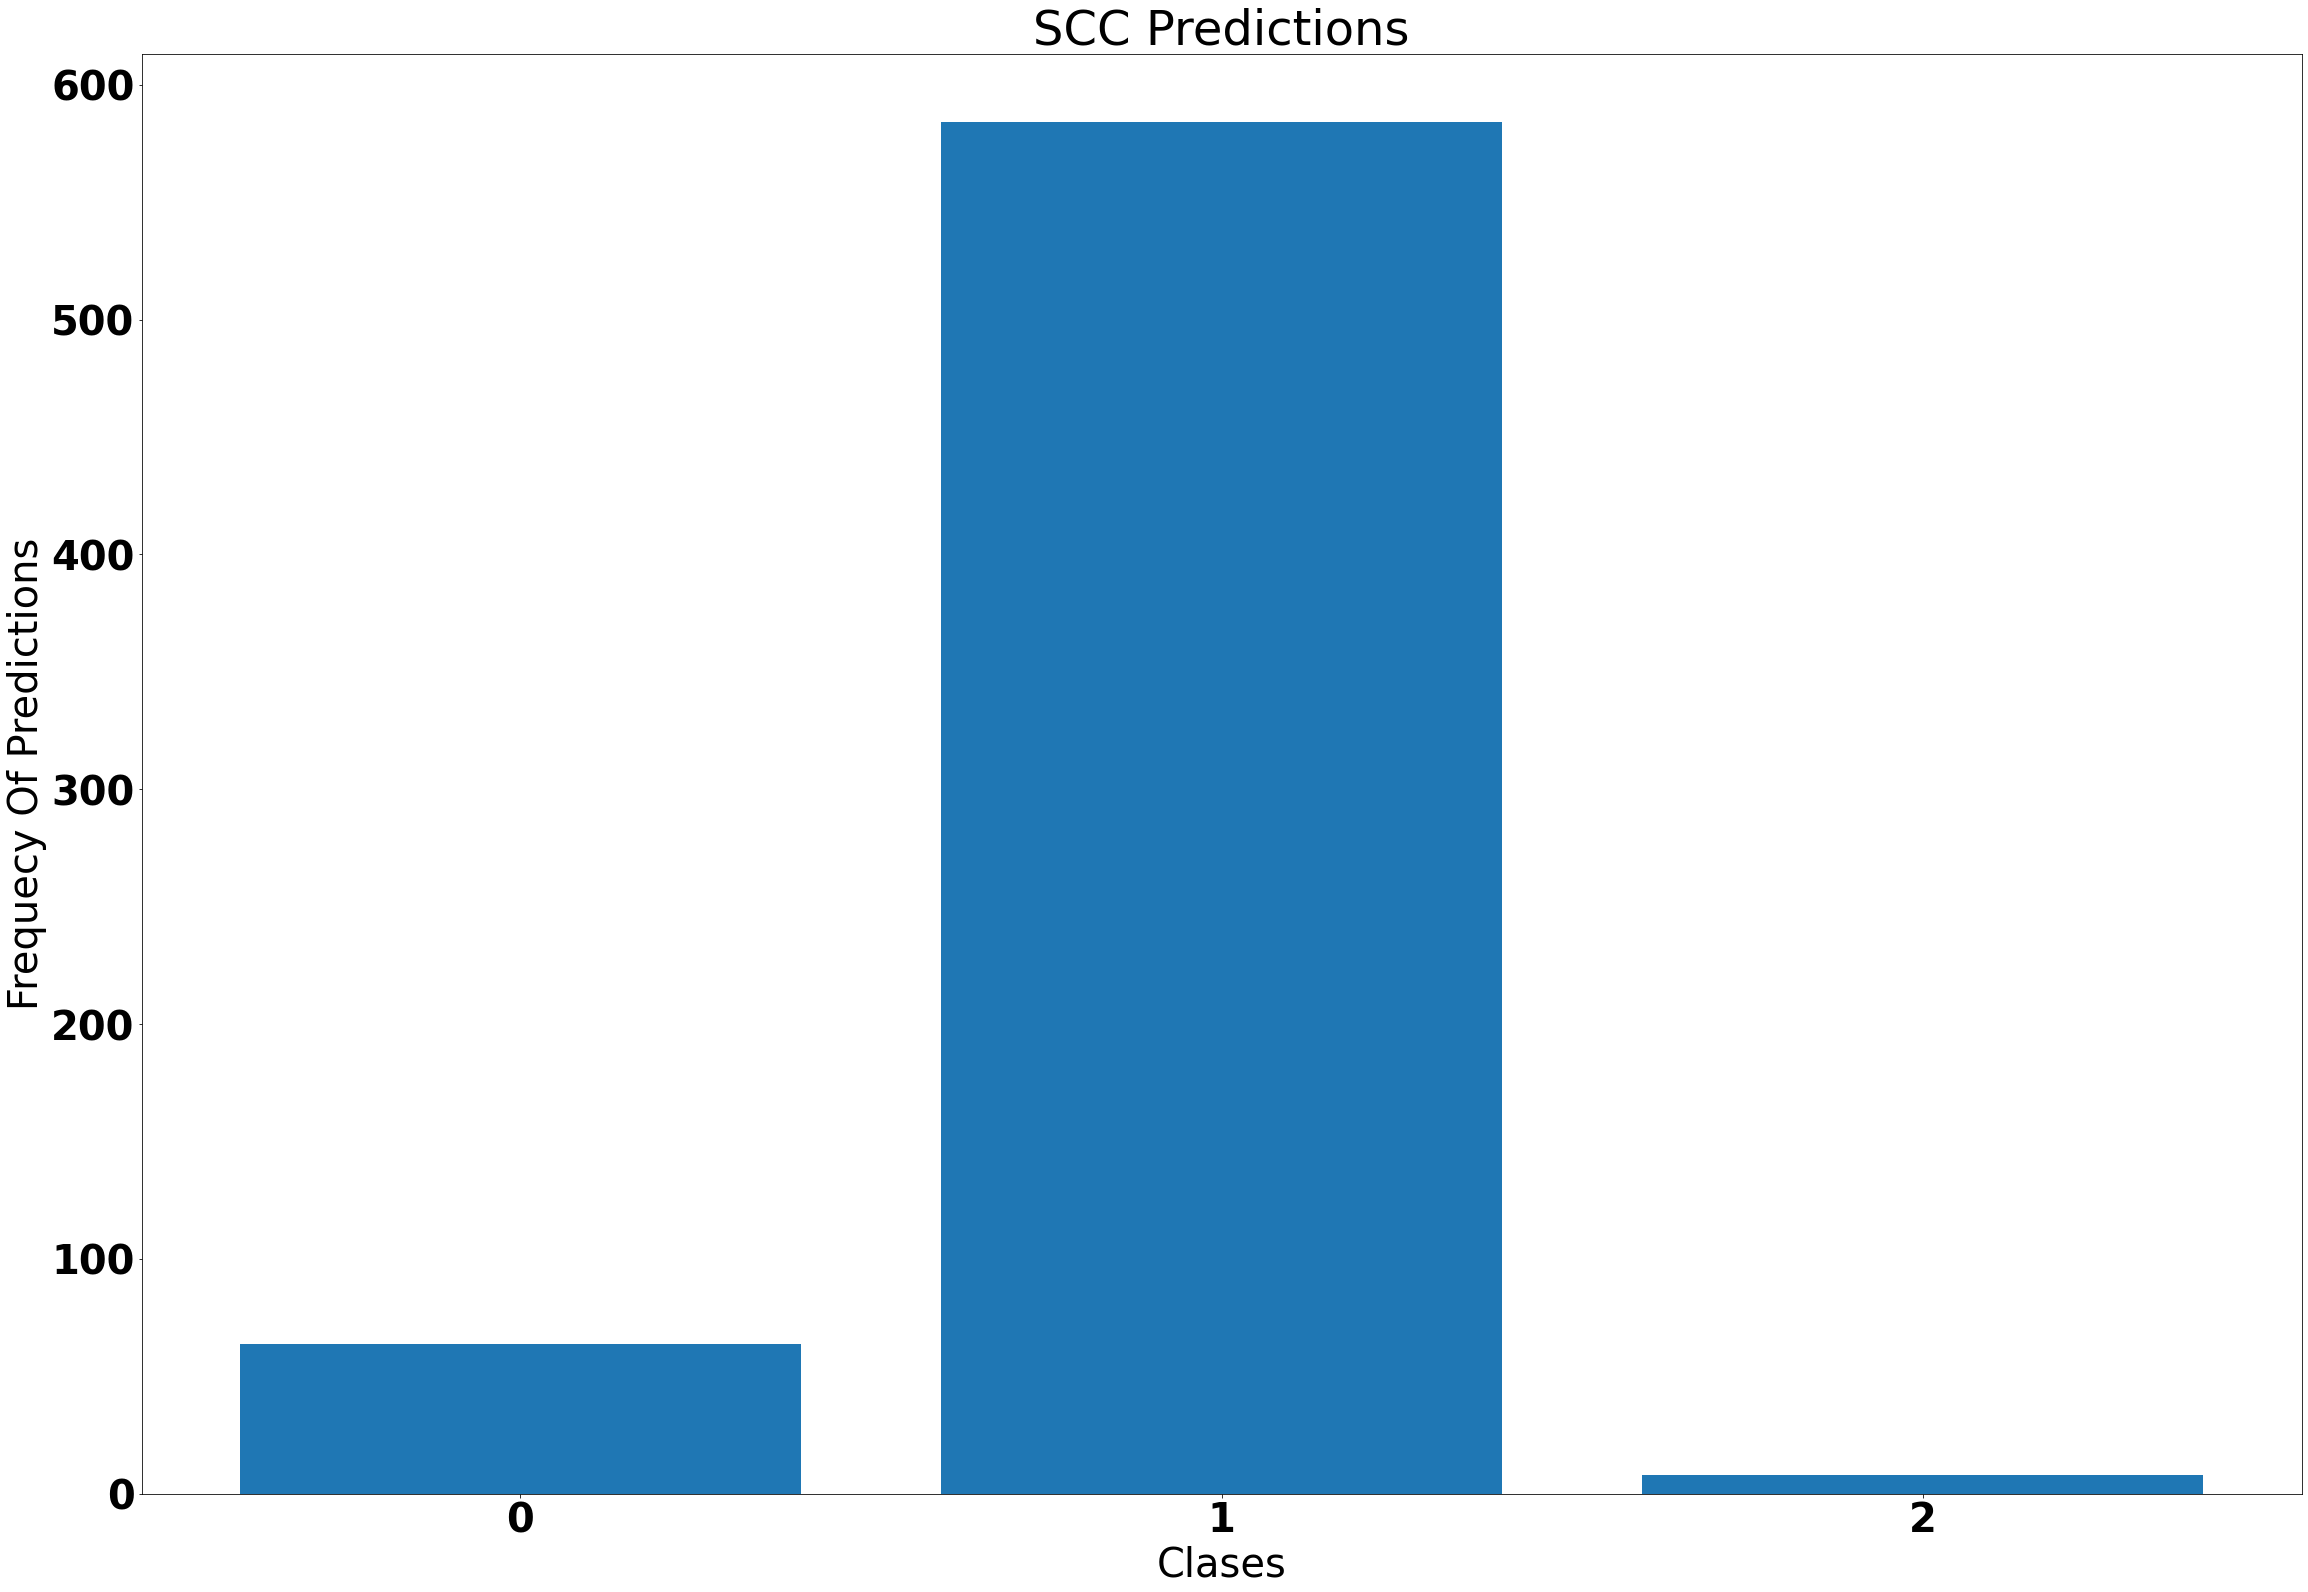

In [71]:
idx = 4
c = returnClassIndex(skin_testY_,idx)
preds = sran.predict(skin_feat_test_[c])
plot_class_predictions(preds, idx,sclasses )